# American Options Analysis with Discrete Dividends

This notebook provides a comprehensive framework for pricing American options with discrete cash dividends and calculating implied volatility using numerical methods.

## Notebook Overview

**Key Features:**
- American vs European option comparison with interactive visualizations
- Discrete cash dividend modeling (not continuous yield)
- Binomial tree pricing (CRR method) for American options
- Numerical root finding for American implied volatility
- Put-call parity regression for forward price extraction
- Volatility surface construction using log-moneyness
- Early Exercise Premium (EEP) calculations

**Data Source:** Databento historical AAPL options market data

**Target Audience:** Quantitative analysts, options traders, and financial engineers working with dividend-paying equities

## American Options

#### The Black-Scholes PDE for American Call Option with Dividends

The American call option $C_A(S, \tau)$ satisfies the Black-Scholes PDE:

$$
\frac{\partial C_A}{\partial \tau} = \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 C_A}{\partial S^2} + (r - q)S \frac{\partial C_A}{\partial S} - rC_A
$$

where:
- $S$ is the stock price
- $\tau = T - t$ is the time to maturity
- $r$ is the risk-free rate
- $q$ is the continuous dividend yield
- $\sigma$ is the volatility 

**Black-Scholes American Option:**
PDE holds for: $0 \leq \tau \leq T$, $0 < S \leq b(v, \tau)$


Most tutorials including my own, tend to focus on backing out implied volatilites assuming the standard Black Scholes Merton formula, however there are many exchange traded options are American stye, carying with them the right of early exerise. 

Therefore let's aim to build up a practical intuition in this tutorial:

### Q1. What are they, how are they different to European options?

- 1a. what is the difference between European and American options?
- 1b. should a trader consider early exercise and under what conditions?
- 1c. if early exercise is desirable, is there an optimal time?
- 1d. what is the additional value over a European option a trader should pay for this optionality?

Resources:
- [American Options (Hull 7.4, 7.5)](https://www.math.ucla.edu/~caflisch/181.1.07w/Lect18.pdf)
- [Optimal Exercise Price](https://quant.stackexchange.com/questions/18866/analytic-formula-for-the-value-of-an-american-put-option)

### Q2. Where are the model differences and should I care?
 - 2a. If you care, what pricing models can you use?

### Q3. How can I calculated Implied Volatility based on this pricing model?
- Calculate IV based on realistic pricing models
- Calculate IV based on fast BSM models + adjustments
- Imply realtime IV curves for each update (time slice)

Resources: [Calculating Implied Volatility with American Options](https://quant.stackexchange.com/questions/1489/how-should-i-calculate-the-implied-volatility-of-an-american-option-in-a-real-ti)






### Q1a. What is the difference between American vs European?

#### Boundary Conditions: European vs American

The key difference between European and American options lies in their boundary conditions.

**Black-Scholes European Option :**
PDE holds for: $0 \leq \tau \leq T$, $S > 0$

**Black-Scholes American Option:**
PDE holds for: $0 \leq \tau \leq T$, $0 < S \leq b(v, \tau)$

![Early Exercise Boundary](earlyexerciseboundary.png)

#### The Early Exercise Premium

The Barone-Adesi-Whaley (1987) model is an analytic approximation for American options. The approximation recognizes that the American call can be decomposed as:

$$
C_A = C_E + V
$$

where:
- $C_E$ is the European call value
- $V$ is the **early exercise premium**

The core idea of the approximation is to solve a quadratic approximation to the early-exercise premium V, and the optimal exercise boundary depends on this carry term:

$carry=r−q$

The early exercise premium $V$ represents the additional value from the right to exercise early. 


It solves for the early-exercise premium on top of the standard dividend-adjusted Black-Scholes model.
Both interest rates and dividends enter the model, because the optimal early-exercise boundary depends on the carry term.
The entire point of BAW is to tell you how much value early exercise adds because of those rates and dividends.

For a call on a non-dividend-paying stock ($q = 0$), we have $V = 0$ since early exercise is never optimal.


#### Why Numerical Methods Are Needed

**The free boundary problem has no closed-form solution** because:

1. **Coupled nonlinearity**: The boundary $S^*$ is coupled with option values in the continuation region
2. **Path-dependent optimization**: At each time $t$ and price $S$, compare: exercise value vs. continuation value
3. **Time-varying boundary**: $S^*(\tau)$ changes with time to maturity

**Numerical methods solve this by:**

- **Binomial trees**: Discretize time and stock price, work backwards checking early exercise at each node
- **Finite differences**: Discretize the PDE and apply the early exercise constraint at each grid point
- **Monte Carlo with regression**: Estimate continuation values and compare to exercise values

**Analytical approximations (BAW, log-linear)** avoid the computational cost by:
- Imposing a functional form on either the premium or boundary
- Trading off exactness for speed, and can achieving accuracy within 0.1-1% for most practical cases

---

## Section 1: Interactive American vs European Comparison

This section demonstrates the fundamental difference between American and European options through interactive visualizations. The key insight: **American puts can have significant early exercise value**, especially for dividend-paying stocks or when deep in-the-money.

### Q1a. Answer: Boundary Conditions, Early Exercise.

### Q1b. should a trader consider early exercise and under what conditions?

Why should early exercise become desirable? 

When there is some advance to holding the position in the underlying contract rathan than the position in the option contract.

This advantage is either:
1. dividends that the owner of the stock will receive; or
2. positive cashflow on interest earned (or cost of carry consideration).

In the case there are no dividend or interest considerations, then the value of the American option should equal the value of a European option. For example, on options where futures-type settlement applies, futures contracts do not pay dividends.

### Implementation: Black-Scholes and Binomial Tree Pricing

**Black-Scholes Assumptions:**
- No early exercise (European only)
- Continuous dividend yield approximation
- Closed-form solution

**Binomial Tree Advantages:**
- Handles American early exercise
- Works with discrete dividends
- Flexible for complex payoffs

The code below implements both methods for direct comparison.

In [439]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import ipywidgets as widgets
# from IPython.display import display

# Black–Scholes European formulas
def bs_call(S, K, r, sigma, T):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

def bs_put(S, K, r, sigma, T):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Binomial tree for American option
def american_binomial(S, K, r, sigma, T, N, opt_type="call"):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1/u
    p = (np.exp(r * dt) - d) / (u - d)

    # stock prices
    ST = np.array([S * u**j * d**(N-j) for j in range(N+1)])

    # terminal payoff
    if opt_type == "call":
        V = np.maximum(ST - K, 0)
    else:
        V = np.maximum(K - ST, 0)

    # backward induction
    for i in range(N-1, -1, -1):
        ST = ST[1:] / u  # step down tree
        V = np.exp(-r*dt)*(p*V[1:] + (1-p)*V[:-1])
        intrinsic = (ST - K) if opt_type == "call" else (K - ST)
        V = np.maximum(V, intrinsic)

    return V[0]

# Parameters 
S_range = np.linspace(50, 150, 100)
K = 100
sigma = 0.25
T = 1.0
N = 200

# Create interactive plot function 
def plot_options(q, r):
    # Compute option values
    euro_calls = [bs_call(s, K, r - q, sigma, T) for s in S_range]
    euro_puts = [bs_put(s, K, r - q, sigma, T) for s in S_range]
    
    amer_calls = [american_binomial(s, K, r - q, sigma, T, N, "call") for s in S_range]
    amer_puts = [american_binomial(s, K, r - q, sigma, T, N, "put") for s in S_range]
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # CALLS 
    ax = axes[0]
    ax.plot(S_range, euro_calls, 'k--', label="European Call", linewidth=2)
    ax.plot(S_range, amer_calls, 'b-', label="American Call", linewidth=2)
    ax.set_title("Call Options", fontsize=14, fontweight='bold')
    ax.set_xlabel("Underlying Price ($)", fontsize=12)
    ax.set_ylabel("Option Value ($)", fontsize=12)
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # PUTS
    ax = axes[1]
    ax.plot(S_range, euro_puts, 'k--', label="European Put", linewidth=2)
    ax.plot(S_range, amer_puts, 'b-', label="American Put", linewidth=2)
    ax.set_title("Put Options", fontsize=14, fontweight='bold')
    ax.set_xlabel("Underlying Price ($)", fontsize=12)
    ax.set_ylabel("Option Value ($)", fontsize=12)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Interactive American vs European Option Pricing\nContinuous Dividend Yield: {q:.1%} | Interest Rate: {r:.1%}', 
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Create interactive widgets
q_slider = widgets.FloatSlider(
    value=0.0,
    min=0.0,
    max=0.10,
    step=0.005,
    description='Dividend (q):',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1%',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='600px')
)

r_slider = widgets.FloatSlider(
    value=0.02,
    min=-0.05,
    max=0.15,
    step=0.005,
    description='Interest Rate (r):',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1%',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='600px')
)

# --- Display interactive plot ---
widgets.interact(plot_options, q=q_slider, r=r_slider)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Dividend (q):', layout=Layo…

<function __main__.plot_options(q, r)>

#### When the Black-Scholes-Merton (BSM) and American Prices Diverge

Theoretically, an American call on a non-dividend-paying stock equals a European call (no early exercise value).
So the differences arise only when dividends or carry costs are significant.

Here are the conditions where divergence becomes meaningful:
1. Intrinsic value is large (Deep ITM), and holding the call means <i>missing out on dividend yield</i> or holding onto the put meaning <i>missing out on interest</i>
2. High Dividend Yield (q ↑), dividend stream is "carry cost" of holding stock via call. 

<i>Early exercise only matters when you gain more by taking the stock now than by keeping your optionality. Whether that's because of dividend considerations or possible interest earned.</i>

### Q1b. Answer. Yes, Dividend or Interest rate considerations. Most impactful to ITM options.

### Q1c. if early exercise is desirable, is there an optimal time?

#### Let's break than down simply:

- If you exercise a option, you earn the intrinsic value only.

- If you sell a option, you earn the intrinsic value plus the time value.

#### Scenarios: Is there an optimal time to exercise an American option?

##### A. For American call options on non-dividend-paying stocks

There is never a rational reason to exercise early.

Exercising early destroys Time Value: <b>the optionality you paid for</b>, which is also an insurance value (the ability to walk away if the stock falls)

Because a non-dividend stock doesn't pay out anything while you're waiting, there's no benefit gained by exercising early.
So the optimal exercise time is always at maturity.

##### B. For American call options on dividend-paying stocks

Early exercise can be optimal right before an ex-dividend date.

<b>Why?</b>

Holding the option does not give you the dividend. If the dividend is large enough, the gain from collecting it outweighs the remaining time value you'd lose by exercising.

So the optimal exercise timing often becomes:

Just before a dividend is paid — but only if the dividend exceeds the remaining time value of the option.

##### C. For American put options

Early exercise can also be optimal.

<b>Why?</b>

Deep-in-the-money puts behave like debt: by exercising early, you receive cash today rather than later.

If interest rates are positive, receiving cash sooner can outweigh remaining time value.

Deep-in-the-money + low volatility + longer maturity increases the chance that early exercise is optimal.

There's no single "timestamp," but the early-exercise region is well-defined in models like the free-boundary solution of the American PDE.

#### The general idea: optimal exercise occurs when
<b>Intrinsic value ≥ Hold value ( Exercise Value > Continuation Value) </b>

The moment the intrinsic value dominates the continuation value, it becomes optimal to exercise. That boundary is what numerical methods (binomial trees, finite-difference methods etc.) compute.

### Q1c. Answer.

| Option type                        | Optimal to exercise early? | When                                                     |
| ---------------------------------- | -------------------------- | -------------------------------------------------------- |
| **American call, no dividends**    | Never                      | Only at expiry                                           |
| **American call, dividend-paying** | Sometimes                  | Right before ex-dividend date                            |
| **American put**                   | Yes, often                 | When the put is deep ITM and continuation value is lower. optimal exercise boundary. |




---

## Section 2: Barone-Adesi-Whaley (BAW) Approximation

The BAW model provides a **fast analytical approximation** for American call options with continuous dividend yields. It avoids the computational cost of binomial trees while maintaining reasonable accuracy.

### Mathematical Foundation

The approximation solves for a critical stock price $S^*$ above which immediate exercise is optimal. The American call price is:

$$
C_{Am}(S, K, T, r, q, \sigma) = \begin{cases}
C_{Eur}(S) + A \left(\frac{S}{S^*}\right)^p & \text{if } S < S^* \\
S - K & \text{if } S \geq S^*
\end{cases}
$$

Where:
- $C_{Eur}$ = European call value (Black-Scholes)
- $A$ = Early exercise premium coefficient
- $p$ = Root of characteristic equation
- $S^*$ = Critical stock price (smooth-pasting condition)

### Q1d. what is the additional value over a European option a trader should pay for this optionality?

What is the value you should pay over the European call, here Barone–Adesi-Whaley (BAW) can help us understand more:

**For American Calls:**

$$
C_{\text{A}}(S) =
\begin{cases}
C_{\text{E}}(S) + A \left(\dfrac{S}{S^{*}}\right)^{p}, & S < S^{*}, \\[10pt]
S - K, & S \ge S^{*}.
\end{cases}
$$

**For American Puts:**

$$
P_{\text{A}}(S) =
\begin{cases}
K - S, & S \leq S^{*}, \\[10pt]
P_{\text{E}}(S) + A \left(\dfrac{S^{*}}{S}\right)^{p}, & S > S^{*}.
\end{cases}
$$

### Barone–Adesi–Whaley (BAW) Approximation for American Options

The following steps explain the BAW approximation method and how the bisection method is used to find the critical stock price.

##### 1. Purpose of the BAW Approximation

The BAW method is an **analytic approximation** for pricing **American options** (calls or puts) where early exercise is possible.

* European options have **closed-form formulas** (Black–Scholes), but American options do **not** in general.
* Early exercise introduces a **free-boundary problem**, meaning there is a critical stock price $S^*$ above/below which it is optimal to exercise immediately.

The BAW method approximates the solution as:

$$
\text{American price} = \text{European price} + \text{early exercise premium}
$$

where the early exercise premium is **modeled as a power function** scaled by a coefficient $A$ and exponent $p$.


##### 2. Smooth-Pasting Condition

To determine $S^*$ (the critical stock price), the BAW method uses the **smooth-pasting condition**:

1. The option value must be **continuous** at $S^*$:

$$
V(S^*) = \text{intrinsic value at } S^*
$$

2. The slope (delta) must also match at $S^*$:

$$
\frac{\partial V}{\partial S}\bigg|_{S^*} = \text{slope of intrinsic value at } S^*
$$

This ensures there is **no jump in value or delta** at the early exercise boundary.


##### 3. Bisection Method

The **bisection method** is a numerical tool to find the root of the smooth-pasting function:

$$
f(S^*) = \Delta_\text{European} + \frac{p}{S^*} (S^* - K - C_\text{European}) - 1 = 0
$$

* $f(S^*) = 0$ when the smooth-pasting condition is satisfied.
* Bisection searches for $S^*$ by repeatedly halving an interval $[\text{lower}, \text{upper}]$ until $f(S^*) \approx 0$.

Essentially, **we are finding the critical price where early exercise becomes optimal**.

##### 4. After Finding $S^*$

Once $S^*$ is found:

* **If $S < S^*$ for a call (or $S > S^*$ for a put)**, the option is **not exercised early**, so price = European + premium.
* **If $S \ge S^*$ for a call (or $S \le S^*$ for a put)**, it’s optimal to exercise immediately: price = intrinsic value.

The early exercise premium itself is modeled as:

$$
A \left(\frac{S}{S^*}\right)^p
$$

where $A$ and $p$ come from the smooth-pasting analysis.


##### Summary

* BAW transforms the **free-boundary American option problem** into a **European price + adjustable premium**.
* The **bisection method** is used to **numerically search for the critical stock price $S^*$** where early exercise is optimal.
* This provides a **fast and reasonably accurate approximation** without solving the full PDE numerically.



In [337]:
import numpy as np
import math
import matplotlib.pyplot as plt


def norm_cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def norm_pdf(x):
    return math.exp(-0.5 * x * x) / math.sqrt(2.0 * math.pi)


# Black–Scholes–Merton (BSM): Explicit Formula
def bs_call_price(S, K, T, r, q, sigma):
    if T <= 0 or sigma <= 0:
        return max(S - K, 0.0)

    d1 = (math.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    return S * math.exp(-q * T) * norm_cdf(d1) - K * math.exp(-r * T) * norm_cdf(d2)

def bs_call_delta(S, K, T, r, q, sigma):
    if T <= 0 or sigma <= 0:
        return 1.0 if S > K else 0.0

    d1 = (math.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    return math.exp(-q * T) * norm_cdf(d1)


# Barone–Adesi-Whaley American Call (continuous q)

def baw_american_call(S, K, T, r, q, sigma):
    """
    Barone–Adesi Whaley approximation for an American call
    with continuous dividend yield q.
    """
    C_eur = bs_call_price(S, K, T, r, q, sigma)

    # If no dividends, early exercise never optimal for calls
    if q <= 0 or T <= 0 or sigma <= 0:
        return C_eur

    b = r - q
    a = 0.5 * sigma**2

    # Solve quadratic for p parameter
    A = a
    B = b - a
    C = -r
    disc = B**2 - 4*A*C
    p = (-B + math.sqrt(disc)) / (2*A)

    if p <= 1.0:
        return C_eur

    # Smooth-pasting condition to find S*
    def f(S_bar):
        Ce = bs_call_price(S_bar, K, T, r, q, sigma)
        dCe = bs_call_delta(S_bar, K, T, r, q, sigma)
        return dCe + (p / S_bar) * (S_bar - K - Ce) - 1.0

    # Bracket the root
    lower, upper = K, K * 5
    f_low, f_up = f(lower), f(upper)

    for _ in range(50):
        if f_low * f_up < 0:
            break
        upper *= 2
        f_up = f(upper)

    # Bisection for S*
    for _ in range(80):
        mid = 0.5 * (lower + upper)
        f_mid = f(mid)
        if f_low * f_mid < 0:
            upper = mid
            f_up = f_mid
        else:
            lower = mid
            f_low = f_mid
    S_star = 0.5 * (lower + upper)

    # Early exercise premium coefficient A
    C_star = bs_call_price(S_star, K, T, r, q, sigma)
    A_coeff = S_star - K - C_star

    # If S < S*: American = European + premium
    if S < S_star:
        return C_eur + A_coeff * (S / S_star)**p
    else:
        return S - K  # immediately exercise

### Call Price Difference between BSM and BAW

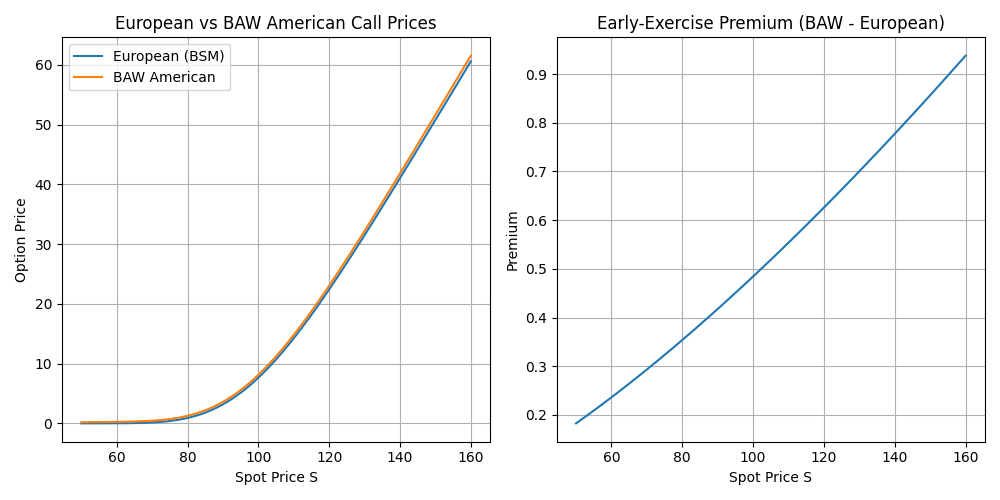

In [338]:
K = 100
r = 0.06
q = 0.03
sigma = 0.25
T = 0.5

S_vals = np.linspace(50, 160, 300)
eur = np.array([bs_call_price(S, K, T, r, q, sigma) for S in S_vals])
baw = np.array([baw_american_call(S, K, T, r, q, sigma) for S in S_vals])
premium = baw - eur

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

#Left panel: European vs American 
ax = axes[0]
ax.plot(S_vals, eur, label="European (BSM)")
ax.plot(S_vals, baw, label="BAW American")
ax.set_title("European vs BAW American Call Prices")
ax.set_xlabel("Spot Price S")
ax.set_ylabel("Option Price")
ax.legend()
ax.grid()

# --- Right panel: Early exercise premium ---
ax = axes[1]
ax.plot(S_vals, premium)
ax.set_title("Early-Exercise Premium (BAW - European)")
ax.set_xlabel("Spot Price S")
ax.set_ylabel("Premium")
ax.grid()
   
plt.tight_layout()
plt.show()


### Put Price Difference between BSM and BAW using Put-Call Parity

$P_{\text{eur}} = C_{\text{eur}} - S e^{-qT} + K e^{-rT}$


In [339]:
# Barone–Adesi-Whaley American Put (continuous q)
def baw_american_put(S, K, T, r, q, sigma):
    if T <= 0 or sigma <= 0:
        return max(K - S, 0.0)

    P_eur = bs_call_price(S, K, T, r, q, sigma) - S * math.exp(-q*T) + K * math.exp(-r*T)

    b = r - q
    a = 0.5 * sigma**2

    # Quadratic root for put (larger positive root)
    disc = (b - 0.5*sigma**2)**2 + 2*r*sigma**2
    p = (-(b - 0.5*sigma**2) + math.sqrt(disc)) / (sigma**2)

    # Smooth-pasting function
    def f(S_bar):
        P_eur_bar = bs_call_price(S_bar, K, T, r, q, sigma) - S_bar * math.exp(-q*T) + K * math.exp(-r*T)
        d1 = (math.log(S_bar/K) + (r - q + 0.5*sigma**2)*T) / (sigma*math.sqrt(T))
        delta_put = math.exp(-q*T) * (norm_cdf(d1) - 1)
        return delta_put + (p / S_bar) * (K - S_bar - P_eur_bar)

    # Solve for S_star using bisection (similar to call)
    lower, upper = 1e-5, K
    for _ in range(100):
        mid = 0.5*(lower + upper)
        if f(lower)*f(mid) < 0:
            upper = mid
        else:
            lower = mid
    S_star = 0.5*(lower + upper)

    P_star = K - S_star
    P_eur_star = bs_call_price(S_star, K, T, r, q, sigma) - S_star * math.exp(-q*T) + K * math.exp(-r*T)
    A_coeff = P_star - P_eur_star

    if S <= S_star:
        return K - S
    else:
        return P_eur + A_coeff * (S_star / S)**p

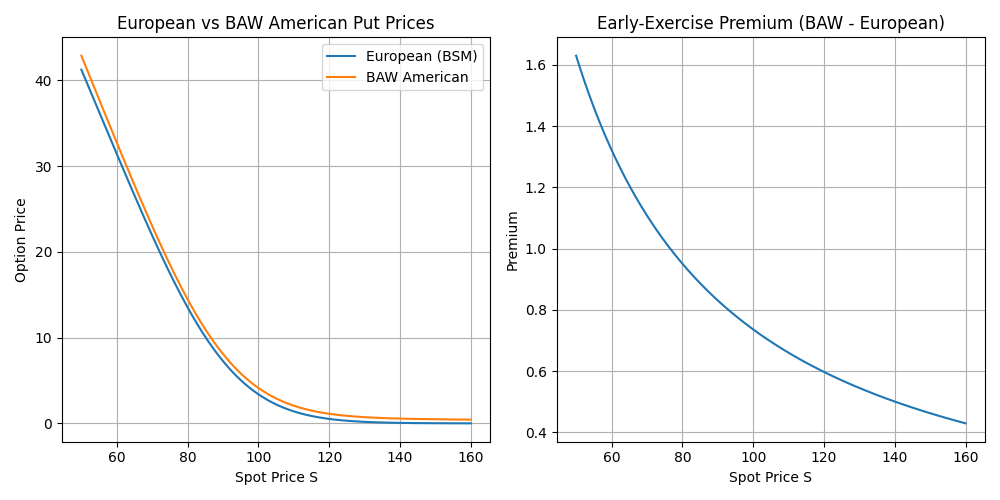

In [340]:
K = 100
r = 0.20
q = 0.03
sigma = 0.25
T = 0.5
S_vals = np.linspace(50, 160, 300)

# use put call parity to get European put
eur = np.array([bs_call_price(S, K, T, r, q, sigma) - S * math.exp(-q*T) + K * math.exp(-r*T) for S in S_vals])
baw = np.array([baw_american_put(S, K, T, r, q, sigma) for S in S_vals])
premium = baw - eur

#  Side-by-side figure
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Left panel: European vs American
ax = axes[0]
ax.plot(S_vals, eur, label="European (BSM)")
ax.plot(S_vals, baw, label="BAW American")
ax.set_title("European vs BAW American Put Prices")
ax.set_xlabel("Spot Price S")
ax.set_ylabel("Option Price")
ax.legend()
ax.grid()

# Right panel: Early-exercise premium
ax = axes[1]
ax.plot(S_vals, premium)
ax.set_title("Early-Exercise Premium (BAW - European)")
ax.set_xlabel("Spot Price S")
ax.set_ylabel("Premium")
ax.grid()

plt.tight_layout()
plt.show()

### Early Exercise Premium Visualization

The plots above demonstrate:
1. **American ≥ European** always (early exercise optionality has value)
2. **Premium increases** for deep ITM puts and dividend-paying calls
3. **Near-zero premium** for OTM options (exercise makes no sense)

### Bjerksund-Stensland 2002 Approximation – American Options

The Bjerksund-Stensland 2002 (BS2002) model is a closed-form approximation for American options. It provides:

- A fast and accurate price for American calls and puts.
- Explicit handling of continuous dividends.
- Avoids slow numerical methods like binomial trees or finite differences.

Key idea:
The model approximates the early exercise boundary with a critical stock price $S^*$ and adds an early exercise premium to the European option price.

More information and solution provided [here](https://github.com/dedwards25/Python_Option_Pricing)

Comparison of schemes [here](https://downloads.dxfeed.com/specifications/dxLibOptions/Numerical-Methods-versus-Bjerksund-and-Stensland-Approximations-for-American-Options-Pricing-.pdf)

---

## Section 3: Bjerksund-Stensland 2002 Model

The **Bjerksund-Stensland 2002** model improves upon BAW with a more accurate approximation for American options. It's faster than binomial trees and more precise than BAW for certain parameter ranges.

### Key Components

1. **Bivariate Normal CDF (`_cbnd`)**: Evaluates joint probabilities for barrier conditions
2. **Helper Functions (`_psi`, `_phi`)**: Intermediate calculations for boundary conditions
3. **Generalized Black-Scholes (`_gbs`)**: Extends BSM for American options with Greeks
4. **Main Approximation (`_bjerksund_stensland_2002`)**: Closed-form American call formula

### Implementation Note

The model uses **put-call transformation**: American put = American call on inverted parameters. This allows a single call pricing function to handle both option types.

In [341]:
# !pip install mvn

In [342]:
from scipy.stats import norm, multivariate_normal
# American Option Intermediate Calculations

# Cumulative Bivariate Normal Distribution
# Primarily called by Psi() function, part of the _Bjerksund_Stensland_2002 model
def _cbnd(a, b, rho):
    """
    Bivariate normal CDF: P(X <= a, Y <= b) with correlation rho.
    Works on Python 3.12+, SciPy 1.12+.
    """
    mean = np.array([0.0, 0.0])
    cov = np.array([
        [1.0,     rho],
        [rho,   1.0]
    ])
    
    mvn = multivariate_normal(mean=mean, cov=cov)
    return mvn.cdf([a, b])

# -----------
# The Psi() function used by _Bjerksund_Stensland_2002 model
def _psi(fs, t2, gamma, h, i2, i1, t1, r, b, v):
    vsqrt_t1 = v * math.sqrt(t1)
    vsqrt_t2 = v * math.sqrt(t2)

    bgamma_t1 = (b + (gamma - 0.5) * (v ** 2)) * t1
    bgamma_t2 = (b + (gamma - 0.5) * (v ** 2)) * t2

    d1 = (math.log(fs / i1) + bgamma_t1) / vsqrt_t1
    d3 = (math.log(fs / i1) - bgamma_t1) / vsqrt_t1

    d2 = (math.log((i2 ** 2) / (fs * i1)) + bgamma_t1) / vsqrt_t1
    d4 = (math.log((i2 ** 2) / (fs * i1)) - bgamma_t1) / vsqrt_t1

    e1 = (math.log(fs / h) + bgamma_t2) / vsqrt_t2
    e2 = (math.log((i2 ** 2) / (fs * h)) + bgamma_t2) / vsqrt_t2
    e3 = (math.log((i1 ** 2) / (fs * h)) + bgamma_t2) / vsqrt_t2
    e4 = (math.log((fs * (i1 ** 2)) / (h * (i2 ** 2))) + bgamma_t2) / vsqrt_t2

    tau = math.sqrt(t1 / t2)
    lambda1 = (-r + gamma * b + 0.5 * gamma * (gamma - 1) * (v ** 2))
    kappa = (2 * b) / (v ** 2) + (2 * gamma - 1)

    psi = math.exp(lambda1 * t2) * (fs ** gamma) * (_cbnd(-d1, -e1, tau)
                                                    - ((i2 / fs) ** kappa) * _cbnd(-d2, -e2, tau)
                                                    - ((i1 / fs) ** kappa) * _cbnd(-d3, -e3, -tau)
                                                    + ((i1 / i2) ** kappa) * _cbnd(-d4, -e4, -tau))
    return psi

# The Phi() function used by _Bjerksund_Stensland_2002 model and the _Bjerksund_Stensland_1993 model
def _phi(fs, t, gamma, h, i, r, b, v):
    d1 = -(math.log(fs / h) + (b + (gamma - 0.5) * (v ** 2)) * t) / (v * math.sqrt(t))
    d2 = d1 - 2 * math.log(i / fs) / (v * math.sqrt(t))

    lambda1 = (-r + gamma * b + 0.5 * gamma * (gamma - 1) * (v ** 2))
    kappa = (2 * b) / (v ** 2) + (2 * gamma - 1)

    phi = math.exp(lambda1 * t) * (fs ** gamma) * (norm.cdf(d1) - ((i / fs) ** kappa) * norm.cdf(d2))
    return phi

# The primary class for calculating Generalized Black Scholes option prices and deltas
# It is not intended to be part of this module's public interface

# Inputs: option_type = "p" or "c", fs = price of underlying, x = strike, t = time to expiration, r = risk free rate
#         b = cost of carry, v = implied volatility
# Outputs: value, delta, gamma, theta, vega, rho
def _gbs(option_type, fs, x, t, r, b, v):
    # -----------
    # Create preliminary calculations
    t__sqrt = math.sqrt(t)
    d1 = (math.log(fs / x) + (b + (v * v) / 2) * t) / (v * t__sqrt)
    d2 = d1 - v * t__sqrt

    if option_type == "c":
        # it's a call
        value = fs * math.exp((b - r) * t) * norm.cdf(d1) - x * math.exp(-r * t) * norm.cdf(d2)
        delta = math.exp((b - r) * t) * norm.cdf(d1)
        gamma = math.exp((b - r) * t) * norm.pdf(d1) / (fs * v * t__sqrt)
        theta = -(fs * v * math.exp((b - r) * t) * norm.pdf(d1)) / (2 * t__sqrt) - (b - r) * fs * math.exp(
            (b - r) * t) * norm.cdf(d1) - r * x * math.exp(-r * t) * norm.cdf(d2)
        vega = math.exp((b - r) * t) * fs * t__sqrt * norm.pdf(d1)
        rho = x * t * math.exp(-r * t) * norm.cdf(d2)
    else:
        # it's a put
        value = x * math.exp(-r * t) * norm.cdf(-d2) - (fs * math.exp((b - r) * t) * norm.cdf(-d1))
        delta = -math.exp((b - r) * t) * norm.cdf(-d1)
        gamma = math.exp((b - r) * t) * norm.pdf(d1) / (fs * v * t__sqrt)
        theta = -(fs * v * math.exp((b - r) * t) * norm.pdf(d1)) / (2 * t__sqrt) + (b - r) * fs * math.exp(
            (b - r) * t) * norm.cdf(-d1) + r * x * math.exp(-r * t) * norm.cdf(-d2)
        vega = math.exp((b - r) * t) * fs * t__sqrt * norm.pdf(d1)
        rho = -x * t * math.exp(-r * t) * norm.cdf(-d2)
    
    return value, delta, gamma, theta, vega, rho    

# American Call Option (Bjerksund Stensland 2002 approximation)
def _bjerksund_stensland_2002(fs, x, t, r, b, v):
    # initialize output
    # using GBS greeks (TO DO: update greek calculations)
    my_output = _gbs("c", fs, x, t, r, b, v)

    e_value = my_output[0]
    delta = my_output[1]
    gamma = my_output[2]
    theta = my_output[3]
    vega = my_output[4]
    rho = my_output[5]

    # Create preliminary calculations
    v2 = v ** 2
    t1 = 0.5 * (math.sqrt(5) - 1) * t
    t2 = t

    beta_inside = ((b / v2 - 0.5) ** 2) + 2 * r / v2
    # forcing the inside of the sqrt to be a positive number
    beta_inside = abs(beta_inside)
    beta = (0.5 - b / v2) + math.sqrt(beta_inside)
    b_infinity = (beta / (beta - 1)) * x
    b_zero = max(x, (r / (r - b)) * x)

    h1 = -(b * t1 + 2 * v * math.sqrt(t1)) * ((x ** 2) / ((b_infinity - b_zero) * b_zero))
    h2 = -(b * t2 + 2 * v * math.sqrt(t2)) * ((x ** 2) / ((b_infinity - b_zero) * b_zero))

    i1 = b_zero + (b_infinity - b_zero) * (1 - math.exp(h1))
    i2 = b_zero + (b_infinity - b_zero) * (1 - math.exp(h2))

    alpha1 = (i1 - x) * (i1 ** (-beta))
    alpha2 = (i2 - x) * (i2 ** (-beta))

    # check for immediate exercise
    if fs >= i2:
        value = fs - x
    else:
        # Perform the main calculation
        value = (alpha2 * (fs ** beta)
                 - alpha2 * _phi(fs, t1, beta, i2, i2, r, b, v)
                 + _phi(fs, t1, 1, i2, i2, r, b, v)
                 - _phi(fs, t1, 1, i1, i2, r, b, v)
                 - x * _phi(fs, t1, 0, i2, i2, r, b, v)
                 + x * _phi(fs, t1, 0, i1, i2, r, b, v)
                 + alpha1 * _phi(fs, t1, beta, i1, i2, r, b, v)
                 - alpha1 * _psi(fs, t2, beta, i1, i2, i1, t1, r, b, v)
                 + _psi(fs, t2, 1, i1, i2, i1, t1, r, b, v)
                 - _psi(fs, t2, 1, x, i2, i1, t1, r, b, v)
                 - x * _psi(fs, t2, 0, i1, i2, i1, t1, r, b, v)
                 + x * _psi(fs, t2, 0, x, i2, i1, t1, r, b, v))

    # in boundary conditions, this approximation can break down
    # Make sure option value is greater than or equal to European value
    value = max(value, e_value)

    # -----------
    # Return Data
    return value, delta, gamma, theta, vega, rho

# Generalized American Option Pricer
# This is a wrapper to check inputs and route to the current "best" American option model
def american_option(option_type, fs, x, t, r, b, v):
    if option_type == "c":
        return _bjerksund_stensland_2002(fs, x, t, r, b, v)
    else:
        # Using the put-call transformation: P(X, FS, T, r, b, V) = C(FS, X, T, -b, r-b, V)
        # WARNING - When reconciling this code back to the B&S paper, the order of variables is different

        put__x = fs
        put_fs = x
        put_b = -b
        put_r = r - b

        # pass updated values into the Call Valuation formula
        return _bjerksund_stensland_2002(put_fs, put__x, t, put_r, put_b, v)

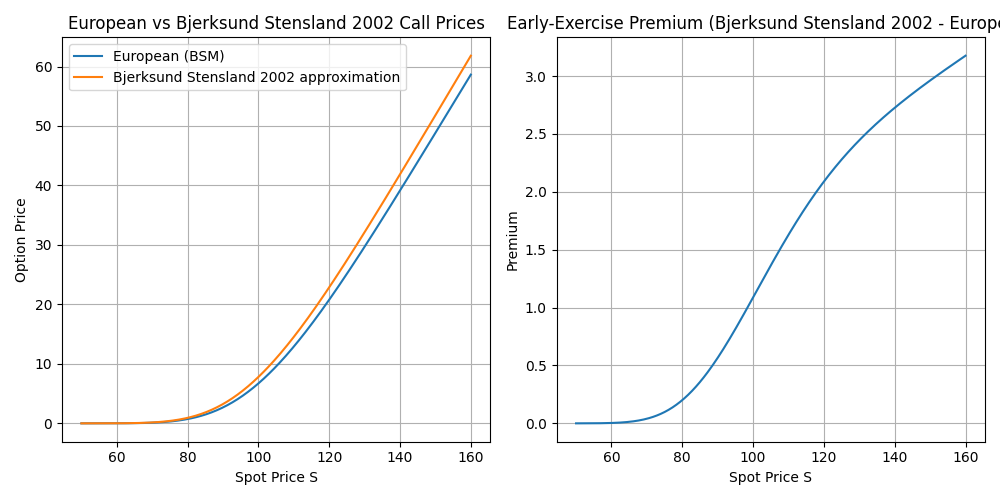

In [343]:
K = 100
r = 0.02
q = 0.03
sigma = 0.25
T = 0.5

S_vals = np.linspace(50, 160, 300)
eur = np.array([bs_call_price(S, K, T, r, q, sigma) for S in S_vals])
bs2002 = np.array([american_option("c", S, K, T, r, q, sigma)[0] for S in S_vals])
premium = bs2002 - eur

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# --- Left panel: European vs American ---
ax = axes[0]
ax.plot(S_vals, eur, label="European (BSM)")
ax.plot(S_vals, bs2002, label="Bjerksund Stensland 2002 approximation")
ax.set_title("European vs Bjerksund Stensland 2002 Call Prices")
ax.set_xlabel("Spot Price S")
ax.set_ylabel("Option Price")
ax.legend()
ax.grid()

# --- Right panel: Early exercise premium ---
ax = axes[1]
ax.plot(S_vals, premium)
ax.set_title("Early-Exercise Premium (Bjerksund Stensland 2002 - European)")
ax.set_xlabel("Spot Price S")
ax.set_ylabel("Premium")
ax.grid()
   
plt.tight_layout()
plt.show()


### Model Comparison: Bjerksund-Stensland vs Barone-Adesi-Whaley

The plots compare:
- **BS2002** (Bjerksund-Stensland 2002): Blue line
- **BAW** (Barone-Adesi-Whaley): Red dashed line
- **EUR** (European BSM): Green dotted line

**Observations:**
- BS2002 typically more accurate than BAW for short-dated options
- Both converge to European value for OTM options
- Premium diverges for ITM options near dividends

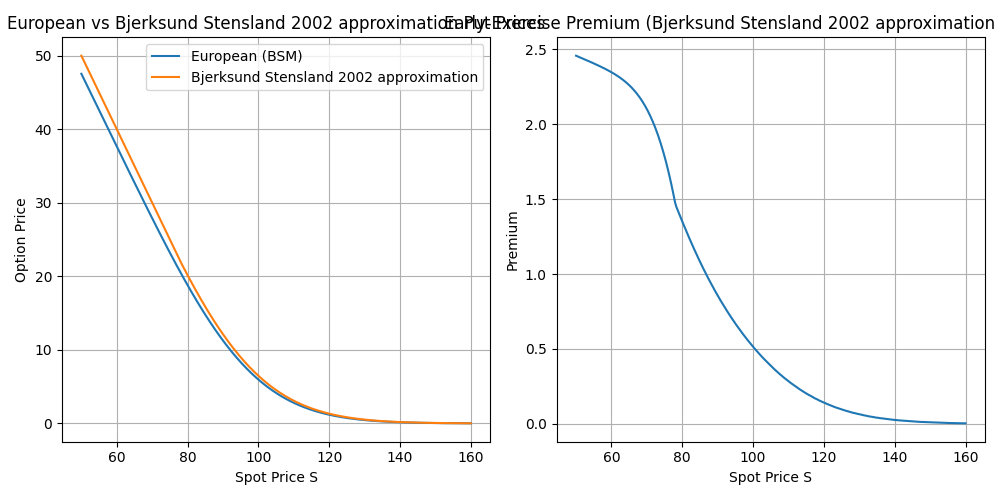

In [344]:
K = 100
r = 0.06
q = 0.02
sigma = 0.25
T = 0.5
S_vals = np.linspace(50, 160, 300)

# use put call parity to get European put
eur = np.array([bs_call_price(S, K, T, r, q, sigma) - S * math.exp(-q*T) + K * math.exp(-r*T) for S in S_vals])
bs2002 = np.array([american_option("p", S, K, T, r, q, sigma)[0] for S in S_vals])
premium = bs2002 - eur

#  Side-by-side figure
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Left panel: European vs American
ax = axes[0]
ax.plot(S_vals, eur, label="European (BSM)")
ax.plot(S_vals, bs2002, label="Bjerksund Stensland 2002 approximation")
ax.set_title("European vs Bjerksund Stensland 2002 approximation Put Prices")
ax.set_xlabel("Spot Price S")
ax.set_ylabel("Option Price")
ax.legend()
ax.grid()

# Right panel: Early-exercise premium
ax = axes[1]
ax.plot(S_vals, premium)
ax.set_title("Early-Exercise Premium (Bjerksund Stensland 2002 approximation - European)")
ax.set_xlabel("Spot Price S")
ax.set_ylabel("Premium")
ax.grid()

plt.tight_layout()
plt.show()

### Why Bjerksund-Stensland 2002 Is Unstable for American Puts

The Bjerksund-Stensland 2002 (BS2002) model was **designed specifically for American calls** on dividend-paying stocks. While it performs well for calls, it systematically **overprices American puts** due to fundamental structural issues.

#### 1. Asymmetric Boundary Structure

BS2002 approximates the early exercise boundary using:

$$S^* = B_0 + (B_\infty - B_0)(1 - e^h)$$

This expression works well for:
- **Call options** where early exercise is beneficial at **high** $S$
- Dividend-paying underlyings

For **puts**, the situation is opposite:
- Early exercise happens at **low** $S$
- The boundary curvature is fundamentally different
- BS2002 simply mirrors the call logic, which is **theoretically incorrect**

#### 2. The Beta Exponent Becomes Unstable

The model uses an exponent $\beta$ that behaves very differently for puts vs. calls:

**For calls:**
$$\beta > 1 \text{ (stable)}$$

**For puts:**
$$\beta < 0 \text{ (often large negative magnitude)}$$

This creates:
- Exploding continuation terms $S^\beta$ for small $S$
- Excessive early-exercise premiums
- **Overpricing** relative to binomial trees, finite differences, or BAW

#### 3. Put Boundary Is Highly Nonlinear

American put early-exercise boundaries have well-documented characteristics:
- **Steep curvature** near the strike
- High sensitivity to volatility
- High sensitivity to interest rates
- Very different shape compared to calls

BS2002 imposes a specific functional form on the boundary that **doesn't match reality for puts**.

**The result:**
- Large overpricing when volatility is moderate or high
- Incorrect early exercise trigger
- Severe distortions when $q > 0$ (dividend yield)

#### 4. Industry Practice

In practice, **BS2002 is used for American CALLS only**. It is not considered reliable for puts.

**For American PUTS, practitioners use:**
- **BAW** (Barone-Adesi-Whaley) — fast approximation
- **Ju-Zhong (2005)** — improved analytical approximation
- **Binomial trees** (Cox-Ross-Rubinstein or Tian) — reliable numerical method
- **Finite difference** (Crank-Nicolson) — PDE-based approach
- **Bunch-Johnson (2000)** — extremely accurate approximation

#### Recommendation

For this tutorial, we demonstrate BS2002 for completeness, but **use BAW or binomial trees for American puts** in practice.

---

## Section 4: Benchmark Performance Testing

Computational efficiency matters for production systems. This section benchmarks:

1. **QuantLib implementations** (CRR binomial, Finite Difference)
2. **Custom NumPy implementations** (optimized vectorization)
3. **Analytical approximations** (BAW, BS2002)

### Timing Decorator

The `@timing` decorator measures execution time for individual function calls, useful for profiling during development.

### Q1d. Answer: The Early Exercise Premium

Simply put, the extra value of an American option over a European one comes from the **ability to exercise early**. Using the BAW method, this value is approximated by a small "premium":

$$
\text{Premium} = A \left(\frac{S}{S^*}\right)^p
$$

where:
- $S^*$ = critical stock price where early exercise becomes optimal
- $p$ = BAW exponent controlling how the premium scales with $S$
- $A$ = difference between the American and European option value at $S^*$

**So, the trader pays this early exercise premium on top of the European option price to account for the optionality of exercising early.**

#### Key Insights:

**For American Calls:**

1. **When $S < S^*$ (not optimal to exercise):**
   $$C_{\text{American}} = C_{\text{European}} + A\left(\frac{S}{S^*}\right)^p$$

2. **When $S \geq S^*$ (optimal to exercise immediately):**
   $$C_{\text{American}} = S - K \text{ (intrinsic value)}$$

3. **For calls on non-dividend stocks:** Premium = 0 (no early exercise value)

4. **For dividend-paying calls:** Premium > 0 when dividend gain exceeds time value

**For American Puts:**

1. **When $S > S^*$ (not optimal to exercise):**
   $$P_{\text{American}} = P_{\text{European}} + A\left(\frac{S^*}{S}\right)^p$$

2. **When $S \leq S^*$ (optimal to exercise immediately):**
   $$P_{\text{American}} = K - S \text{ (intrinsic value)}$$

3. **For puts:** Premium > 0 when interest earned on strike proceeds exceeds time value

4. **Deep ITM puts:** More likely to have early exercise value (collecting $K$ today vs. later)

The BAW model efficiently estimates this premium without solving the full free-boundary PDE, making it practical for real-time pricing.

### Q2. Where are the model differences and should I care? Q2a. If you care, what pricing models can you use?

We've discussed an **Analytical approximations (BAW)** that imposes a functional form on the boundary to avoid the computational costs. This trades off precision for speed, but can achieve an accuracy within 0.1-1% for most practical cases. 

When you should you be more cautious:
1. high interest rates
2. large discrete proportional/cash dividends

You should also be more cautious if 0.1-1% means alot to your business model (market making, pricing ect.).

#### Again, Why Numerical Methods Are Needed

**The free boundary problem has no closed-form solution** because:

1. **Coupled nonlinearity**: The boundary $S^*$ is coupled with option values in the continuation region
2. **Path-dependent optimization**: At each time $t$ and price $S$, compare: exercise value vs. continuation value
3. **Time-varying boundary**: $S^*(\tau)$ changes with time to maturity

**Numerical methods solve this by:**

- **Binomial trees**: Discretize time and stock price, work backwards checking early exercise at each node
- **Finite differences**: Discretize the PDE and apply the early exercise constraint at each grid point
- **Monte Carlo with regression** (<i>Not implemented here!</i>): Estimate continuation values and compare to exercise values.

##### Generic timing wrapper function
We will use this to benchmark the two binomial models

In [345]:
import timeit
from time import time
from functools import wraps
import datetime as dt

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r args:[%r, %r] took: %2.4f sec' % \
          (f.__name__, args, kw, te-ts))
        return result
    return wrap


def benchmark(func, runs=100, **kwargs):
    stmt = "func(**params)"
    globals_dict = {"func": func, "params": kwargs}

    # run the benchmark
    total = timeit.timeit(stmt, number=runs, globals=globals_dict)
    avg = total / runs

    # print results (similar style to your timing() decorator)
    print(
        f"func: {func.__name__} runs: {runs} time: total {total:.4f}s avg: {avg*1e6:.2f}µs"
    )

    return total, avg

### Benchmark Utility

The `benchmark()` function runs multiple iterations to get **stable average timing**. This is essential for comparing methods that may have similar performance.

### Binomial Tree Representation 

This is a Binomial Tree Implementation with Cox-Ross-Rubinstein (CRR) Method = Recombinant trees with equal jump sizes.

Stock tree can be represented using nodes (i,j) and intial stock price $S_0$

$S_{i,j} = S_0u^{j}d^{i-j}$

$C_{i,j}$ represents contract price at each node (i,j). Where $C_{N,j}$ represents final payoff function that we can define.

### American Option Characteristics
For an American Put Option:

if $T = t_N$ then at the terminal nodes, $C^{j}_N = (K-S^{j}_N)^{+}$

for all other parts of the tree at nodes $(i,j)$

- Max of exercise value or continuation/hold value

- $C^{j}_i = \max \Big((K-S^{j}_i)^{+}, \exp^{-r\Delta t} \big\{ q^{j}_i C^{j+1}_{i+1} + (1 - q^{j}_i)C^{j-1}_{i-1}\big\}\Big)$

---

## Section 5: Binomial Tree with Discrete Dividends

### Proportional Dividends vs Cash Dividends

**Proportional Dividend:** Stock drops by percentage $\delta$, so $S_{\text{ex}} = S (1 - \delta)$  
**Cash Dividend:** Stock drops by fixed amount $D$, so $S_{\text{ex}} = \max(S - D, 0)$

### CRR Method with Proportional Dividends

The implementation below handles discrete proportional dividends by:
1. Mapping dividend dates to tree time steps
2. Applying dividend reduction at each node
3. Checking early exercise at every step (American feature)

In [346]:
"""
Binomial Tree Implementation for Cox-Ross-Rubinstein (CRR) Method

Recombinant trees with equal jump sizes.

Key Points
 - For calls on non-dividend-paying stocks, early exercise is never optimal, so American = European price.
 - For puts, early exercise can be optimal if the stock falls enough, so the American put is more valuable than its European counterpart.
"""

def CRR_method_fast_european(K, T, S0, r, N, sigma, opttype="C"):
    """
    Fast European option pricing using the Cox-Ross-Rubinstein method.
    """
    # precompute constants
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1.0 / u
    q = (np.exp(r * dt) - d) / (u - d)
    disc = np.exp(-r * dt)

    # terminal stock prices S_N(j) = S0 * u^j * d^(N-j), j=0..N
    j = np.arange(N + 1, dtype=float)
    S = S0 * (u**j) * (d ** (N - j))

    # terminal payoffs
    if opttype.upper() == "C":
        C = np.maximum(S - K, 0.0)
    else:
        C = np.maximum(K - S, 0.0)

    # backward induction using vectorized slicing
    for i in range(N, 0, -1):
        # risk-neutral expectation on the first i nodes
        C = disc * (q * C[1 : i + 1] + (1.0 - q) * C[0:i])

    return C[0]

def CRR_method_fast_american(K, T, S0, r, N, sigma, opttype="C"):
    """
    Fast American option pricing using the Cox-Ross-Rubinstein method.
    """
    # precompute constants
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1.0 / u
    q = (np.exp(r * dt) - d) / (u - d)
    disc = np.exp(-r * dt)

    # terminal stock prices
    j = np.arange(N + 1, dtype=float)
    S = S0 * (u**j) * (d ** (N - j))

    # terminal payoffs
    if opttype.upper() == "C":
        C = np.maximum(S - K, 0.0)
    else:
        C = np.maximum(K - S, 0.0)

    # backward induction with early exercise
    for i in range(N, 0, -1):
        S = S0 * (u ** np.arange(i)) * (d ** (i - np.arange(i)))
        continuation = disc * (q * C[1 : i + 1] + (1.0 - q) * C[0:i])
        if opttype.upper() == "C":
            exercise = np.maximum(S - K, 0.0)
        else:
            exercise = np.maximum(K - S, 0.0)
        C = np.maximum(continuation, exercise)

    return C[0]

S0 = 100
K = 110
T = 0.5
r = 0.01
N = 100
sigma = 0.3

print("European CRR (C):", CRR_method_fast_european(K, T, S0, r, N, sigma, "C"))
print("American CRR (C):", CRR_method_fast_american(K, T, S0, r, N, sigma, "C"))
print("European CRR (P):", CRR_method_fast_european(K, T, S0, r, N, sigma, "P"))
print("American CRR (P):", CRR_method_fast_american(K, T, S0, r, N, sigma, "P"))


European CRR (C): 4.91440209252178
American CRR (C): 4.91440209252178
European CRR (P): 14.365774803716546
American CRR (P): 15.765240588646678


### Binomial Tree (CRR) with Proportional Dividends

If the time $i\Delta T$ is prior to the ex-dividend date then the nodes remain unchanged.

$S_{i,j} = S_0u^{j}d^{i-j}$

If the time $i\Delta T$ is after the date on which the asset pays the dividend, then the value opf the asset at node (i,j) becomes.

$S_{i,j} = S_0(1 - \delta) u^{j}d^{i-j}$

<img src="proportionaldividend.png" width="400">

<i>source: Implementing Derivatives Models, Les Clewlow & Chris Strickland</i>

In [347]:
def CRR_method_fast_american_dividend(K, T, S0, r, N, sigma, div_times, div_yields, opttype="C"):
    """
    Fast American option pricing with discrete proportional dividends.
    
    Parameters:
    -----------
    K : Strike price
    T : Time to maturity (years)
    S0 : Initial stock price
    r : Risk-free rate
    N : Number of time steps
    sigma : Volatility
    div_times : Times when dividends are paid (in years from now)
    div_yields : Proportional dividend yields (delta). 
    Stock price becomes (1-delta)*S after dividend.
    opttype : 'C' for call, 'P' for put
    """
    # precompute constants
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1.0 / u
    q = (np.exp(r * dt) - d) / (u - d)
    disc = np.exp(-r * dt)
    
    # convert dividend times to time step indices
    div_steps = [int(np.round(t / dt)) for t in div_times]
    div_dict = {step: delta for step, delta in zip(div_steps, div_yields)}
    
    # terminal stock prices (accounting for all dividends up to maturity)
    j = np.arange(N + 1, dtype=float)
    S = S0 * (u**j) * (d ** (N - j))
    
    # apply all dividends that occur by time T
    for step in div_steps:
        if step <= N:
            S *= (1.0 - div_dict[step])
    
    # terminal payoffs
    if opttype.upper() == "C":
        C = np.maximum(S - K, 0.0)
    else:
        C = np.maximum(K - S, 0.0)
    
    # backward induction with early exercise
    for i in range(N, 0, -1):
        # compute stock prices at time step i-1
        j_arr = np.arange(i)
        S = S0 * (u ** j_arr) * (d ** (i - 1 - j_arr))
        
        # apply dividends that have occurred up to step i-1
        for step in div_steps:
            if step < i:
                S *= (1.0 - div_dict[step])
        
        # continuation value
        continuation = disc * (q * C[1 : i + 1] + (1.0 - q) * C[0:i])
        
        # exercise value
        if opttype.upper() == "C":
            exercise = np.maximum(S - K, 0.0)
        else:
            exercise = np.maximum(K - S, 0.0)
        
        C = np.maximum(continuation, exercise)
    
    return C[0]


European equivalent with the proportional dividend. No early exercise condition

In [348]:
def CRR_method_fast_european_dividend(
    K, T, S0, r, N, sigma,
    div_times, div_yields,
    opttype="C"
):
    """
    Fast European option pricing with discrete proportional dividends
    using a CRR binomial tree (no early exercise).

    Parameters:
    -----------
    K : Strike price
    T : Time to maturity (years)
    S0 : Initial stock price
    r : Risk-free rate
    N : Number of time steps
    sigma : Volatility
    div_times : Times when dividends are paid (years)
    div_yields : Proportional dividend yields (delta)
                 Stock becomes (1 - delta) * S at dividend
    opttype : 'C' for call, 'P' for put
    """

    # --- CRR parameters ---
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1.0 / u
    q = (np.exp(r * dt) - d) / (u - d)
    disc = np.exp(-r * dt)

    # --- map dividend times to tree steps ---
    div_steps = [int(np.round(t / dt)) for t in div_times]
    div_dict = dict(zip(div_steps, div_yields))

    # --- terminal stock prices ---
    j = np.arange(N + 1)
    S = S0 * (u ** j) * (d ** (N - j))

    # apply all dividends up to maturity
    for step, delta in div_dict.items():
        if step <= N:
            S *= (1.0 - delta)

    # --- terminal payoff ---
    if opttype.upper() == "C":
        C = np.maximum(S - K, 0.0)
    else:
        C = np.maximum(K - S, 0.0)

    # --- backward induction (EUROPEAN: no early exercise) ---
    for i in range(N, 0, -1):

        # continuation value only
        C = disc * (q * C[1:i+1] + (1.0 - q) * C[0:i])

        # stock prices at time i-1
        j = np.arange(i)
        S = S0 * (u ** j) * (d ** (i - 1 - j))

        # apply dividends already paid
        for step, delta in div_dict.items():
            if step < i:
                S *= (1.0 - delta)

    return C[0]


### European Binomial Tree with Proportional Dividends

Same dividend handling as American version, but **no early exercise check** during backward induction. This allows direct comparison of early exercise premium:

$$
\text{EEP} = V_{\text{American}} - V_{\text{European}}
$$

### Binomial Tree with Cash Dividends

If the time $i\Delta T$ is prior to the ex-dividend date then the nodes remain unchanged.

$S_{i,j} = S_0u^{j}d^{i-j}$

If the time $i\Delta T$ is after the date on which the asset pays the dividend, then the value opf the asset at node (i,j) becomes.

$S_{i,j} = S_0 u^{j}d^{i-j} - D$

<img src="discretedividend.png" width="400">

<i>source: Implementing Derivatives Models, Les Clewlow & Chris Strickland</i>

### CRR Method with Cash Dividends (American)

**Cash dividends** are more realistic for US equities. Key implementation details:

1. **Stock price evolution:** $S(t) = S_0 \cdot u^j \cdot d^{n-j} - \sum_{i} D_i$ for all dividends paid before time $t$
2. **Non-negative constraint:** $S(t) = \max(S_{\text{gross}} - \sum D_i, 0)$
3. **Early exercise:** Compare continuation value vs intrinsic value at each node

This is the **primary pricing engine** for AAPL options analysis in later sections.

In [349]:
def CRR_method_fast_american_cash_dividend(K, T, S0, r, N, sigma, div_times, div_amounts, opttype="C"):
    """
    Fast American option pricing with discrete cash dividends.
    
    Parameters:
    -----------
    K : Strike price
    T : Time to maturity (years)
    S0 : Initial stock price
    r : Risk-free rate
    N : Number of time steps
    sigma : Volatility
    div_times : Times when dividends are paid (in years from now)
    div_amounts : Cash dividend amounts (D). Stock price becomes S - D after dividend.
    opttype : 'C' for call, 'P' for put
    
    Returns:
    --------
    float : Option price
    
    Note:
    -----
    Stock price evolution: S * exp(xu) * exp(xd) - sum(D_i) for dividends paid before time t
    """
    # precompute constants
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1.0 / u
    q = (np.exp(r * dt) - d) / (u - d)
    disc = np.exp(-r * dt)
    
    # convert dividend times to time step indices
    div_steps = [int(np.round(t / dt)) for t in div_times]
    div_dict = {step: amount for step, amount in zip(div_steps, div_amounts)}
    
    # terminal stock prices (accounting for all cash dividends up to maturity)
    j = np.arange(N + 1, dtype=float)
    S = S0 * (u**j) * (d ** (N - j))
    
    # subtract all cash dividends that occur by time T
    total_div = sum(div_dict[step] for step in div_steps if step <= N)
    S = np.maximum(S - total_div, 0.0)  # stock price can't go negative
    
    # terminal payoffs
    if opttype.upper() == "C":
        C = np.maximum(S - K, 0.0)
    else:
        C = np.maximum(K - S, 0.0)
    
    # backward induction with early exercise
    for i in range(N, 0, -1):
        # compute stock prices at time step i-1 before any dividend adjustment
        j_arr = np.arange(i)
        S = S0 * (u ** j_arr) * (d ** (i - 1 - j_arr))
        
        # subtract cash dividends that have occurred up to step i-1
        cum_div = sum(div_dict[step] for step in div_steps if step < i)
        S = np.maximum(S - cum_div, 0.0)
        
        # continuation value
        continuation = disc * (q * C[1 : i + 1] + (1.0 - q) * C[0:i])
        
        # exercise value
        if opttype.upper() == "C":
            exercise = np.maximum(S - K, 0.0)
        else:
            exercise = np.maximum(K - S, 0.0)
        
        C = np.maximum(continuation, exercise)
    
    return C[0]

European equivalent with the cash dividend. No early exercise condition

In [350]:
def CRR_method_fast_european_cash_dividend(
    K, T, S0, r, N, sigma,
    div_times, div_amounts,
    opttype="C"
):
    """
    Fast European option pricing with discrete cash dividends
    using a CRR binomial tree (no early exercise).

    Parameters:
    -----------
    K : Strike price
    T : Time to maturity (years)
    S0 : Initial stock price
    r : Risk-free rate
    N : Number of time steps
    sigma : Volatility
    div_times : Times when dividends are paid (years)
    div_amounts : Cash dividend amounts D
                  Stock becomes max(S - D, 0) at dividend
    opttype : 'C' or 'P'
    """

    # --- CRR parameters ---
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1.0 / u
    q = (np.exp(r * dt) - d) / (u - d)
    disc = np.exp(-r * dt)

    # --- map dividend times to tree steps ---
    div_steps = [int(np.round(t / dt)) for t in div_times]
    div_dict = dict(zip(div_steps, div_amounts))

    # --- terminal stock prices ---
    j = np.arange(N + 1)
    S = S0 * (u ** j) * (d ** (N - j))

    # subtract all dividends paid by maturity
    total_div = sum(amount for step, amount in div_dict.items() if step <= N)
    S = np.maximum(S - total_div, 0.0)

    # --- terminal payoff ---
    if opttype.upper() == "C":
        V = np.maximum(S - K, 0.0)
    else:
        V = np.maximum(K - S, 0.0)

    # --- backward induction (EUROPEAN) ---
    for i in range(N, 0, -1):

        # continuation only
        V = disc * (q * V[1:i+1] + (1.0 - q) * V[0:i])

        # stock prices at time i-1
        j = np.arange(i)
        S = S0 * (u ** j) * (d ** (i - 1 - j))

        # subtract dividends already paid
        cum_div = sum(amount for step, amount in div_dict.items() if step < i)
        S = np.maximum(S - cum_div, 0.0)

    return V[0]


### European Binomial Tree with Cash Dividends

European equivalent with **no early exercise**. Used for calculating Early Exercise Premium (EEP) by comparing against American prices.

## Finite Difference Method with Discrete Dividends

Finite difference methods solve the PDE directly by discretizing the spatial (stock price) and temporal domains. For American options with discrete dividends, we need to handle the dividend payment as a jump condition in the stock price.

**Key advantages:**
- Different numerical approach validates binomial results
- Can be more efficient for certain problems
- Natural framework for PDEs

**Handling discrete dividends:**
- Before dividend: normal PDE evolution
- At dividend time: adjust stock price grid by subtracting dividend
- Continue with adjusted prices

---

## Section 6: QuantLib Integration

**QuantLib** is an open-source library for quantitative finance. It provides:
- Industry-standard pricing engines (CRR, Finite Difference, Monte Carlo)
- Comprehensive date/calendar handling
- Term structure modeling

### Date Conversion Utilities

QuantLib uses its own date format. These helpers convert between Python `datetime.date` and QuantLib dates.

In [351]:
# !pip install py_vollib
# !pip install QuantLib

In [352]:
import QuantLib as ql
import numpy as np
import datetime as dt
import datetime

def py_to_ql(dt):
    """Convert Python datetime.date to QuantLib Date"""
    if isinstance(dt, datetime.datetime):
        dt = dt.date()
    return ql.Date(dt.day, dt.month, dt.year)

### Define Quantlib Finite Differences function

In [353]:
def price_american_option_fd(
    S0: float,
    K: float,
    r: float,
    sigma: float,
    today: dt.date,
    expiration: dt.date,
    option_type: str ="put",
    tGrid: int = 100,
    xGrid: int = 100,
    discrete_divs: dict[dt.date, float] = None,        
    proportional_divs: dict[dt.date, float] = None,    
):
    """
    American option finite-difference pricing (FdBlackScholesVanillaEngine)
    with support for:
        - Discrete dividends (via FixedDividend schedule) # dict: {python_date: amount}
        - Proportional dividends (spot-adjustment method) # dict: {python_date: rate}
    """
    today_dt = py_to_ql(today)
    expiration_dt = py_to_ql(expiration)
    
    # Settings
    ql.Settings.instance().evaluationDate = today_dt
    daycount = ql.Actual365Fixed()
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)

    # Option type
    ql_type = ql.Option.Put if option_type.lower() == "put" else ql.Option.Call

    payoff = ql.PlainVanillaPayoff(ql_type, K)
    exercise = ql.AmericanExercise(today_dt, expiration_dt)
    option = ql.VanillaOption(payoff, exercise)

    # Term structures
    flat_rf = ql.YieldTermStructureHandle(ql.FlatForward(today_dt, r, daycount))
    flat_div_yield = ql.YieldTermStructureHandle(ql.FlatForward(today_dt, 0.0, daycount))
    vol_ts = ql.BlackVolTermStructureHandle(
        ql.BlackConstantVol(today_dt, calendar, sigma, daycount)
    )

    # Finite difference engine supports only *discrete cash dividends* directly.
    # Proportional dividends require spot adjustment.
    adjusted_S0 = S0

    # 1. Build DividendSchedule for discrete dividends
    dividend_schedule = []
    if discrete_divs is not None:
        for py_date, amount in discrete_divs.items():
            ql_date = py_to_ql(py_date)
            dividend_schedule.append(ql.FixedDividend(amount, ql_date))

    # 2. Proportional dividends handled via spot adjustment
    if proportional_divs is not None:
        for py_date, rate in proportional_divs.items():
            ql_date = py_to_ql(py_date)
            tau = (ql_date - today_dt) / 365.0
            adjusted_S0 -= (S0 * rate) * np.exp(-r * tau)

    # Black-Scholes process with adjusted spot
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(adjusted_S0))
    process = ql.BlackScholesMertonProcess(
        spot_handle, flat_div_yield, flat_rf, vol_ts
    )

    # Finite Difference Engine 
    engine = ql.FdBlackScholesVanillaEngine(
        process,
        dividend_schedule,
        tGrid,
        xGrid
    )

    option.setPricingEngine(engine)

    return option.NPV()

### Finite Difference Pricing with Dividends

**Finite Difference Method (FDM)** solves the Black-Scholes PDE numerically using a grid:

**PDE:** 
$$
\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + rS\frac{\partial V}{\partial S} - rV = 0
$$

**Advantages:**
- Handles American early exercise naturally
- Supports discrete cash dividends directly
- More stable than trees for certain Greeks

**Parameters:**
- `tGrid`: Time steps (more = better accuracy)
- `xGrid`: Stock price grid points (more = smoother)

**Dividend Handling:**
- Cash dividends: Use `FixedDividend` schedule
- Proportional: Adjust spot via present value

### Define Quantlib Binomial Tree (CRR) function

In [354]:
def price_american_option_crr(
    S0: float,
    K: float,
    r: float,
    sigma: float,
    expiration: dt.date,
    today: dt.date,
    option_type: str = "put",
    steps: int = 100,
    discrete_divs: dict[dt.date, float] = None,       # dict: {python_date: amount}
    proportional_divs: dict[dt.date, float] = None    # dict: {python_date: rate}
):
    """
    Price an American option using a CRR tree with support for:
    - discrete dividends given as {date: amount}
    - proportional dividends given as {date: rate}
    """
    # --- Setup ---
    today_dt = py_to_ql(today)
    expiration_dt = py_to_ql(expiration)
    ql.Settings.instance().evaluationDate = today_dt
    daycount = ql.Actual365Fixed()
    calendar = ql.UnitedStates(ql.UnitedStates.NYSE)
    # calendar_adjusted = calendar.adjust(today_dt, ql.Following)

    # Option type
    ql_type = ql.Option.Put if option_type.lower() == "put" else ql.Option.Call

    payoff = ql.PlainVanillaPayoff(ql_type, K)
    exercise = ql.AmericanExercise(today_dt, expiration_dt)
    option = ql.VanillaOption(payoff, exercise)

    # Term structures
    flat_rf = ql.YieldTermStructureHandle(ql.FlatForward(today_dt, r, daycount))
    flat_div_yield = ql.YieldTermStructureHandle(ql.FlatForward(today_dt, 0.0, daycount))
    vol_ts = ql.BlackVolTermStructureHandle(
        ql.BlackConstantVol(today_dt, calendar, sigma, daycount)
    )

    # --- Spot adjustment section ---
    adjusted_spot = S0

    # 1. Discrete cash dividends: {py_date: amount}
    if discrete_divs is not None:
        for py_date, amount in discrete_divs.items():
            ql_date = py_to_ql(py_date)
            t = (ql_date - today_dt) / 365.0
            adjusted_spot -= amount * np.exp(-r * t)

    # 2. Proportional dividends: {py_date: rate}
    if proportional_divs is not None:
        for py_date, rate in proportional_divs.items():
            ql_date = py_to_ql(py_date)
            t = (ql_date - today_dt) / 365.0
            adjusted_spot -= (S0 * rate) * np.exp(-r * t)

    # --- Build process ---
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(adjusted_spot))
    process = ql.BlackScholesMertonProcess(spot_handle, flat_div_yield, flat_rf, vol_ts)

    # --- Binomial pricing ---
    engine = ql.BinomialVanillaEngine(process, "crr", steps)
    option.setPricingEngine(engine)

    return option.NPV()

### CRR Binomial Pricing via QuantLib

QuantLib's `BinomialVanillaEngine` with "crr" method:

**Dividend Adjustment:**
- Dividends handled via **spot adjustment**: $S_{\text{adj}} = S_0 - \text{PV}(\text{dividends})$
- PV calculated using risk-free discounting: $\text{PV}(D_i) = D_i \cdot e^{-r \cdot t_i}$

This approach is **equivalent to the escrowed dividend method** used in industry practice.

#### Testing discrete dividend functions

In [355]:
import datetime as dt

discrete = {
    dt.date(2025, 9, 1): 2.0
}

price = price_american_option_crr(
    S0=S0, K=K, r=r, sigma=sigma,
    today=dt.date(2025, 6, 1),
    expiration=dt.date(2025, 12, 1),
    discrete_divs=discrete
)

pricefd = price_american_option_fd(
    S0=S0, K=K, r=r, sigma=sigma,
    today=dt.date(2025, 6, 1),
    expiration=dt.date(2025, 12, 1),
    discrete_divs=discrete
)

price, pricefd

(15.742010125540157, 15.803810013664412)

---

## Section 7: Dividend Handling Utilities

### Discrete Dividend Data Structure

Dividends stored as dictionary: `{datetime.date: float}` where:
- **Key:** Ex-dividend date (Python `datetime.date` object)
- **Value:** Cash dividend amount in dollars

Example for AAPL:
```python
discrete = {
    dt.date(2024, 11, 8): 0.25,   # $0.25 dividend on Nov 8, 2024
    dt.date(2025, 2, 7): 0.25,    # $0.25 dividend on Feb 7, 2025
}
```

#### Testing proportional dividend functions

In [356]:
proportional = {
    dt.date(2025, 9, 1): 0.02   # 3%
}

price = price_american_option_crr(
    S0=S0, K=K, r=r, sigma=sigma,
    today=dt.date(2025, 6, 1),
    expiration=dt.date(2025, 12, 1),
    proportional_divs=proportional
)

pricefd = price_american_option_fd(
    S0=S0, K=K, r=r, sigma=sigma,
    today=dt.date(2025, 6, 1),
    expiration=dt.date(2025, 12, 1),
    proportional_divs=proportional
)

price, pricefd

(15.742010125540157, 15.727599362096521)

### Filter Dividends by Date Range

Only dividends **between trade date and expiration** affect option pricing. This function filters the dividend dictionary accordingly.

**Logic:** Include dividend if `trade_date < ex_date ≤ expiry_date`

#### Comparing speed between methods

In [51]:
total, avg = benchmark(CRR_method_fast_american_cash_dividend,runs=100_000,
                       S0=100, K=105, r=0.03, sigma=0.25, T=0.5, N=100,
                       div_times=[0.25], div_amounts=[2])

total, avg = benchmark(price_american_option_crr, runs=100_000,
                       S0=100, K=105, r=0.03, sigma=0.25,
                       expiration=dt.date(2025, 12, 1), today=dt.date(2025, 6, 1), 
                       discrete_divs=discrete)

total, avg = benchmark(price_american_option_fd, runs=100_000,
                       S0=100, K=105, r=0.03, sigma=0.25,
                       expiration=dt.date(2025, 12, 1), today=dt.date(2025, 6, 1), 
                       discrete_divs=discrete)

func: CRR_method_fast_american_cash_dividend runs: 100000 time: total 57.5986s avg: 575.99µs
func: price_american_option_crr runs: 100000 time: total 5.7847s avg: 57.85µs
func: price_american_option_fd runs: 100000 time: total 32.0940s avg: 320.94µs


### Present Value of Dividends

Calculate the total present value of discrete dividends:

$$
\text{PV}(\text{divs}) = \sum_{i} D_i \cdot e^{-r \cdot t_i}
$$

Where:
- $D_i$ = dividend amount
- $t_i$ = time to ex-dividend date (in years)
- $r$ = risk-free rate

**Usage:** Subtract PV(divs) from spot to get **dividend-adjusted forward price**.

### Q2. Answer. The difference between approximation schemes vs using numerical techniques is precision/accuracy vs computation speed. 

### Q2a. Answer. If you don't mind 0.1-1% deviation in prices, BAW approximation of early expiration premium will work fine. If this pricing is critical to your business model, then Binomial/Trinomial trees and Finite Difference schemes are the way to go. Between the two there are some complex tradeoffs between accuracy and speed that we won't get into.


### Key Insights: Finite Difference vs Binomial

**How Finite Difference Handles Dividends:**

1. **Jump Condition**: At dividend payment time, we apply a discontinuity to the stock price grid
   - **Cash dividend**: $S \rightarrow S - D$ (subtract fixed amount)
   - **Proportional dividend**: $S \rightarrow S(1-\delta)$ (scale by factor)

2. **Interpolation**: After the jump, we interpolate option values from the old grid to the new (adjusted) grid

3. **PDE Evolution**: Between dividends, we solve the Black-Scholes PDE using implicit finite differences

**Comparison Summary:**

| Method | Pros | Cons |
|--------|------|------|
| **Binomial** | • Simple to implement<br>• Natural for discrete dividends<br>• Intuitive tree structure<br>• Fast computation | • Can be slow for high accuracy<br>• Convergence can oscillate |
| **Finite Difference** | • Very accurate<br>• Handles dividends naturally<br>• Direct PDE solution | • Slower computation<br>• More complex implementation<br>• Requires careful boundary conditions |
| **QuantLib** | • Well-tested<br>• Industry standard<br>• Many features | • Black box<br>• Dividend handling via spot adjustment |

All three methods converge to the same answer, validating the implementations!

---

## Section 8: AAPL Market Data Loading

### Databento Format

Databento provides institutional-grade historical options data with:
- Tick-by-tick quotes (bid/ask with sizes)
- Underlying spot price
- Expiration and strike information
- Nanosecond timestamps

### Data Processing Steps

1. Load Parquet file with pandas
2. Convert timestamps to pandas datetime
3. Filter by trade date
4. Extract underlying spot price
5. Prepare dividend dictionary

### Q3. How can I calculated Implied Volatility based on this pricing model?



In [357]:
import os
import databento as db
from dotenv import load_dotenv

load_dotenv()

api_key = os.getenv("DATABENTO_KEY")

trade_day = "2025-09-22" 
start_time = "09:30:00" 
end_time = "09:31:00" 
data_type = "cbbo-1s"  # cbbo-1m / cbbo-1s / cmbp-1


In [251]:
client = db.Historical(api_key)

subscription_args = {
    "dataset": "OPRA.PILLAR",
    "schema": "definition",
    "symbols": "AAPL.OPT",
    "stype_in": "parent",
    "start": trade_day,
}

data = client.timeseries.get_range(
    **subscription_args
)
df_instruments = data.to_df()

In [252]:
df_instruments.to_csv('contract_specification.csv', index=False)
df_instruments.columns

Index(['ts_event', 'rtype', 'publisher_id', 'instrument_id', 'raw_symbol',
       'security_update_action', 'instrument_class', 'min_price_increment',
       'display_factor', 'expiration', 'activation', 'high_limit_price',
       'low_limit_price', 'max_price_variation', 'trading_reference_price',
       'unit_of_measure_qty', 'min_price_increment_amount', 'price_ratio',
       'inst_attrib_value', 'underlying_id', 'raw_instrument_id',
       'market_depth_implied', 'market_depth', 'market_segment_id',
       'max_trade_vol', 'min_lot_size', 'min_lot_size_block',
       'min_lot_size_round_lot', 'min_trade_vol', 'contract_multiplier',
       'decay_quantity', 'original_contract_size', 'trading_reference_date',
       'appl_id', 'maturity_year', 'decay_start_date', 'channel_id',
       'currency', 'settl_currency', 'secsubtype', 'group', 'exchange',
       'asset', 'cfi', 'security_type', 'unit_of_measure', 'underlying',
       'strike_price_currency', 'strike_price', 'match_algorithm'

In [253]:
essential_cols = [
    'instrument_id', 
    'raw_symbol',
    'underlying',
    'instrument_class', 
    'expiration', 
    'strike_price' ]

In [254]:
df_instruments = df_instruments[essential_cols]
df_instruments['expiration'] = df_instruments['expiration'].dt.date
df_instruments

,instrument_id,raw_symbol,underlying,instrument_class,expiration,strike_price
ts_recv,,,,,,
2025-09-22 10:30:00.494454868+00:00,16777220,AAPL 251219C00095000,AAPL,C,2025-12-19,95.0
2025-09-22 10:30:00.505646616+00:00,16777221,AAPL 251219P00250000,AAPL,P,2025-12-19,250.0
2025-09-22 10:30:00.505656647+00:00,16777222,AAPL 251219P00115000,AAPL,P,2025-12-19,115.0
2025-09-22 10:30:00.507967002+00:00,16777223,AAPL 251219P00160000,AAPL,P,2025-12-19,160.0
2025-09-22 10:30:00.507988034+00:00,16777224,AAPL 251219P00100000,AAPL,P,2025-12-19,100.0
...,...,...,...,...,...,...
2025-09-22 12:00:03.205064455+00:00,16794473,AAPL 251017C00252500,AAPL,C,2025-10-17,252.5
2025-09-22 12:00:03.205064455+00:00,16794467,AAPL 251017P00262500,AAPL,P,2025-10-17,262.5
2025-09-22 12:00:03.205914771+00:00,16794650,AAPL 251017P00227500,AAPL,P,2025-10-17,227.5


In [255]:
print(f'Calls {len(df_instruments[df_instruments.instrument_class == 'C'])}')
print(f'Puts {len(df_instruments[df_instruments.instrument_class == 'P'])}')
print(f'Underlying {len(df_instruments[df_instruments.instrument_class == 'K'])}')

Calls 1140
Puts 1140
Underlying 0


In [59]:
df_instruments.to_csv("aapl_df_instruments.csv")

### Get data snapshots of consolidated best bid and offers at 1s intervals for first minute of trading day

In [60]:
subscription_args = {
    "dataset": "OPRA.PILLAR",
    "schema": "cbbo-1s",
    "symbols": "AAPL.OPT",
    "stype_in": "parent",
    "start": f"{trade_day}T{start_time}-04:00",
    "end": f"{trade_day}T{end_time}-04:00",
}

# Download historical data
data = client.timeseries.get_range(**subscription_args)

# Convert to DataFrame
df = data.to_df()

df.head()

,ts_event,rtype,publisher_id,instrument_id,side,price,size,flags,bid_px_00,ask_px_00,bid_sz_00,ask_sz_00,bid_pb_00,ask_pb_00,symbol
ts_recv,,,,,,,,,,,,,,,
2025-09-22 13:30:01+00:00,NaT,192,30,16788777,N,NaN,0,192,9.20,17.75,2,2,25,25,AAPL 271217P00200000
2025-09-22 13:30:01+00:00,NaT,192,30,16777462,N,NaN,0,192,27.45,31.65,1,1,25,33,AAPL 251017C00220000
2025-09-22 13:30:01+00:00,NaT,192,30,16778512,N,NaN,0,192,0.10,0.25,1,1,25,25,AAPL 251031C00300000
2025-09-22 13:30:01+00:00,NaT,192,30,16777374,N,NaN,0,192,1.57,1.79,14,1,33,25,AAPL 270115P00135000
2025-09-22 13:30:01+00:00,NaT,192,30,16788626,N,NaN,0,192,84.65,87.40,1,1,33,33,AAPL 270617C00180000


In [61]:
df.to_csv("aapl_options_cbbo_1s.csv")

### Now we need underlying

In [62]:
sub_underlying = {
    "dataset": "XNAS.BASIC",       # NASDAQ UTP NBBO
    "schema": "cbbo-1s",          # 1-second best bid/offer
    "symbols": "AAPL",
    "stype_in": "raw_symbol",
    "start": f"{trade_day}T{start_time}-04:00",
    "end": f"{trade_day}T{end_time}-04:00",
}

data_underlying = client.timeseries.get_range(**sub_underlying)

df_underlying = data_underlying.to_df()

df_underlying.head()

,ts_event,rtype,publisher_id,instrument_id,side,price,size,flags,bid_px_00,ask_px_00,bid_sz_00,ask_sz_00,bid_pb_00,ask_pb_00,symbol
ts_recv,,,,,,,,,,,,,,,
2025-09-22 13:30:00+00:00,2025-09-22 13:29:59.400908850+00:00,192,93,38,N,248.300,300,128,248.30,248.31,100,25,81,81,AAPL
2025-09-22 13:30:01+00:00,2025-09-22 13:30:00.952562830+00:00,192,93,38,N,248.292,1,128,248.19,248.28,72,50,81,81,AAPL
2025-09-22 13:30:02+00:00,2025-09-22 13:30:01.995015174+00:00,192,93,38,N,248.440,1,128,248.42,248.50,1220,511,81,81,AAPL
2025-09-22 13:30:03+00:00,2025-09-22 13:30:02.999328398+00:00,192,93,38,N,248.170,1,128,248.74,248.83,420,300,81,81,AAPL
2025-09-22 13:30:04+00:00,2025-09-22 13:30:03.999530048+00:00,192,93,38,N,248.170,1,128,248.63,248.70,1540,306,81,81,AAPL


In [63]:
df_underlying.to_csv("aapl_underlying_cbbo_1s.csv")

### Load CSV and Prepare for Replay

In [440]:
import pandas as pd
df_defs = pd.read_csv("aapl_df_instruments.csv", parse_dates=["ts_recv"])
df_opts = pd.read_csv("aapl_options_cbbo_1s.csv", parse_dates=["ts_recv"])
df_und  = pd.read_csv("aapl_underlying_cbbo_1s.csv", parse_dates=["ts_recv"])

df_opts  = df_opts.sort_values("ts_recv").reset_index(drop=True)
df_und   = df_und.sort_values("ts_recv").reset_index(drop=True)

Build Symbol attribute map

### Time to Expiration

Calculate $T$ in years using Actual/365.25 day count convention (common in equity options).

In [441]:
attr_df = (
    df_defs[["instrument_id", "underlying", "expiration", "instrument_class", "strike_price"]]
    .copy()
)
attr_df

,instrument_id,underlying,expiration,instrument_class,strike_price
0,16777220,AAPL,2025-12-19,C,95.0
1,16777221,AAPL,2025-12-19,P,250.0
2,16777222,AAPL,2025-12-19,P,115.0
3,16777223,AAPL,2025-12-19,P,160.0
4,16777224,AAPL,2025-12-19,P,100.0
...,...,...,...,...,...
2275,16794473,AAPL,2025-10-17,C,252.5
2276,16794467,AAPL,2025-10-17,P,262.5
2277,16794650,AAPL,2025-10-17,P,227.5
2278,16794654,AAPL,2025-10-17,C,242.5


### Pre-merge Underlying Before Replay

#### Step 1: Collapse underlying to a single row per second

### Implied Volatility Calculation

Use `py_vollib_vectorized` for fast Black-Scholes implied volatility:

**Input:** Market prices (bid, mid, ask)  
**Output:** Corresponding implied volatilities

**Note:** This uses European BSM formula, which may underestimate American option value.

In [442]:
df_und_sec = (
    df_und
    .groupby("ts_recv")
    .agg({
        "bid_px_00": "last",
        "ask_px_00": "last",
    })
    .assign(underlying_mid=lambda x: (x.bid_px_00 + x.ask_px_00) / 2)
)
df_und_sec

df_opts = df_opts.assign(
    opt_mid=lambda x: (x["bid_px_00"] + x["ask_px_00"]) / 2
)

### Step 2: Floor option timestamps + merge

flooring the timestamps of the underlying price data is to prevent look-ahead bias when merging with the option ticks during replay. 

In [443]:
# merge underlying prices 
df_merged = df_opts.merge(df_und_sec[["underlying_mid"]], on="ts_recv", how="left")
# merge contract attributes from definitions 
df_merged = df_merged.merge(attr_df, on="instrument_id", how="left")

# Convert everything to UTC tz-aware
df_merged["ts_recv"] = pd.to_datetime(df_merged["ts_recv"], utc=True)
df_merged["expiration"] = pd.to_datetime(df_merged["expiration"], utc=True)

df_merged.head()

,ts_recv,ts_event,rtype,publisher_id,instrument_id,side,price,size,flags,bid_px_00,...,ask_sz_00,bid_pb_00,ask_pb_00,symbol,opt_mid,underlying_mid,underlying,expiration,instrument_class,strike_price
0,2025-09-22 13:30:01+00:00,NaN,192,30,16788777,N,NaN,0,192,9.20,...,2,25,25,AAPL 271217P00200000,13.475,248.235,AAPL,2027-12-17 00:00:00+00:00,P,200.0
1,2025-09-22 13:30:01+00:00,NaN,192,30,33560938,N,NaN,0,192,6.95,...,1,25,25,AAPL 260618P00215000,7.600,248.235,AAPL,2026-06-18 00:00:00+00:00,P,215.0
2,2025-09-22 13:30:01+00:00,NaN,192,30,33558134,N,NaN,0,192,36.60,...,1,25,25,AAPL 260220P00285000,37.875,248.235,AAPL,2026-02-20 00:00:00+00:00,P,285.0
3,2025-09-22 13:30:01+00:00,NaN,192,30,33558878,N,NaN,0,192,180.20,...,1,25,25,AAPL 261218C00070000,181.475,248.235,AAPL,2026-12-18 00:00:00+00:00,C,70.0
4,2025-09-22 13:30:01+00:00,NaN,192,30,33556724,N,NaN,0,192,0.09,...,4,33,31,AAPL 260618P00090000,0.160,248.235,AAPL,2026-06-18 00:00:00+00:00,P,90.0


### Build a Replay Engine (1-second tick replay)

In [444]:
import time

class DataReplayNewDataOnly:
    def __init__(self, df, timestamp_col="ts_recv", realtime=True):
        """
        df            : historical DataFrame sorted by timestamp
        timestamp_col : the column to replay on
        realtime      : if True, waits 1s between frames
        """
        self.df = df.copy()
        self.timestamp_col = timestamp_col
        self.realtime = realtime
        
        # Ensure proper datetime dtype
        self.df[timestamp_col] = pd.to_datetime(self.df[timestamp_col])
        
        # Group by second
        self.groups = list(self.df.groupby(self.df[timestamp_col].dt.floor("1s")))
        self.idx = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self.idx >= len(self.groups):
            raise StopIteration
        
        ts, rows = self.groups[self.idx]
        self.idx += 1
        
        if self.realtime:
            time.sleep(1)
        
        return ts, rows


In [445]:
import time
import pandas as pd

class DataReplay:
    def __init__(self, df, timestamp_col="ts_recv", realtime=True):
        """
        df : historical DataFrame sorted by timestamp (only includes changes)
        timestamp_col : field to group by (nanosecond or microsecond timestamps)
        realtime : if True, waits 1 second between frames during replay
        """
        self.df = df.copy()
        self.timestamp_col = timestamp_col
        self.realtime = realtime
        
        # Ensure datetime format
        self.df[timestamp_col] = pd.to_datetime(self.df[timestamp_col])

        # Group updates by second
        self.groups = list(self.df.groupby(self.df[timestamp_col].dt.floor("1s")))
        self.idx = 0

        # Instrument state: {instrument_id: last_row_df}
        self.state = {}

    def __iter__(self):
        return self

    def __next__(self):
        if self.idx >= len(self.groups):
            raise StopIteration

        ts, rows = self.groups[self.idx]
        self.idx += 1
        
        # 1. Update state for all instrument_ids in this slice
        for _, row in rows.iterrows():
            inst = row["instrument_id"]
            self.state[inst] = row  # store full row as latest snapshot

        # 2. Build a combined DataFrame of all latest known rows
        snapshot_df = pd.DataFrame(self.state.values()).copy()

        # 3. Respect realtime delay
        if self.realtime:
            time.sleep(1)

        # Return timestamp + full snapshot
        return ts, snapshot_df


In [446]:
replay = DataReplay(df_merged, timestamp_col="ts_recv", realtime=True)

for ts, df in replay:
    print(f"Replay time: {ts}")
    # break

Replay time: 2025-09-22 13:30:01+00:00
Replay time: 2025-09-22 13:30:02+00:00
Replay time: 2025-09-22 13:30:03+00:00
Replay time: 2025-09-22 13:30:04+00:00
Replay time: 2025-09-22 13:30:05+00:00
Replay time: 2025-09-22 13:30:06+00:00
Replay time: 2025-09-22 13:30:07+00:00
Replay time: 2025-09-22 13:30:08+00:00
Replay time: 2025-09-22 13:30:09+00:00
Replay time: 2025-09-22 13:30:10+00:00
Replay time: 2025-09-22 13:30:11+00:00


KeyboardInterrupt: 

### AAPL Dividend schedule

- Ideally this comes from a Corporate Actions API. Take a look at [databentos](https://databento.com/corporate-actions)

In [366]:
import datetime as dt

# Assume steady dividend schedule into the future
discrete = {
    dt.date(2025, 2, 10): 0.25,
    dt.date(2025, 5, 12): 0.26,
    dt.date(2025, 8, 11): 0.26,
    dt.date(2025, 11, 10): 0.26,
    dt.date(2026, 2, 10): 0.27,
    dt.date(2026, 5, 12): 0.27,
    dt.date(2026, 8, 11): 0.27,
    dt.date(2026, 11, 10): 0.28,
    dt.date(2027, 2, 10): 0.28,
    dt.date(2027, 5, 12): 0.28,
    dt.date(2027, 8, 11): 0.28,
    dt.date(2027, 11, 10): 0.29,
    dt.date(2028, 2, 10): 0.29,
    dt.date(2028, 5, 12): 0.29,
    dt.date(2028, 8, 11): 0.29,
    dt.date(2028, 11, 10): 0.30
}

### compute IVs for a 1-second slice

- use black-scholes-merton approach first. and we will try with py_vollib_vectorized. Vectorization is a great way to get easy speed efficiency
- calculate IVs for mid/ask/bid if solution feasible

py_vollib_vectorized uses : Peter Jaeckel's Let's Be Rational approach for calculated implied volatliity from options. [Paper available](https://www.researchgate.net/publication/271275470_Let's_Be_Rational)

Peter Jäckel’s Let’s Be Rational is needed because generic root-finders like Newton or Brent are too slow, fragile, and inconsistent for large-scale implied volatility calculations. Newton’s method can diverge or fail when Vega is small (deep ITM/OTM or short maturities), while Brent’s method is robust but computationally expensive, requiring many function evaluations. 

Let’s Be Rational uses domain-specific rational approximations to generate near-perfect initial guesses and then applies a high-order iteration that converges to machine precision in just a few steps. This makes implied volatility computation fast, stable, and reliable across all market regimes, which is essential for real-time trading, calibration, and risk systems.

In [447]:
# !pip install py_vollib py_vollib_vectorized

In [448]:
import numpy as np
import pandas as pd
import datetime
from py_vollib_vectorized import vectorized_implied_volatility

def compute_iv_for_slice(df_slice: pd.DataFrame, r: float = 0.01):
    """
    df_slice: DataFrame for a single replay second.
              Must contain columns:
              ['bid_px_00', 'ask_px_00', 'underlying_mid', 'strike_price',
               'expiration', 'ts_recv', 'instrument_class']
    r: risk-free rate (annualized, e.g. 0.01 = 1%)
    
    Returns DataFrame with 'iv_bid', 'iv_mid', 'iv_ask' columns
    """
    df = df_slice.copy()

    # Ensure datetimes
    df["expiration"] = pd.to_datetime(df["expiration"])
    df["ts_recv"] = pd.to_datetime(df["ts_recv"])
    
    # Convert to float 
    df["strike_price"] = df["strike_price"].astype(float)
    df["bid_px_00"] = df["bid_px_00"].astype(float)
    df["ask_px_00"] = df["ask_px_00"].astype(float)
    
    # Calculate mid
    df["opt_mid"] = (df["bid_px_00"] + df["ask_px_00"]) / 2

    # Time to expiry in years (BSM style)
    df["T"] = (df["expiration"] - df["ts_recv"]).dt.total_seconds() / (365.25 * 24 * 3600)

    # py_vollib flags: 'c' or 'p'
    df["flag"] = df["instrument_class"].str.lower()  # 'C'/'P' → 'c'/'p'
    # Valid rows for IV calculation
    valid = (
        (df["underlying_mid"] > 0) &
        (df["strike_price"] > 0) &
        (df["T"] > 0) &
        (df["bid_sz_00"] > 0) &
        (df["ask_sz_00"] > 0)
         
    )

    # Initialize IV columns
    df["iv_bid"] = np.nan
    df["iv_mid"] = np.nan
    df["iv_ask"] = np.nan

    if valid.any():
        # Calculate IV for bid
        valid_bid = valid & (df["bid_px_00"] > 0)
        if valid_bid.any():
            iv_bid_vals = vectorized_implied_volatility(
                price=df.loc[valid_bid, "bid_px_00"].values,
                S=df.loc[valid_bid, "underlying_mid"].values,
                K=df.loc[valid_bid, "strike_price"].values,
                t=df.loc[valid_bid, "T"].values,
                r=r,
                flag=df.loc[valid_bid, "flag"].values,
                q=0.0,
                model="black_scholes_merton",
                on_error='ignore'  # Add this parameter
            )
            df.loc[valid_bid, "iv_bid"] = iv_bid_vals.IV.values
        
        # Calculate IV for mid
        valid_mid = valid & (df["opt_mid"] > 0)
        if valid_mid.any():
            iv_mid_vals = vectorized_implied_volatility(
                price=df.loc[valid_mid, "opt_mid"].values,
                S=df.loc[valid_mid, "underlying_mid"].values,
                K=df.loc[valid_mid, "strike_price"].values,
                t=df.loc[valid_mid, "T"].values,
                r=r,
                flag=df.loc[valid_mid, "flag"].values,
                q=0.0,
                model="black_scholes_merton",
                on_error='ignore'  # Add this parameter
            )
            df.loc[valid_mid, "iv_mid"] = iv_mid_vals.IV.values
        
        # Calculate IV for ask
        valid_ask = valid & (df["ask_px_00"] > 0)
        if valid_ask.any():
            iv_ask_vals = vectorized_implied_volatility(
                price=df.loc[valid_ask, "ask_px_00"].values,
                S=df.loc[valid_ask, "underlying_mid"].values,
                K=df.loc[valid_ask, "strike_price"].values,
                t=df.loc[valid_ask, "T"].values,
                r=r,
                flag=df.loc[valid_ask, "flag"].values,
                q=0.0,
                model="black_scholes_merton",
                on_error='ignore'  # Add this parameter
            )
            df.loc[valid_ask, "iv_ask"] = iv_ask_vals.IV.values

    return df

In [449]:
df_slice = df_merged[df_merged.ts_recv == '2025-09-22 13:30:01+00:00']
df_slice.head()

,ts_recv,ts_event,rtype,publisher_id,instrument_id,side,price,size,flags,bid_px_00,...,ask_sz_00,bid_pb_00,ask_pb_00,symbol,opt_mid,underlying_mid,underlying,expiration,instrument_class,strike_price
0,2025-09-22 13:30:01+00:00,NaN,192,30,16788777,N,NaN,0,192,9.20,...,2,25,25,AAPL 271217P00200000,13.475,248.235,AAPL,2027-12-17 00:00:00+00:00,P,200.0
1,2025-09-22 13:30:01+00:00,NaN,192,30,33560938,N,NaN,0,192,6.95,...,1,25,25,AAPL 260618P00215000,7.600,248.235,AAPL,2026-06-18 00:00:00+00:00,P,215.0
2,2025-09-22 13:30:01+00:00,NaN,192,30,33558134,N,NaN,0,192,36.60,...,1,25,25,AAPL 260220P00285000,37.875,248.235,AAPL,2026-02-20 00:00:00+00:00,P,285.0
3,2025-09-22 13:30:01+00:00,NaN,192,30,33558878,N,NaN,0,192,180.20,...,1,25,25,AAPL 261218C00070000,181.475,248.235,AAPL,2026-12-18 00:00:00+00:00,C,70.0
4,2025-09-22 13:30:01+00:00,NaN,192,30,33556724,N,NaN,0,192,0.09,...,4,33,31,AAPL 260618P00090000,0.160,248.235,AAPL,2026-06-18 00:00:00+00:00,P,90.0


In [450]:
data = compute_iv_for_slice(df_slice, r=4.5)

# Collect all expirations (from full df_merged, not just one slice)
all_exps = pd.to_datetime(data["expiration"]).dt.date.unique()
all_exps

array([datetime.date(2027, 12, 17), datetime.date(2026, 6, 18),
       datetime.date(2026, 2, 20), datetime.date(2026, 12, 18),
       datetime.date(2025, 9, 26), datetime.date(2026, 1, 16),
       datetime.date(2026, 9, 18), datetime.date(2025, 10, 10),
       datetime.date(2025, 10, 24), datetime.date(2026, 3, 20),
       datetime.date(2026, 4, 17), datetime.date(2026, 8, 21),
       datetime.date(2025, 10, 3), datetime.date(2025, 11, 21),
       datetime.date(2025, 10, 31), datetime.date(2025, 10, 17),
       datetime.date(2027, 6, 17), datetime.date(2025, 12, 19),
       datetime.date(2028, 1, 21), datetime.date(2027, 1, 15),
       datetime.date(2026, 5, 15)], dtype=object)

In [451]:
if not isinstance(trade_day, (dt.date, dt.datetime)):
    trade_day = dt.datetime.strptime(trade_day, "%Y-%m-%d").date()
elif isinstance(trade_day, dt.datetime):
    trade_day = trade_day.date()

expiry = all_exps[5]
trade_day, expiry

r = 0.045  # risk-free rate

# Filter dividends between trade_day and expiration
def filter_dividends(div_dict, trade_date, expiry_date):
    return {
        div_date: amount 
        for div_date, amount in div_dict.items() 
        if trade_date < div_date <= expiry_date
    }

# Calculate PV of dividends
def pv_dividends(div_dict, trade_date, r):
    total = 0.0
    for div_date, amount in div_dict.items():
        # Time from trade_day to dividend date in years
        delta_t = (div_date - trade_date).days / 365.25
        # Discount dividend: div * e^(-r * delta_t)
        pv = amount * np.exp(-r * delta_t)
        total += pv
    return total

# Example usage
expiration = dt.date(2025, 12, 19)
filtered_divs = filter_dividends(discrete, trade_day, expiration)
pv_divs = pv_dividends(filtered_divs, trade_day, r)

print(f"Filtered dividends: {filtered_divs}")
print(f"PV of dividends: ${pv_divs:.4f}")


Filtered dividends: {datetime.date(2025, 11, 10): 0.26}
PV of dividends: $0.2584


In [452]:
# !pip install ipympl jupyterlab_widgets

### Getting version 1 of European IV surface

- notice the large gap between Calls and Puts: This is usually due to the interest rate / cost of carry not being aligned with the parameters quoted by market makers

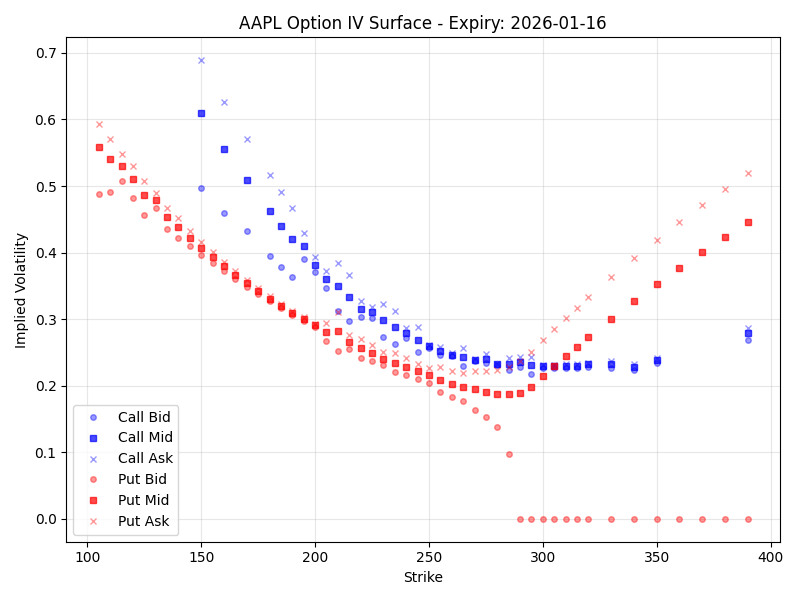

In [453]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

data = compute_iv_for_slice(df_slice, r=0.01)

mask_exp = (data["expiration"].dt.date == expiry)
data_exp = data[mask_exp]

calls = data_exp[data_exp["instrument_class"] == "C"]
puts  = data_exp[data_exp["instrument_class"] == "P"]

# Calls - different colors for bid/mid/ask
ax.plot(calls.strike_price, calls.iv_bid, "o", color="blue", alpha=0.4, label="Call Bid", markersize=4)
ax.plot(calls.strike_price, calls.iv_mid, "s", color="blue", alpha=0.7, label="Call Mid", markersize=5)
ax.plot(calls.strike_price, calls.iv_ask, "x", color="blue", alpha=0.4, label="Call Ask", markersize=4)

# Puts - different colors for bid/mid/ask
ax.plot(puts.strike_price, puts.iv_bid, "o", color="red", alpha=0.4, label="Put Bid", markersize=4)
ax.plot(puts.strike_price, puts.iv_mid, "s", color="red", alpha=0.7, label="Put Mid", markersize=5)
ax.plot(puts.strike_price, puts.iv_ask, "x", color="red", alpha=0.4, label="Put Ask", markersize=4)

ax.set_xlabel("Strike")
ax.set_ylabel("Implied Volatility")
ax.set_title(f"AAPL Option IV Surface - Expiry: {expiry}")
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
fig.tight_layout()

### How can we work out what are these implied interest rates?

Put-call parity around ATM call and put mid prices

- median implied interest rates
- compute forward and rate for each expiration slice

In [374]:
def median_implied_interest_rate(
    df, today, expiry, day_count=365.0
):
    """
    Rearrange the put-call parity formula to solve for the present value of the strike price:
    PV(K)=P+S*e^-qT-C
    e^-rT = (P+S*e^-qT-C)/K
    r=ln(K/(P+S*e^-qT-C))/T
    """
    T = (expiry - today).days / day_count

    K = df["strike_price"].to_numpy(float)
    pc = (df["put_mid"] - df["call_mid"]).to_numpy(float)  # (P - C)
    S = df['underlying_mid'].to_numpy(float)
    r = np.log(K/(pc + S*np.exp(-0.0037*T)))/T
    return np.median(r)

In [375]:
def compute_forward_and_rate_for_slice(df_slice, today, n_strikes=10):
    """
    Calculate forward price and implied risk-free rate for each expiration
    using put-call parity regression on OTM options closest to ATM.
    
    df_slice: DataFrame with columns [strike_price, opt_mid, expiration, instrument_class, underlying_mid]
    today: date object for trade date
    n_strikes: number of OTM strikes to use on each side
    
    Returns: DataFrame with columns [expiration, forward_price, discount_factor, implied_rate, T]
    """
    results = []
    
    # Group by expiration date
    for expiry_dt, group in df_slice.groupby(pd.to_datetime(df_slice["expiration"]).dt.date):
        
        # Get spot price
        S0 = group["underlying_mid"].iloc[0]
        
        # Separate calls and puts
        calls = group[group["instrument_class"] == "C"][["strike_price", "opt_mid", "underlying_mid"]].copy()
        calls = calls.rename(columns={"opt_mid": "call_mid"})
        
        puts = group[group["instrument_class"] == "P"][["strike_price", "opt_mid"]].copy()
        puts = puts.rename(columns={"opt_mid": "put_mid"})
        
        ## Get strikes closest to S0
        # Strikes below S0: take the n_strikes highest (closest from below)
        strikes_below = calls[calls["strike_price"] <= S0]["strike_price"].drop_duplicates().nlargest(n_strikes)
        # Strikes above S0: take the n_strikes lowest (closest from above)
        strikes_above = calls[calls["strike_price"] > S0]["strike_price"].drop_duplicates().nsmallest(n_strikes)
        
        # Combine strikes
        selected_strikes = pd.concat([strikes_below, strikes_above]).sort_values()
        
        # Filter calls and puts to only these strikes
        calls_filtered = calls[calls["strike_price"].isin(selected_strikes)]
        puts_filtered = puts[puts["strike_price"].isin(selected_strikes)]
        
        # Merge on strike
        merged = calls_filtered.merge(puts_filtered, on="strike_price", how="inner")
        
        # Drop NaN values
        merged = merged.dropna()
        
        if len(merged) < 3:  # Need at least 3 points for regression
            continue

        # Keep only near-ATM strikes
        merged = merged[np.abs(merged["call_mid"] - merged["put_mid"]) < 0.25 * merged["strike_price"]]
        
        # Drop garbage
        merged = merged[(merged["call_mid"] > 0) & (merged["put_mid"] > 0)]
        
        # Calculate forward and rate
        r = median_implied_interest_rate(merged, today, expiry_dt)
        
        T = (expiry_dt - today).days / 365.0
        
        results.append({
            'expiration': expiry_dt,
            'implied_rate': r,
            'time_to_expiry': T,
            'num_strikes': len(merged),
            'spot_price': S0
        })
    
    return pd.DataFrame(results)

In [376]:
implied_rates = compute_forward_and_rate_for_slice(df_slice, trade_day)
implied_rates

,expiration,implied_rate,time_to_expiry,num_strikes,spot_price
0,2025-09-26,0.099970,0.010959,20,248.235
1,2025-10-03,0.072435,0.030137,18,248.235
2,2025-10-10,0.064410,0.049315,20,248.235
3,2025-10-17,0.051568,0.068493,19,248.235
4,2025-10-24,0.051881,0.087671,20,248.235
5,2025-10-31,0.056554,0.106849,18,248.235
6,2025-11-21,0.039413,0.164384,20,248.235
7,2025-12-19,0.043163,0.241096,19,248.235
8,2026-01-16,0.044130,0.317808,19,248.235
9,2026-02-20,0.043469,0.413699,19,248.235


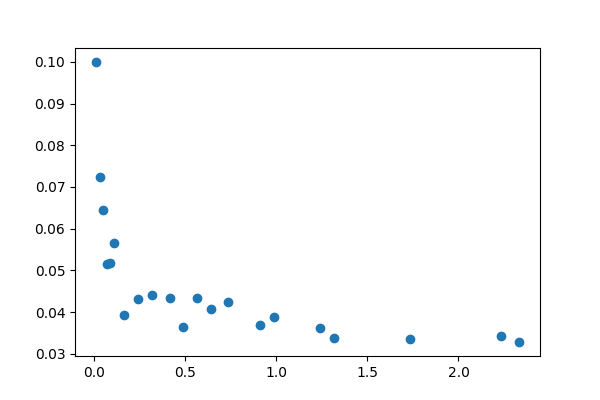

In [377]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.scatter(implied_rates.time_to_expiry,implied_rates.implied_rate)
plt.show()

### How to create function that takes input of time to expiry and returns interest rate

- Estimating the Yield Curve Using the Nelson‐Siegel Model
- Or if we want to capture very steep rate effects at short time to expiry we could simply use a spline

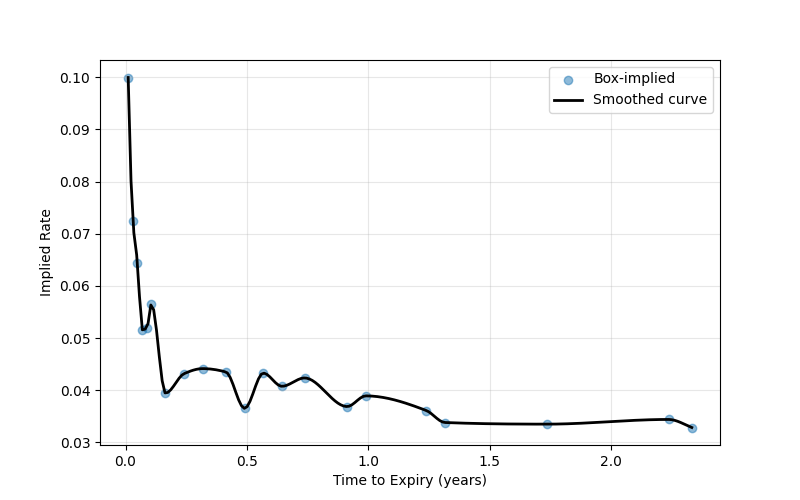

In [378]:
from scipy.interpolate import PchipInterpolator

r_spline = PchipInterpolator(implied_rates.time_to_expiry, implied_rates.implied_rate, extrapolate=True)

t_grid = np.linspace(implied_rates.time_to_expiry.min(), implied_rates.time_to_expiry.max(), 200)

plt.figure(figsize=(8,5))
plt.scatter(implied_rates.time_to_expiry, implied_rates.implied_rate,
            alpha=0.5, label="Box-implied")
plt.plot(t_grid, r_spline(t_grid),
         color="black", lw=2, label="Smoothed curve")

plt.xlabel("Time to Expiry (years)")
plt.ylabel("Implied Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [379]:
expiry_choice = 5

In [454]:
expiry = implied_rates.loc[expiry_choice,'expiration']
tau = (expiry - trade_day).days / 365.0
implied_rate = implied_rates.loc[expiry_choice,'implied_rate']

r = r_spline(tau)
tau,expiry,implied_rate, r

(0.10684931506849316,
 datetime.date(2025, 10, 31),
 np.float64(0.050394049392744736),
 array(0.05039405))

### Vol curve aligned to market interest rate values

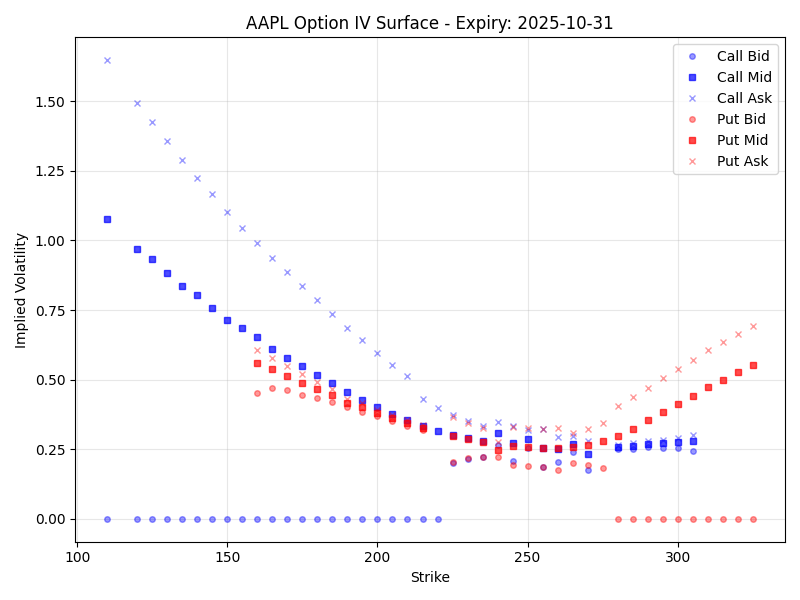

In [455]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

data = compute_iv_for_slice(df_slice, r=r_spline(tau))

mask_exp = (data["expiration"].dt.date == expiry)
data_exp = data[mask_exp]

calls = data_exp[data_exp["instrument_class"] == "C"]
puts  = data_exp[data_exp["instrument_class"] == "P"]

# Calls - different colors for bid/mid/ask
ax.plot(calls.strike_price, calls.iv_bid, "o", color="blue", alpha=0.4, label="Call Bid", markersize=4)
ax.plot(calls.strike_price, calls.iv_mid, "s", color="blue", alpha=0.7, label="Call Mid", markersize=5)
ax.plot(calls.strike_price, calls.iv_ask, "x", color="blue", alpha=0.4, label="Call Ask", markersize=4)

# Puts - different colors for bid/mid/ask
ax.plot(puts.strike_price, puts.iv_bid, "o", color="red", alpha=0.4, label="Put Bid", markersize=4)
ax.plot(puts.strike_price, puts.iv_mid, "s", color="red", alpha=0.7, label="Put Mid", markersize=5)
ax.plot(puts.strike_price, puts.iv_ask, "x", color="red", alpha=0.4, label="Put Ask", markersize=4)

ax.set_xlabel("Strike")
ax.set_ylabel("Implied Volatility")
ax.set_title(f"AAPL Option IV Surface - Expiry: {expiry}")
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
fig.tight_layout()

## Forward Pricing and Log-Moneyness

### 1. Forward Price Calculation

For a single maturity $T$, the forward price is:

$$F_0(T) = \frac{S_0 - \text{PV(dividends up to } T\text{)}}{ P(0,T)}$$

where:
- $S_0$ is spot
- $P(0,T) = e^{-rT}$ (or the appropriate discount factor)
- dividends can be discrete (subtract PV of each) or continuous (use dividend yield $q$)

#### Discrete Dividends

For **discrete dividends**, the forward price is calculated as:

$$F_0(T) = S_0 \cdot e^{rT} - \sum_{i} D_i \cdot e^{r(T - t_i)}$$

where:
- $D_i$ is the dividend amount paid at time $t_i$
- $t_i$ is the time until dividend payment (in years)
- The sum includes all dividends paid between now and maturity $T$

**Equivalently**, using the PV formulation:

$$F_0(T) = \frac{S_0 - \sum_{i} D_i \cdot e^{-r t_i}}{e^{-rT}}$$

where $\sum_{i} D_i \cdot e^{-r t_i}$ is the present value of all dividends paid before expiration.

#### Continuous Dividend Yield

With a continuous dividend yield:

$$F_0(T) = S_0 e^{(r-q)T}$$

So your intuition is correct: spot minus PV(dividends) is the pre-discounted forward, but for log-moneyness you want the true forward $F_0(T)$, i.e. after dividing by the discount factor.

### Log-moneyness on the forward scale

Once you have $F_0(T)$, define:

$$k = \log\left(\frac{K}{F_0(T)}\right)$$

This is the standard choice for SVI/SVII and ensures:
- the smile is centered near $k=0$ (ATM-forward)
- stability across maturities
- no sensitivity to carry conventions

### 2. Which options to use: calls vs puts

You should not use all calls and puts indiscriminately.

**The market-standard approach is:**

**Use OTM options only:**
- Calls for $K > F_0(T)$
- Puts for $K < F_0(T)$

**Reasons:**
- Better liquidity
- Tighter bid-ask spreads
- Less sensitivity to early-exercise / borrowing effects (for equities)

ATM can be taken from either side (or averaged).

Formally:

$$\sigma_{\text{market}}(k,T) = \begin{cases}
\sigma_{\text{put}}(K,T), & K < F_0(T) \\
\sigma_{\text{call}}(K,T), & K \geq F_0(T)
\end{cases}$$

This is exactly what equity and index volatility surfaces use in practice.

### 3. Where should the smile be centered?

**Yes — around the PV-adjusted forward.**

More precisely:
- The smile minimum is typically near $K = F_0(T)$
- In log-moneyness: $k = 0 \leftrightarrow K = F_0(T)$

This is why SVII is written as a function of $k = \log(K/F)$ and not $K$ or $K/S$.

If your minimum is drifting away from $k=0$, it usually indicates:
- incorrect dividend handling
- wrong discounting
- or mixing calls and puts inconsistently

### 4. Calibrating SVII (practical workflow)

For each maturity $T$:

1. Compute $F_0(T)$ consistently (rates + dividends)

2. Convert strikes to log-moneyness:
   $$k_i = \log(K_i / F_0(T))$$

3. Build a clean OTM implied vol set (call/put split)

4. Fit SVII to total variance:
   $$w(k,T) = \sigma_{\text{imp}}^2(k,T) \cdot T$$

5. Enforce static arbitrage constraints (SVII is designed for this)

---

## Section 10: Volatility Surface Visualization

### Log-Moneyness Transformation

**Log-moneyness:** $k = \ln(K/F)$ where $F$ is the forward price

**Advantages over raw strikes:**
- Centered at zero (ATM-forward)
- Invariant to spot level changes
- Symmetric interpretation (OTM calls/puts mirror)

### Smile Interpretation

- **$k < 0$**: ITM calls / OTM puts
- **$k = 0$**: ATM-forward (theoretical)
- **$k > 0$**: OTM calls / ITM puts

**Typical shape:**
- **Smile:** Higher IV at extremes (equity volatility skew)
- **Skew:** Left side elevated (crash protection demand)

Spot: $248.24
PV of dividends: $0.0000
Forward price: $249.74


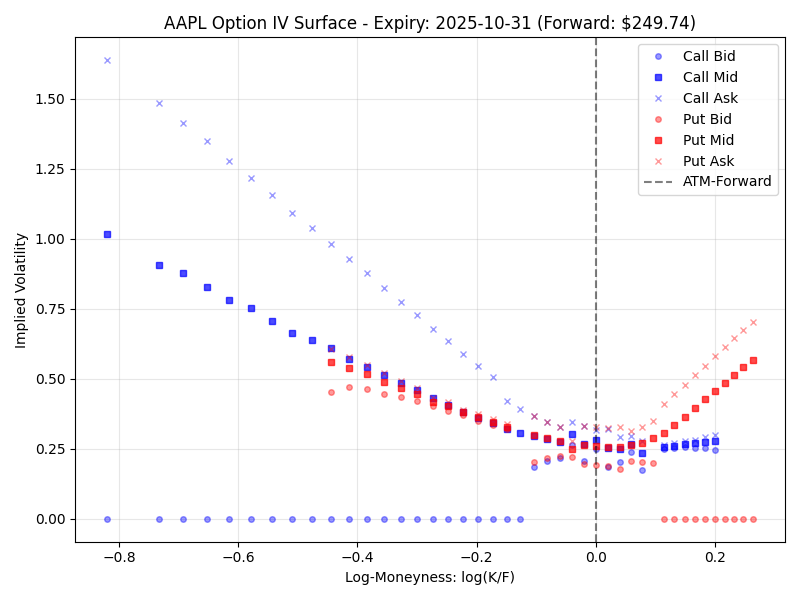

In [382]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

mask_exp = (data["expiration"].dt.date == expiry)
data_exp = data[mask_exp]

# Calculate forward price for this expiration
# Get the underlying price (assume it's the same for all rows in this slice)
S0 = data_exp["underlying_mid"].iloc[0]

# Calculate time to expiration in years
T = (expiry - trade_day).days / 365.25

# Filter dividends for this expiration
filtered_divs = filter_dividends(discrete, trade_day, expiry)
pv_divs = pv_dividends(filtered_divs, trade_day, r)

# Calculate forward price: F = (S0 - PV(divs)) / P(0,T) = (S0 - PV(divs)) * e^(rT)
F0 = (S0 - pv_divs) * np.exp(r * T)

print(f"Spot: ${S0:.2f}")
print(f"PV of dividends: ${pv_divs:.4f}")
print(f"Forward price: ${F0:.2f}")

calls = data_exp[data_exp["instrument_class"] == "C"].copy()
puts  = data_exp[data_exp["instrument_class"] == "P"].copy()

# Calculate log-moneyness: k = log(K/F)
calls["log_moneyness"] = np.log(calls["strike_price"] / F0)
puts["log_moneyness"] = np.log(puts["strike_price"] / F0)

# Calls - different colors for bid/mid/ask
ax.plot(calls.log_moneyness, calls.iv_bid, "o", color="blue", alpha=0.4, label="Call Bid", markersize=4)
ax.plot(calls.log_moneyness, calls.iv_mid, "s", color="blue", alpha=0.7, label="Call Mid", markersize=5)
ax.plot(calls.log_moneyness, calls.iv_ask, "x", color="blue", alpha=0.4, label="Call Ask", markersize=4)

# Puts - different colors for bid/mid/ask
ax.plot(puts.log_moneyness, puts.iv_bid, "o", color="red", alpha=0.4, label="Put Bid", markersize=4)
ax.plot(puts.log_moneyness, puts.iv_mid, "s", color="red", alpha=0.7, label="Put Mid", markersize=5)
ax.plot(puts.log_moneyness, puts.iv_ask, "x", color="red", alpha=0.4, label="Put Ask", markersize=4)

# Add vertical line at ATM-forward (k=0)
ax.axvline(x=0, color='black', linestyle='--', alpha=0.5, label='ATM-Forward')

ax.set_xlabel("Log-Moneyness: log(K/F)")
ax.set_ylabel("Implied Volatility")
ax.set_title(f"AAPL Option IV Surface - Expiry: {expiry} (Forward: ${F0:.2f})")
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
fig.tight_layout()

### For meaningful vol curve, only look at OTM options with threshold of Forward value

- we can model all prices across the European curve by using put call parity. Only model OTM options

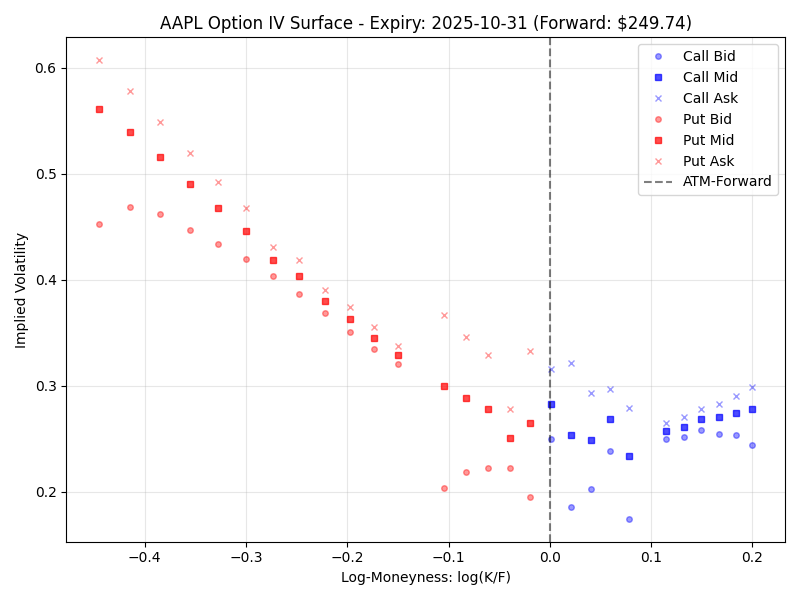

In [383]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

# Only calls above forward
calls_above_F = calls[calls["strike_price"] >= F0]
# Only puts below forward
puts_below_F = puts[puts["strike_price"] <= F0]

# Calls
ax.plot(calls_above_F.log_moneyness, calls_above_F.iv_bid, "o", color="blue", alpha=0.4, label="Call Bid", markersize=4)
ax.plot(calls_above_F.log_moneyness, calls_above_F.iv_mid, "s", color="blue", alpha=0.7, label="Call Mid", markersize=5)
ax.plot(calls_above_F.log_moneyness, calls_above_F.iv_ask, "x", color="blue", alpha=0.4, label="Call Ask", markersize=4)

# Puts
ax.plot(puts_below_F.log_moneyness, puts_below_F.iv_bid, "o", color="red", alpha=0.4, label="Put Bid", markersize=4)
ax.plot(puts_below_F.log_moneyness, puts_below_F.iv_mid, "s", color="red", alpha=0.7, label="Put Mid", markersize=5)
ax.plot(puts_below_F.log_moneyness, puts_below_F.iv_ask, "x", color="red", alpha=0.4, label="Put Ask", markersize=4)

# Add vertical line at ATM-forward (k=0)
ax.axvline(x=0, color='black', linestyle='--', alpha=0.5, label='ATM-Forward')

ax.set_xlabel("Log-Moneyness: log(K/F)")
ax.set_ylabel("Implied Volatility")
ax.set_title(f"AAPL Option IV Surface - Expiry: {expiry} (Forward: ${F0:.2f})")
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
fig.tight_layout()

### Set up the streaming IV plot with dropdown (per expiration)

Dropdown(description='Expiration', options=(datetime.date(2025, 9, 26), datetime.date(2025, 10, 3), datetime.d…

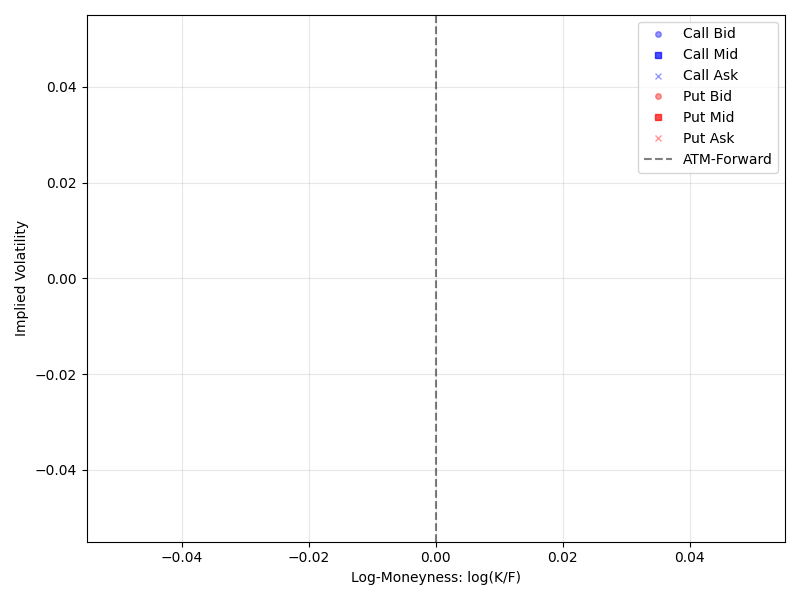

In [456]:
%matplotlib widget
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import warnings
warnings.filterwarnings(
    "ignore",
    message="Passing unrecognized arguments to super",
    category=DeprecationWarning,
)

plt.ion()

# Collect all expirations (from full df_merged, not just one slice)
all_exps = pd.to_datetime(df_merged["expiration"]).dt.date.unique()
all_exps = sorted(all_exps)

exp_dropdown = widgets.Dropdown(
    options=all_exps,
    description="Expiration",
    value=all_exps[0]
)

display(exp_dropdown)

fig, ax = plt.subplots(figsize=(8, 6))

call_bid_plot, = ax.plot([], [], "o", color="blue", alpha=0.4, label="Call Bid", markersize=4)
call_mid_plot, = ax.plot([], [], "s", color="blue", alpha=0.7, label="Call Mid", markersize=5)
call_ask_plot, = ax.plot([], [], "x", color="blue", alpha=0.4, label="Call Ask", markersize=4)

put_bid_plot,  = ax.plot([], [], "o", color="red", alpha=0.4, label="Put Bid", markersize=4)
put_mid_plot,  = ax.plot([], [], "s", color="red", alpha=0.7, label="Put Mid", markersize=5)
put_ask_plot,  = ax.plot([], [], "x", color="red", alpha=0.4, label="Put Ask", markersize=4)

atm_line = ax.axvline(0.0, color="black", linestyle="--", alpha=0.5, label="ATM-Forward")

ax.set_xlabel("Log-Moneyness: log(K/F)")
ax.set_ylabel("Implied Volatility")
ax.legend(loc="best")
ax.grid(True, alpha=0.3)
fig.tight_layout()

def update_iv_plot(df_slice_with_iv, selected_exp_date):
    """
    df_slice_with_iv: slice DataFrame returned from compute_iv_for_slice
    selected_exp_date: a datetime.date from dropdown
    """
    mask_exp = df_slice["expiration"].dt.date == selected_exp_date

    df_slice_with_iv = df_slice_with_iv[mask_exp]

    S0 = data_exp["underlying_mid"].iloc[0]

    # Calculate time to expiration in years
    tau = (expiry - trade_day).days / 365.25
    r = r_spline(tau)
    
    # Filter dividends for this expiration
    filtered_divs = filter_dividends(discrete, trade_day, expiry)
    pv_divs = pv_dividends(filtered_divs, trade_day, r)
    
    # Calculate forward price: F = (S0 - PV(divs)) / P(0,T) = (S0 - PV(divs)) * e^(rT)
    F0 = (S0 - pv_divs) * np.exp(r * tau)

    calls = df_slice_with_iv[df_slice_with_iv["instrument_class"] == "C"].copy()
    puts  = df_slice_with_iv[df_slice_with_iv["instrument_class"] == "P"].copy()

    # Log-moneyness
    calls["log_moneyness"] = np.log(calls["strike_price"] / F0)
    puts["log_moneyness"]  = np.log(puts["strike_price"] / F0)

    # OTM only
    calls = calls[calls["strike_price"] >= F0]
    puts  = puts[puts["strike_price"] <= F0]

    # --- SET DATA (this is the key part) ---
    call_bid_plot.set_data(calls.log_moneyness, calls.iv_bid)
    call_mid_plot.set_data(calls.log_moneyness, calls.iv_mid)
    call_ask_plot.set_data(calls.log_moneyness, calls.iv_ask)

    put_bid_plot.set_data(puts.log_moneyness, puts.iv_bid)
    put_mid_plot.set_data(puts.log_moneyness, puts.iv_mid)
    put_ask_plot.set_data(puts.log_moneyness, puts.iv_ask)

    # Rescale axes
    ax.relim()
    ax.autoscale_view()

    fig.canvas.draw()
    fig.canvas.flush_events()



In [458]:
replay = DataReplay(df_merged, timestamp_col="ts_recv", realtime=True)

# 1. compute IVs for this 1-second snapshot
selected_exp = exp_dropdown.value  # datetime.date
tau = (selected_exp - trade_day).days / 365.25
r = r_spline(tau)

ax.set_title(f"AAPL Option IV Surface - Expiry: {expiry} (Forward: ${F0:.2f})")

for ts, df_slice in replay:
    df_iv = compute_iv_for_slice(df_slice, r=r)
    update_iv_plot(df_iv, selected_exp)
    print(f"Replay time: {ts}, rows: {len(df_iv)}")


Replay time: 2025-09-22 13:30:01+00:00, rows: 2196
Replay time: 2025-09-22 13:30:02+00:00, rows: 2280
Replay time: 2025-09-22 13:30:03+00:00, rows: 2280
Replay time: 2025-09-22 13:30:04+00:00, rows: 2280
Replay time: 2025-09-22 13:30:05+00:00, rows: 2280
Replay time: 2025-09-22 13:30:06+00:00, rows: 2280
Replay time: 2025-09-22 13:30:07+00:00, rows: 2280
Replay time: 2025-09-22 13:30:08+00:00, rows: 2280
Replay time: 2025-09-22 13:30:09+00:00, rows: 2280
Replay time: 2025-09-22 13:30:10+00:00, rows: 2280
Replay time: 2025-09-22 13:30:11+00:00, rows: 2280
Replay time: 2025-09-22 13:30:12+00:00, rows: 2280
Replay time: 2025-09-22 13:30:13+00:00, rows: 2280
Replay time: 2025-09-22 13:30:14+00:00, rows: 2280
Replay time: 2025-09-22 13:30:15+00:00, rows: 2280
Replay time: 2025-09-22 13:30:16+00:00, rows: 2280
Replay time: 2025-09-22 13:30:17+00:00, rows: 2280
Replay time: 2025-09-22 13:30:18+00:00, rows: 2280
Replay time: 2025-09-22 13:30:19+00:00, rows: 2280
Replay time: 2025-09-22 13:30:2

KeyboardInterrupt: 

## American IV using Numerical Root Finding

Calculate American implied volatility using Brent's method with the CRR binomial model.

Uses **Brent's method** (root finding) to numerically invert the binomial pricing function:

Given market price $P_{\text{market}}$, find $\sigma$ such that:
$$
P_{\text{CRR}}(S_0, K, T, r, \sigma, \text{divs}) = P_{\text{market}}
$$

### Compute American IV for All Strikes

Loop through all strikes and apply numerical solver. This is computationally intensive due to:
- Multiple binomial tree evaluations per strike
- Root finding iterations per option

**Optimization opportunities:**
- Parallelize across strikes
- Cache intermediate tree results
- Use analytical approximations for initial guess

### Key Difference: American vs European IV

American options trade at **lower implied volatility** than Europeans when calculated using BSM, because:

$$
P_{\text{American}} = P_{\text{European}} + \text{EEP}
$$

If we use European formula to back out IV from American market price, we get inflated volatility that compensates for missing EEP.

In [459]:
from scipy.optimize import brentq

def american_implied_vol(market_price, S0, K, T, r, div_times, div_amounts, opttype, N=500, tol=1e-6):
    """
    Calculate American implied volatility using Brent's method.
    
    Parameters:
    -----------
    market_price : Observed market price
    S0 : Spot price
    K : Strike
    T : Time to maturity (years)
    r : Risk-free rate
    div_times : List of dividend times
    div_amounts : List of dividend amounts
    opttype : 'C' or 'P'
    N : Number of binomial steps
    tol : Tolerance for convergence
    
    Returns:
    --------
    Implied volatility (or np.nan if not found)
    """
    
    # Intrinsic value
    if opttype.upper() == 'C':
        intrinsic = max(S0 - K, 0)
    else:
        intrinsic = max(K - S0, 0)
    
    # If market price is below intrinsic, no valid IV
    if market_price < intrinsic:
        return np.nan
    
    # Objective function: model_price - market_price
    def objective(sigma):
        try:
            model_price = CRR_method_fast_american_cash_dividend(
                K=K, T=T, S0=S0, r=r, N=N, sigma=sigma,
                div_times=div_times, div_amounts=div_amounts,
                opttype=opttype
            )
            return model_price - market_price
        except:
            return np.nan
    
    # Search bounds for volatility
    vol_min, vol_max = 0.01, 3.0
    
    try:
        # Check if solution exists in bounds
        f_min = objective(vol_min)
        f_max = objective(vol_max)
        
        if np.isnan(f_min) or np.isnan(f_max):
            return np.nan
        
        # Brent's method requires opposite signs
        if f_min * f_max > 0:
            return np.nan
        
        # Find root
        iv = brentq(objective, vol_min, vol_max, xtol=tol, maxiter=100)
        return iv
    
    except:
        return np.nan

---

## Section 9: American Implied Volatility Solver

### Numerical Root Finding with Brent's Method

**Brent's method** combines:
- Bisection (guaranteed convergence)
- Secant method (fast quadratic convergence)
- Inverse quadratic interpolation (superlinear convergence)

**Advantages over Newton-Raphson:**
- No need for vega calculation
- More robust for non-smooth objective functions

### Implementation Details

1. **Intrinsic value check:** If $P_{\text{market}} < \max(S-K, 0)$, return NaN (invalid)
2. **Bracket search:** Initial bounds [0.001, 5.0] cover typical volatility range
3. **Tolerance:** $10^{-6}$ provides sufficient precision for trading

Spot: $248.24
PV of dividends: $0.0000
Forward price: $249.43
Calculating American IVs...
Done! Calculated 38 calls and 33 puts


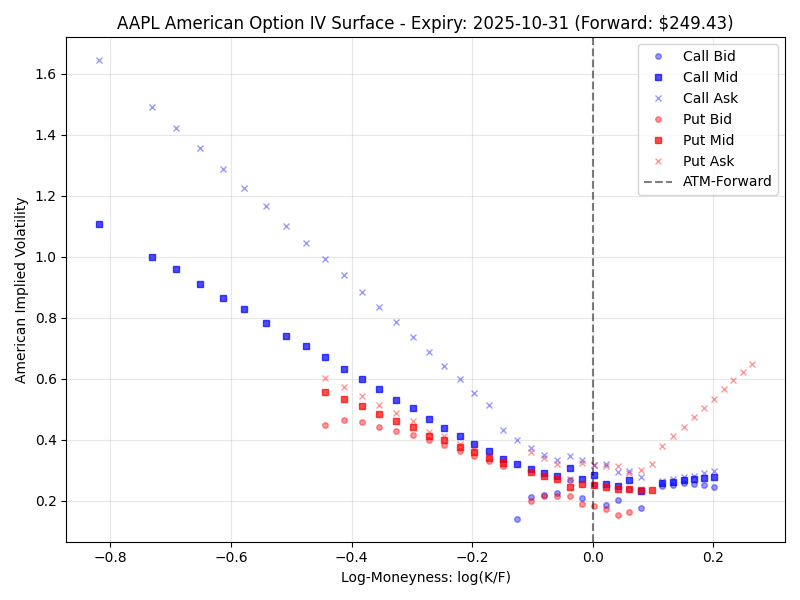

In [460]:
# Calculate American IVs for the selected expiration
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

mask_exp = (data["expiration"].dt.date == expiry)
data_exp = data[mask_exp].copy()

# Valid rows for IV calculation
valid = (
    (data_exp["underlying_mid"] > 0) &
    (data_exp["strike_price"] > 0) &
    (data_exp["T"] > 0) &
    (data_exp["bid_sz_00"] > 0) &
    (data_exp["ask_sz_00"] > 0)
)

data_exp = data_exp[valid]

# Calculate forward price for this expiration
S0 = data_exp["underlying_mid"].iloc[0]
T = (expiry - trade_day).days / 365.25
r = 0.045

# Filter dividends for this expiration
filtered_divs = filter_dividends(discrete, trade_day, expiry)
pv_divs = pv_dividends(filtered_divs, trade_day, r)

# Convert dividends to CRR format
div_times = []
div_amounts = []
for div_date, amount in filtered_divs.items():
    time_to_div = (div_date - trade_day).days / 365.25
    div_times.append(time_to_div)
    div_amounts.append(amount)

# Calculate forward price
F0 = (S0 - pv_divs) * np.exp(r * T)

print(f"Spot: ${S0:.2f}")
print(f"PV of dividends: ${pv_divs:.4f}")
print(f"Forward price: ${F0:.2f}")
print(f"Calculating American IVs...")

# Calculate American IVs for calls
data_exp["american_iv_call_mid"] = np.nan
data_exp["american_iv_call_bid"] = np.nan
data_exp["american_iv_call_ask"] = np.nan

# Calculate American IVs for puts
data_exp["american_iv_put_mid"] = np.nan
data_exp["american_iv_put_bid"] = np.nan
data_exp["american_iv_put_ask"] = np.nan

# Process calls
calls_mask = data_exp["instrument_class"] == "C"
for idx in data_exp[calls_mask].index:
    K = data_exp.loc[idx, "strike_price"]
    
    # Mid
    mid_price = data_exp.loc[idx, "opt_mid"]
    data_exp.loc[idx, "american_iv_call_mid"] = american_implied_vol(
        mid_price, S0, K, T, r, div_times, div_amounts, "C"
    )
    
    # Bid
    bid_price = data_exp.loc[idx, "bid_px_00"]
    data_exp.loc[idx, "american_iv_call_bid"] = american_implied_vol(
        bid_price, S0, K, T, r, div_times, div_amounts, "C"
    )
    
    # Ask
    ask_price = data_exp.loc[idx, "ask_px_00"]
    data_exp.loc[idx, "american_iv_call_ask"] = american_implied_vol(
        ask_price, S0, K, T, r, div_times, div_amounts, "C"
    )

# Process puts
puts_mask = data_exp["instrument_class"] == "P"
for idx in data_exp[puts_mask].index:
    K = data_exp.loc[idx, "strike_price"]
    
    # Mid
    mid_price = data_exp.loc[idx, "opt_mid"]
    data_exp.loc[idx, "american_iv_put_mid"] = american_implied_vol(
        mid_price, S0, K, T, r, div_times, div_amounts, "P"
    )
    
    # Bid
    bid_price = data_exp.loc[idx, "bid_px_00"]
    data_exp.loc[idx, "american_iv_put_bid"] = american_implied_vol(
        bid_price, S0, K, T, r, div_times, div_amounts, "P"
    )
    
    # Ask
    ask_price = data_exp.loc[idx, "ask_px_00"]
    data_exp.loc[idx, "american_iv_put_ask"] = american_implied_vol(
        ask_price, S0, K, T, r, div_times, div_amounts, "P"
    )

print(f"Done! Calculated {calls_mask.sum()} calls and {puts_mask.sum()} puts")

# Separate calls and puts
callsA = data_exp[data_exp["instrument_class"] == "C"].copy()
putsA  = data_exp[data_exp["instrument_class"] == "P"].copy()

# Calculate log-moneyness
callsA["log_moneyness"] = np.log(callsA["strike_price"] / F0)
putsA["log_moneyness"] = np.log(putsA["strike_price"] / F0)

# Plot American IVs
ax.plot(callsA.log_moneyness, callsA.american_iv_call_bid, "o", color="blue", alpha=0.4, label="Call Bid", markersize=4)
ax.plot(callsA.log_moneyness, callsA.american_iv_call_mid, "s", color="blue", alpha=0.7, label="Call Mid", markersize=5)
ax.plot(callsA.log_moneyness, callsA.american_iv_call_ask, "x", color="blue", alpha=0.4, label="Call Ask", markersize=4)

ax.plot(putsA.log_moneyness, putsA.american_iv_put_bid, "o", color="red", alpha=0.4, label="Put Bid", markersize=4)
ax.plot(putsA.log_moneyness, putsA.american_iv_put_mid, "s", color="red", alpha=0.7, label="Put Mid", markersize=5)
ax.plot(putsA.log_moneyness, putsA.american_iv_put_ask, "x", color="red", alpha=0.4, label="Put Ask", markersize=4)

# Add vertical line at ATM-forward (k=0)
ax.axvline(x=0, color='black', linestyle='--', alpha=0.5, label='ATM-Forward')

ax.set_xlabel("Log-Moneyness: log(K/F)")
ax.set_ylabel("American Implied Volatility")
ax.set_title(f"AAPL American Option IV Surface - Expiry: {expiry} (Forward: ${F0:.2f})")
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
fig.tight_layout()

#### Now we've calculated IV using a 'more correct pricing model'

But, it's slow to imply IV's realtime, is there a better way?


The key point to highlight is that the computational load and model realism are inversely related:

- American model → realistic but slow (especially when inverting for implied volatility).

- Simplified BSM → fast but slightly less accurate, yet often "good enough" for liquid, near-the-money options.

- In practice, market makers rarely use a full American inversion for implied vol because it’s computationally slow and provides little extra accuracy. Most implied volatilities quoted in markets are European-style implied vols, even for American options.

---

## Section 11: Early Exercise Premium (EEP) Calculation

### Definition

$$
\text{EEP}(S, K, T) = P_{\text{American}}(S, K, T) - P_{\text{European}}(S, K, T)
$$

### When is EEP Large?

1. **Deep ITM puts:** High time value of money benefit from exercise
2. **Dividends approaching:** Capture dividend by exercising calls
3. **Low volatility:** Continuation value small relative to intrinsic

### Compute EEP for Full Surface

Calculate both American and European prices using CRR method, then take the difference.

## Calculate Early Exercise Premium (EEP)

Early Exercise Premium = American Price - European Price

We'll calculate this across different strikes for a given expiration.

### Loop Through All Expiries and Strikes

Build comprehensive EEP lookup table for entire options chain. This enables:
- Dividend-adjusted volatility surfaces
- Better calibration of pricing models
- Accurate risk management of American option books

In [461]:
# Parameters
expiry = all_exps[15]  # Select an expiration
trade_day = dt.date.fromisoformat("2025-09-22")

# Get data for this expiration
mask_exp = (data["expiration"].dt.date == expiry)
data_exp = data[mask_exp]

# Market parameters
S0 = data_exp["underlying_mid"].iloc[0]
# Calculate time to expiration in years
tau = (expiry - trade_day).days / 365.25
r = r_spline(tau)
sigma = 0.30  # Assumed constant volatility (or use ATM IV)
N = 500  # Number of time steps

# Time to expiration in years
T = (expiry - trade_day).days / 365.25

# Filter dividends for this expiration
filtered_divs = filter_dividends(discrete, trade_day, expiry)

print(f"Trade Date: {trade_day}")
print(f"Expiration: {expiry}")
print(f"Spot: ${S0:.2f}")
print(f"Time to Expiry: {T:.4f} years")
print(f"Filtered Dividends: {filtered_divs}")

# Convert dividends to CRR format: (time_to_div, amount)
div_times = []
div_amounts = []

for div_date, amount in filtered_divs.items():
    time_to_div = (div_date - trade_day).days / 365.25
    div_times.append(time_to_div)
    div_amounts.append(amount)

print(f"\nDividend times: {div_times}")
print(f"Dividend amounts: {div_amounts}")

Trade Date: 2025-09-22
Expiration: 2026-09-18
Spot: $248.24
Time to Expiry: 0.9884 years
Filtered Dividends: {datetime.date(2025, 11, 10): 0.26, datetime.date(2026, 2, 10): 0.27, datetime.date(2026, 5, 12): 0.27, datetime.date(2026, 8, 11): 0.27}

Dividend times: [0.13415468856947296, 0.3860369609856263, 0.6351813826146475, 0.8843258042436687]
Dividend amounts: [0.26, 0.27, 0.27, 0.27]


In [462]:
# Get unique strikes from the data
strikes = sorted(data_exp["strike_price"].unique())

# Calculate EEP for calls
eep_calls = []
american_calls = []
european_calls = []

for K in strikes:
    # American call
    american_price = CRR_method_fast_american_cash_dividend(
        K=K, T=T, S0=S0, r=r, N=N, sigma=sigma,
        div_times=div_times, div_amounts=div_amounts,
        opttype="C"
    )
    
    # European call
    european_price = CRR_method_fast_european_cash_dividend(
        K=K, T=T, S0=S0, r=r, N=N, sigma=sigma,
        div_times=div_times, div_amounts=div_amounts,
        opttype="C"
    )
    
    # Early Exercise Premium
    eep = american_price - european_price
    
    american_calls.append(american_price)
    european_calls.append(european_price)
    eep_calls.append(eep)

# Calculate EEP for puts
eep_puts = []
american_puts = []
european_puts = []

for K in strikes:
    # American put
    american_price = CRR_method_fast_american_cash_dividend(
        K=K, T=T, S0=S0, r=r, N=N, sigma=sigma,
        div_times=div_times, div_amounts=div_amounts,
        opttype="P"
    )
    
    # European put
    european_price = CRR_method_fast_european_cash_dividend(
        K=K, T=T, S0=S0, r=r, N=N, sigma=sigma,
        div_times=div_times, div_amounts=div_amounts,
        opttype="P"
    )
    
    # Early Exercise Premium
    eep = american_price - european_price
    
    american_puts.append(american_price)
    european_puts.append(european_price)
    eep_puts.append(eep)

print(f"Calculated EEP for {len(strikes)} strikes")

# Create results DataFrame
results = pd.DataFrame({
    'Strike': strikes,
    'American_Call': american_calls,
    'European_Call': european_calls,
    'EEP_Call': eep_calls,
    'American_Put': american_puts,
    'European_Put': european_puts,
    'EEP_Put': eep_puts
})

# Calculate moneyness
results['Moneyness'] = results['Strike'] / S0

print(f"\nEarly Exercise Premium Summary:")
print(f"Spot Price: ${S0:.2f}")
print(f"Time to Expiry: {T:.4f} years\n")
results.head(10)

Calculated EEP for 61 strikes

Early Exercise Premium Summary:
Spot Price: $248.24
Time to Expiry: 0.9884 years



,Strike,American_Call,European_Call,EEP_Call,American_Put,European_Put,EEP_Put,Moneyness
0,50.0,199.278235,199.237777,0.040458,1.310539e-07,1.301712e-07,8.827331e-10,0.201422
1,55.0,194.459656,194.440713,0.018943,8.269846e-07,8.203268e-07,6.657761e-09,0.221564
2,60.0,189.643651,189.643651,0.000000,4.109120e-06,4.076479e-06,3.264151e-08,0.241706
3,65.0,184.846599,184.846599,0.000000,1.664999e-05,1.650941e-05,1.405890e-07,0.261849
4,70.0,180.049573,180.049573,0.000000,5.676227e-05,5.622200e-05,5.402714e-07,0.281991
5,75.0,175.252623,175.252623,0.000000,1.721054e-04,1.705800e-04,1.525377e-06,0.302133
6,80.0,170.455839,170.455839,0.000000,4.567355e-04,4.519647e-04,4.770726e-06,0.322275
7,85.0,165.659433,165.659433,0.000000,1.122709e-03,1.111289e-03,1.141991e-05,0.342417
8,90.0,160.863742,160.863742,0.000000,2.511550e-03,2.485528e-03,2.602234e-05,0.362560
9,95.0,156.069347,156.069347,0.000000,5.211729e-03,5.155636e-03,5.609277e-05,0.382702


###  Plot Early Exercise Premium

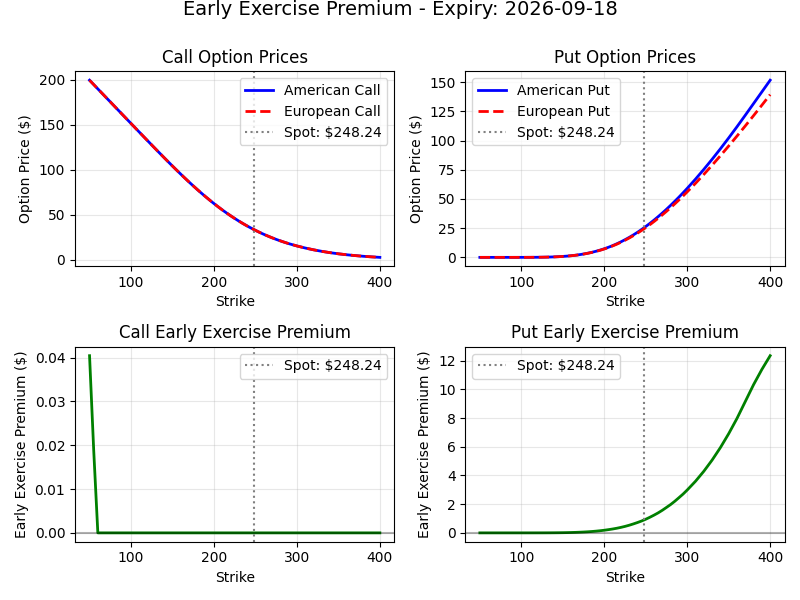

In [463]:
# Plot Early Exercise Premium
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# Plot 1: Call Prices
ax = axes[0, 0]
ax.plot(results['Strike'], results['American_Call'], 'b-', label='American Call', linewidth=2)
ax.plot(results['Strike'], results['European_Call'], 'r--', label='European Call', linewidth=2)
ax.axvline(S0, color='gray', linestyle=':', label=f'Spot: ${S0:.2f}')
ax.set_xlabel('Strike')
ax.set_ylabel('Option Price ($)')
ax.set_title('Call Option Prices')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Put Prices
ax = axes[0, 1]
ax.plot(results['Strike'], results['American_Put'], 'b-', label='American Put', linewidth=2)
ax.plot(results['Strike'], results['European_Put'], 'r--', label='European Put', linewidth=2)
ax.axvline(S0, color='gray', linestyle=':', label=f'Spot: ${S0:.2f}')
ax.set_xlabel('Strike')
ax.set_ylabel('Option Price ($)')
ax.set_title('Put Option Prices')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Call EEP
ax = axes[1, 0]
ax.plot(results['Strike'], results['EEP_Call'], 'g-', linewidth=2)
ax.axvline(S0, color='gray', linestyle=':', label=f'Spot: ${S0:.2f}')
ax.axhline(0, color='black', linestyle='-', alpha=0.3)
ax.set_xlabel('Strike')
ax.set_ylabel('Early Exercise Premium ($)')
ax.set_title('Call Early Exercise Premium')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Put EEP
ax = axes[1, 1]
ax.plot(results['Strike'], results['EEP_Put'], 'g-', linewidth=2)
ax.axvline(S0, color='gray', linestyle=':', label=f'Spot: ${S0:.2f}')
ax.axhline(0, color='black', linestyle='-', alpha=0.3)
ax.set_xlabel('Strike')
ax.set_ylabel('Early Exercise Premium ($)')
ax.set_title('Put Early Exercise Premium')
ax.legend()
ax.grid(True, alpha=0.3)

fig.suptitle(f'Early Exercise Premium - Expiry: {expiry}', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

#### Create dataframe with all pre-calculate EEP(time to expiry, strike | S, vol)

- so we pre-calculate all combinatoins of time to expiry, strike EEP pretrade for a set of underlying and vol assumptions. Ideally here you use vol curve of previous day for each undelrying, expiration date. However as an example here, we will just compute a flat surface for vol at 30% (because I'm lazy).

In [464]:
calls_rows = []
puts_rows = []

for expiry in all_exps:

    mask_exp = (data["expiration"].dt.date == expiry)
    data_exp = data.loc[mask_exp]

    if data_exp.empty:
        continue

    # Market inputs
    S0 = data_exp["underlying_mid"].iloc[0]
    T  = (expiry - trade_day).days / 365.25
    r  = r_spline(T)

    # Dividends
    filtered_divs = filter_dividends(discrete, trade_day, expiry)

    div_times = []
    div_amounts = []
    for div_date, amount in filtered_divs.items():
        div_times.append((div_date - trade_day).days / 365.25)
        div_amounts.append(amount)

    strikes = sorted(data_exp["strike_price"].unique())

    for K in strikes:

        amer_c = CRR_method_fast_american_cash_dividend(
            K=K, T=T, S0=S0, r=r, N=N, sigma=sigma,
            div_times=div_times, div_amounts=div_amounts,
            opttype="C"
        )

        euro_c = CRR_method_fast_european_cash_dividend(
            K=K, T=T, S0=S0, r=r, N=N, sigma=sigma,
            div_times=div_times, div_amounts=div_amounts,
            opttype="C"
        )

        calls_rows.append({
            "expiry": expiry,
            "K": K,
            "eep": amer_c - euro_c,
            "american_price": amer_c,
            "european_price": euro_c
        })

        amer_p = CRR_method_fast_american_cash_dividend(
            K=K, T=T, S0=S0, r=r, N=N, sigma=sigma,
            div_times=div_times, div_amounts=div_amounts,
            opttype="P"
        )

        euro_p = CRR_method_fast_european_cash_dividend(
            K=K, T=T, S0=S0, r=r, N=N, sigma=sigma,
            div_times=div_times, div_amounts=div_amounts,
            opttype="P"
        )

        puts_rows.append({
            "expiry": expiry,
            "K": K,
            "eep": amer_p - euro_p,
            "american_price": amer_p,
            "european_price": euro_p
        })


In [465]:
calls_eep = (
    pd.DataFrame(calls_rows)
      .set_index(["expiry", "K"])
      .sort_index()
)

puts_eep = (
    pd.DataFrame(puts_rows)
      .set_index(["expiry", "K"])
      .sort_index()
)


In [466]:
puts_eep

eep  american_price  european_price
expiry     K                                                   
2025-09-26 110.0   0.000000e+00    0.000000e+00    0.000000e+00
           120.0   0.000000e+00    0.000000e+00    0.000000e+00
           125.0  2.559512e-145   1.544715e-140   1.544690e-140
           130.0  4.857133e-122   7.257308e-118   7.256823e-118
           135.0  4.001375e-104   7.598962e-101   7.594961e-101
...                         ...             ...             ...
2028-01-21 280.0   3.860390e+00    5.534840e+01    5.148801e+01
           290.0   4.527442e+00    6.186317e+01    5.733573e+01
           300.0   5.241620e+00    6.872562e+01    6.348399e+01
           310.0   6.036731e+00    7.589648e+01    6.985975e+01
           320.0   6.917142e+00    8.335682e+01    7.643967e+01

[1140 rows x 3 columns]

### Merge EEP into Market Data

Join calculated EEP values back to original DataFrame for unified analysis.

In [467]:
calls_eep_df = (
    calls_eep
    .reset_index()   # expiry, K become columns
    .rename(columns={"K": "strike_price"})
)

puts_eep_df = (
    puts_eep
    .reset_index()
    .rename(columns={"K": "strike_price"})
)

df_merged.expiration = df_merged.expiration.dt.date

In [468]:
# separate into calls and puts

df_calls = df_merged[df_merged["instrument_class"] == "C"].copy()
df_puts  = df_merged[df_merged["instrument_class"] == "P"].copy()

# Merge EEP onto calls and puts separately

df_calls = df_calls.merge(
    calls_eep_df,
    left_on=["expiration", "strike_price"],
    right_on=["expiry", "strike_price"],
    how="left"
)

df_puts = df_puts.merge(
    puts_eep_df,
    left_on=["expiration", "strike_price"],
    right_on=["expiry", "strike_price"],
    how="left"
)

df_merged_with_eep = pd.concat([df_calls, df_puts], axis=0)

df_merged_with_eep = df_merged_with_eep.copy()  # IMPORTANT if df_merged came from a slice

df_merged_with_eep["ts_recv"] = pd.to_datetime(
    df_merged_with_eep["ts_recv"],
    errors="coerce",
    utc=True
)

df_merged_with_eep["expiration"] = pd.to_datetime(
    df_merged_with_eep["expiration"],
    errors="coerce",
    utc=True
)

df_merged_with_eep.head()

,ts_recv,ts_event,rtype,publisher_id,instrument_id,side,price,size,flags,bid_px_00,...,opt_mid,underlying_mid,underlying,expiration,instrument_class,strike_price,expiry,eep,american_price,european_price
0,2025-09-22 13:30:01+00:00,NaN,192,30,33558878,N,NaN,0,192,180.20,...,181.475,248.235,AAPL,2026-12-18 00:00:00+00:00,C,70.0,2026-12-18,0.0,180.340400,180.340400
1,2025-09-22 13:30:01+00:00,NaN,192,30,33560935,N,NaN,0,192,66.10,...,67.375,248.235,AAPL,2026-06-18 00:00:00+00:00,C,190.0,2026-06-18,0.0,66.892886,66.892886
2,2025-09-22 13:30:01+00:00,NaN,192,30,33558943,N,NaN,0,192,1.76,...,1.880,248.235,AAPL,2026-12-18 00:00:00+00:00,C,390.0,2026-12-18,0.0,5.461267,5.461267
3,2025-09-22 13:30:01+00:00,NaN,192,30,33563402,N,NaN,0,192,16.55,...,17.100,248.235,AAPL,2026-09-18 00:00:00+00:00,C,275.0,2026-09-18,0.0,22.793628,22.793628
4,2025-09-22 13:30:01+00:00,NaN,192,30,33555663,N,NaN,0,192,63.00,...,64.275,248.235,AAPL,2025-10-24 00:00:00+00:00,C,185.0,2025-10-24,0.0,63.995113,63.995113


Re-write compute iv for slice with EEP lookup

---

## Section 12: Enhanced IV Calculation with EEP Adjustment

### Methodology

To get "true" volatility from American option prices:

1. **Subtract EEP** from market price: $P_{\text{eur-equiv}} = P_{\text{market}} - \text{EEP}$
2. **Calculate European IV** from adjusted price
3. **Floor at intrinsic value** to avoid below-intrinsic warnings

### Why This Works

By removing early exercise premium, we isolate the volatility component that can be compared across different expiries and strikes.

### Implementation: `compute_iv_for_slice()`

This function:
- Adjusts prices by subtracting EEP
- Floors at intrinsic value (eliminates py_vollib warnings)
- Vectorizes IV calculation for speed
- Handles bid/mid/ask separately

In [469]:
import numpy as np
import pandas as pd
import datetime
from py_vollib_vectorized import vectorized_implied_volatility

def compute_iv_for_slice(df_slice: pd.DataFrame, r: float = 0.01, eep_lookup=True):
    """
    df_slice: DataFrame for a single replay second.
              Must contain columns:
              ['bid_px_00', 'ask_px_00', 'underlying_mid', 'strike_price',
               'expiration', 'ts_recv', 'instrument_class']
    r: risk-free rate (annualized, e.g. 0.01 = 1%)
    
    Returns DataFrame with 'iv_bid', 'iv_mid', 'iv_ask' columns
    """
    df = df_slice.copy()

    # Ensure datetimes
    df["expiration"] = pd.to_datetime(df["expiration"], utc=True)
    df["ts_recv"] = pd.to_datetime(df["ts_recv"], utc=True)
    
    # Convert to float 
    df["strike_price"] = df["strike_price"].astype(float)
    df["bid_px_00"] = df["bid_px_00"].astype(float)
    df["ask_px_00"] = df["ask_px_00"].astype(float)
    
    # Calculate mid
    df["opt_mid"] = (df["bid_px_00"] + df["ask_px_00"]) / 2

    # Time to expiry in years (BSM style)
    df["T"] = (df["expiration"] - df["ts_recv"]).dt.total_seconds() / (365.25 * 24 * 3600)

    # py_vollib flags: 'c' or 'p'
    df["flag"] = df["instrument_class"].str.lower()  # 'C'/'P' → 'c'/'p'

    if eep_lookup:
        df["bid_px_00"] -= df["eep"].astype(float)
        df["ask_px_00"] -= df["eep"].astype(float)
        df["opt_mid"] -= df["eep"].astype(float)

        intrinsic_call = np.maximum(df["underlying_mid"] - df["strike_price"], 0.0)
        intrinsic_put  = np.maximum(df["strike_price"] - df["underlying_mid"], 0.0)
    
        eps = 1e-8
        is_call = df["flag"] == "c"
        is_put  = df["flag"] == "p"
    
        df.loc[is_call, "bid_px_00"] = np.maximum(df.loc[is_call, "bid_px_00"], intrinsic_call[is_call] + eps)
        df.loc[is_call, "ask_px_00"] = np.maximum(df.loc[is_call, "ask_px_00"], intrinsic_call[is_call] + eps)
        df.loc[is_call, "opt_mid"]   = np.maximum(df.loc[is_call, "opt_mid"],   intrinsic_call[is_call] + eps)
    
        df.loc[is_put, "bid_px_00"] = np.maximum(df.loc[is_put, "bid_px_00"], intrinsic_put[is_put] + eps)
        df.loc[is_put, "ask_px_00"] = np.maximum(df.loc[is_put, "ask_px_00"], intrinsic_put[is_put] + eps)
        df.loc[is_put, "opt_mid"]   = np.maximum(df.loc[is_put, "opt_mid"],   intrinsic_put[is_put] + eps)

    # Valid rows for IV calculation
    valid = (
        (df["underlying_mid"] > 0) &
        (df["strike_price"] > 0) &
        (df["T"] > 0) &
        (df["bid_sz_00"] > 0) &
        (df["ask_sz_00"] > 0)
         
    )

    # Initialize IV columns
    df["iv_bid"] = np.nan
    df["iv_mid"] = np.nan
    df["iv_ask"] = np.nan

    if valid.any():
        # Calculate IV for bid
        valid_bid = valid & (df["bid_px_00"] > 0)
        if valid_bid.any():
            iv_bid_vals = vectorized_implied_volatility(
                price=df.loc[valid_bid, "bid_px_00"].values,
                S=df.loc[valid_bid, "underlying_mid"].values,
                K=df.loc[valid_bid, "strike_price"].values,
                t=df.loc[valid_bid, "T"].values,
                r=r,
                flag=df.loc[valid_bid, "flag"].values,
                q=0.0,
                model="black_scholes_merton",
                on_error='ignore'  # Add this parameter
            )
            df.loc[valid_bid, "iv_bid"] = iv_bid_vals.IV.values
        
        # Calculate IV for mid
        valid_mid = valid & (df["opt_mid"] > 0)
        if valid_mid.any():
            iv_mid_vals = vectorized_implied_volatility(
                price=df.loc[valid_mid, "opt_mid"].values,
                S=df.loc[valid_mid, "underlying_mid"].values,
                K=df.loc[valid_mid, "strike_price"].values,
                t=df.loc[valid_mid, "T"].values,
                r=r,
                flag=df.loc[valid_mid, "flag"].values,
                q=0.0,
                model="black_scholes_merton",
                on_error='ignore'  # Add this parameter
            )
            df.loc[valid_mid, "iv_mid"] = iv_mid_vals.IV.values
        
        # Calculate IV for ask
        valid_ask = valid & (df["ask_px_00"] > 0)
        if valid_ask.any():
            iv_ask_vals = vectorized_implied_volatility(
                price=df.loc[valid_ask, "ask_px_00"].values,
                S=df.loc[valid_ask, "underlying_mid"].values,
                K=df.loc[valid_ask, "strike_price"].values,
                t=df.loc[valid_ask, "T"].values,
                r=r,
                flag=df.loc[valid_ask, "flag"].values,
                q=0.0,
                model="black_scholes_merton",
                on_error='ignore'  # Add this parameter
            )
            df.loc[valid_ask, "iv_ask"] = iv_ask_vals.IV.values

    return df

In [470]:
def median_implied_interest_rate_with_eep(
    df, today, expiry, day_count=365.0
):
    """
    Rearrange the put-call parity formula to solve for the present value of the strike price:
    PV(K)=P+S*e^-qT-C
    e^-rT = (P+S*e^-qT-C)/K
    r=ln(K/(P+S*e^-qT-C))/T
    """
    T = (expiry - today).days / day_count

    K = df["strike_price"].to_numpy(float)
    pc = (df["put_mid"] - df['put_eep'] - (df["call_mid"] - df["call_eep"])).to_numpy(float)  # (P - C)
    S = df['underlying_mid'].to_numpy(float)
    r = np.log(K/(pc + S*np.exp(-0.0037*T)))/T
    return np.median(r)

In [471]:
def compute_forward_and_rate_for_slice_with_eep(df_slice, today, n_strikes=10):
    """
    Calculate forward price and implied risk-free rate for each expiration
    using put-call parity regression on OTM options closest to ATM.
    
    df_slice: DataFrame with columns [strike_price, opt_mid, expiration, instrument_class, underlying_mid]
    today: date object for trade date
    n_strikes: number of OTM strikes to use on each side
    
    Returns: DataFrame with columns [expiration, forward_price, discount_factor, implied_rate, T]
    """
    results = []
    
    # Group by expiration date
    for expiry_dt, group in df_slice.groupby(pd.to_datetime(df_slice["expiration"]).dt.date):
        
        # Get spot price
        S0 = group["underlying_mid"].iloc[0]
        
        # Separate calls and puts
        calls = group[group["instrument_class"] == "C"][["strike_price", "opt_mid", "underlying_mid", "eep"]].copy()
        calls = calls.rename(columns={"opt_mid": "call_mid", "eep": "call_eep"})
        
        puts = group[group["instrument_class"] == "P"][["strike_price", "opt_mid", "eep"]].copy()
        puts = puts.rename(columns={"opt_mid": "put_mid", "eep": "put_eep"})
        
        ## Get strikes closest to S0
        # Strikes below S0: take the n_strikes highest (closest from below)
        strikes_below = calls[calls["strike_price"] <= S0]["strike_price"].drop_duplicates().nlargest(n_strikes)
        # Strikes above S0: take the n_strikes lowest (closest from above)
        strikes_above = calls[calls["strike_price"] > S0]["strike_price"].drop_duplicates().nsmallest(n_strikes)
        
        # Combine strikes
        selected_strikes = pd.concat([strikes_below, strikes_above]).sort_values()
        
        # Filter calls and puts to only these strikes
        calls_filtered = calls[calls["strike_price"].isin(selected_strikes)]
        puts_filtered = puts[puts["strike_price"].isin(selected_strikes)]
        
        # Merge on strike
        merged = calls_filtered.merge(puts_filtered, on="strike_price", how="inner")
        
        # Drop NaN values
        merged = merged.dropna()
        
        if len(merged) < 3:  # Need at least 3 points for regression
            continue

        # Keep only near-ATM strikes
        merged = merged[np.abs(merged["call_mid"] - merged["put_mid"]) < 0.25 * merged["strike_price"]]
        
        # Drop garbage
        merged = merged[(merged["call_mid"] > 0) & (merged["put_mid"] > 0)]
        
        # Calculate forward and rate
        r = median_implied_interest_rate_with_eep(merged, today, expiry_dt)
        
        T = (expiry_dt - today).days / 365.0
        
        results.append({
            'expiration': expiry_dt,
            'implied_rate': r,
            'time_to_expiry': T,
            'num_strikes': len(merged),
            'spot_price': S0
        })
    
    return pd.DataFrame(results)

In [472]:
implied_rates = compute_forward_and_rate_for_slice_with_eep(df_merged_with_eep, trade_day)
implied_rates

,expiration,implied_rate,time_to_expiry,num_strikes,spot_price
0,2025-09-26,0.068111,0.010959,68973,248.235
1,2025-10-03,0.055276,0.030137,69148,248.235
2,2025-10-10,0.053838,0.049315,69148,248.235
3,2025-10-17,0.052173,0.068493,69207,248.235
4,2025-10-24,0.045795,0.087671,66499,248.235
5,2025-10-31,0.048849,0.106849,66759,248.235
6,2025-11-21,0.042518,0.164384,64725,248.235
7,2025-12-19,0.044899,0.241096,64900,248.235
8,2026-01-16,0.047602,0.317808,64432,248.235
9,2026-02-20,0.044768,0.413699,64312,248.235


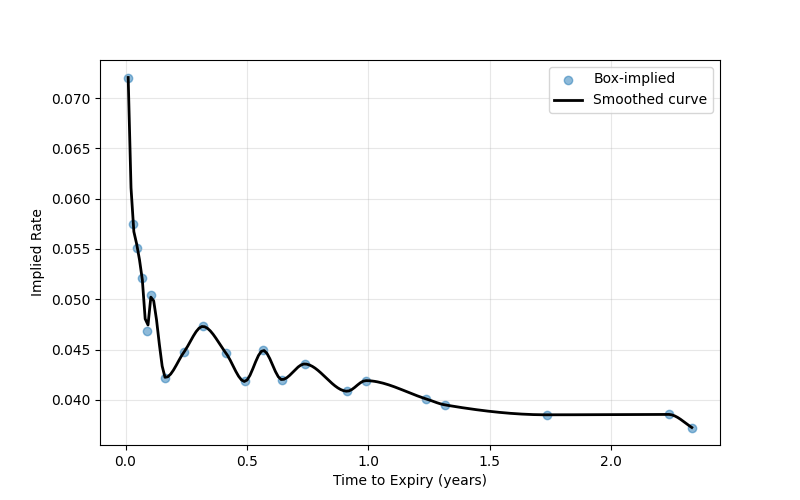

In [402]:
from scipy.interpolate import PchipInterpolator

r_spline = PchipInterpolator(implied_rates.time_to_expiry, implied_rates.implied_rate, extrapolate=True)

t_grid = np.linspace(implied_rates.time_to_expiry.min(), implied_rates.time_to_expiry.max(), 200)

plt.figure(figsize=(8,5))
plt.scatter(implied_rates.time_to_expiry, implied_rates.implied_rate,
            alpha=0.5, label="Box-implied")
plt.plot(t_grid, r_spline(t_grid),
         color="black", lw=2, label="Smoothed curve")

plt.xlabel("Time to Expiry (years)")
plt.ylabel("Implied Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


---

## Section 14: Nelson-Siegel Yield Curve Smoothing

### Why Nelson-Siegel is Necessary

The **implied risk-free rates** extracted from put-call parity regression can be **noisy and erratic** due to:
- Market microstructure noise (bid-ask spreads)
- Liquidity differences across expiries
- Temporary supply/demand imbalances
- Data quality issues at illiquid strikes

**Problems with raw implied rates:**
1. Non-monotonic term structure (short rates > long rates or vice versa)
2. Spurious spikes at specific maturities
3. Negative rates at some tenors
4. Discontinuities between expiry dates

### Nelson-Siegel Model

The **Nelson-Siegel (1987)** parametric curve provides a smooth, economically sensible term structure:

$$
r(T) = \beta_0 + \beta_1 \cdot \frac{1 - e^{-T/\tau}}{T/\tau} + \beta_2 \cdot \left(\frac{1 - e^{-T/\tau}}{T/\tau} - e^{-T/\tau}\right)
$$

**Parameters:**
- $\beta_0$: **Long-term level** (asymptotic rate as $T \to \infty$)
- $\beta_1$: **Short-term component** (affects level at $T = 0$)
- $\beta_2$: **Medium-term hump** (controls curvature)
- $\tau$: **Decay parameter** (controls where hump occurs)

### Shape Interpretation

- **$\beta_0 > 0$**: Positive long-run rate (typical)
- **$\beta_1 < 0$**: Upward sloping curve (normal yield curve)
- **$\beta_1 > 0$**: Inverted curve (recession signal)
- **$\beta_2 < 0$**: Hump-shaped curve
- **$\beta_2 > 0$**: U-shaped curve

### Implementation Details

**Key Feature: Quadratic Weighting**
```python
w = w * (T**2)
```

This **critically important** adjustment:
1. **Downweights short-dated noise**: 1-week options have unstable parity
2. **Emphasizes longer tenors**: 6-month+ options more reliable
3. **Prevents short-end distortion**: Without this, fit chases noisy near-term data

**Bounds:**
- $\beta_0 \in [0, 0.2]$: Reasonable positive rates (0% to 20%)
- $\beta_1, \beta_2 \in [-0.5, 0.5]$: Slope/curvature parameters
- $\tau \in [0.001, 10]$: Prevents degenerate solutions

### Benefits of Smoothed Curve

1. **Arbitrage-free pricing**: Consistent discount factors across strikes/expiries
2. **Stability**: Small data changes don't cause wild rate swings
3. **Interpolation**: Can price options at any maturity, not just market expiries
4. **Extrapolation**: Reasonable rates beyond longest observed maturity
5. **Economic sense**: Shape reflects typical term structure patterns

In [403]:
import numpy as np
from scipy.optimize import least_squares

def nelson_siegel(T, b0, b1, b2, tau):
    T = np.asarray(T, float)
    x = np.maximum(T / tau, 1e-8)
    f1 = (1.0 - np.exp(-x)) / x
    f2 = f1 - np.exp(-x)
    return b0 + b1 * f1 + b2 * f2

def fit_nelson_siegel(T, r, weights=None):
    T = np.asarray(T, float)
    r = np.asarray(r, float)

    if weights is None:
        w = np.ones_like(T)
    else:
        w = np.asarray(weights, float)

    # Downweight the short end noise (very important)
    w = w * (T**2)

    def resid(p):
        b0, b1, b2, tau = p
        model = nelson_siegel(T, b0, b1, b2, tau)
        return np.sqrt(w) * (model - r)

    # initial guess
    b0 = np.median(r[T > np.quantile(T, 0.7)]) if np.any(T > np.quantile(T, 0.7)) else np.median(r)
    x0 = np.array([b0, 0.02, -0.02, 0.5])

    bounds_lo = [0.0, -0.5, -0.5, 1e-3]
    bounds_hi = [0.2,  0.5,  0.5, 10.0]

    res = least_squares(resid, x0, bounds=(bounds_lo, bounds_hi))
    return res.x  # b0,b1,b2,tau

T_data = implied_rates["time_to_expiry"].to_numpy(float)
r_data = implied_rates["implied_rate"].to_numpy(float)

# Optional: drop ultra-short maturities entirely

params = fit_nelson_siegel(T_data, r_data)

def r_curve(T):
    return nelson_siegel(T, *params)

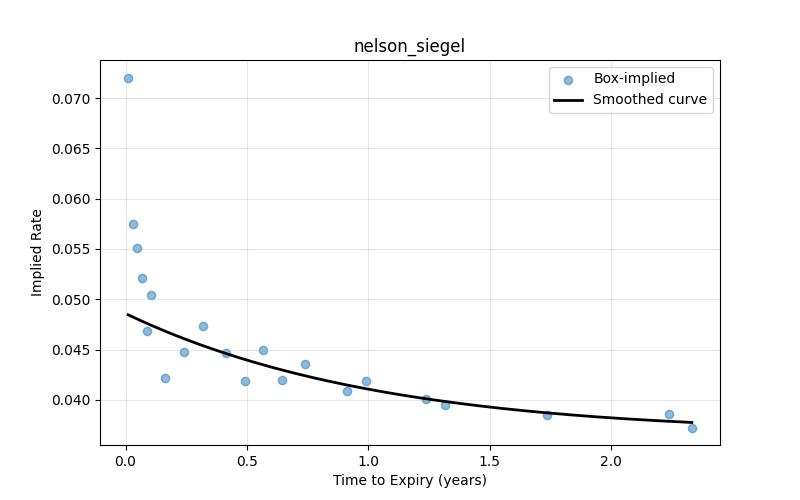

In [404]:
plt.figure(figsize=(8,5))
plt.scatter(implied_rates.time_to_expiry, implied_rates.implied_rate,
            alpha=0.5, label="Box-implied")
plt.plot(t_grid, r_curve(t_grid),
         color="black", lw=2, label="Smoothed curve")
plt.title('nelson_siegel')
plt.xlabel("Time to Expiry (years)")
plt.ylabel("Implied Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Visualize Smoothing Effect

The plot compares:
- **Scatter points**: Raw implied rates from put-call parity (noisy)
- **Black curve**: Nelson-Siegel smoothed curve (stable)

**What to look for:**
- Smooth, continuous curve without jumps
- Sensible shape (upward/downward/humped)
- Good fit to data clouds without overfitting noise

Dropdown(description='Expiration', options=(datetime.date(2025, 9, 26), datetime.date(2025, 10, 3), datetime.d…

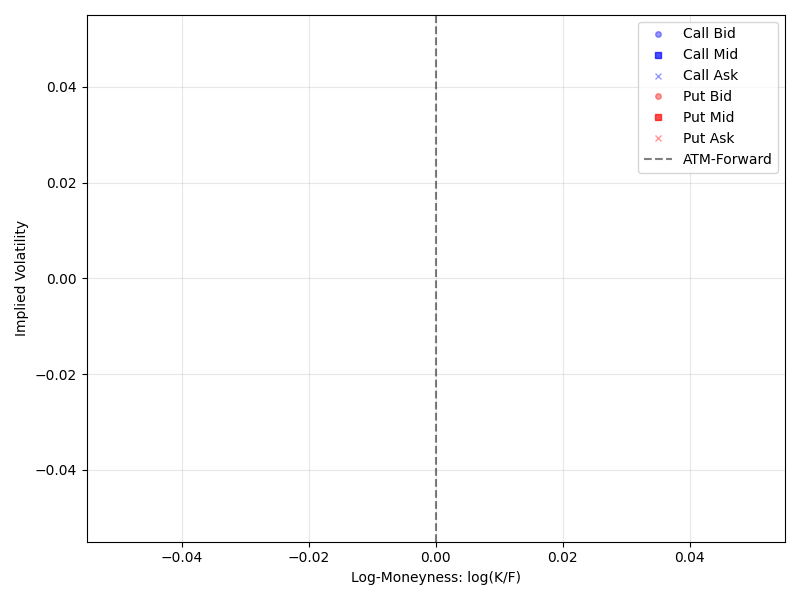

In [473]:
%matplotlib widget
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import warnings
warnings.filterwarnings(
    "ignore",
    message="Passing unrecognized arguments to super",
    category=DeprecationWarning,
)

plt.ion()

# Collect all expirations (from full df_merged, not just one slice)
all_exps = pd.to_datetime(df_merged["expiration"]).dt.date.unique()
all_exps = sorted(all_exps)

exp_dropdown = widgets.Dropdown(
    options=all_exps,
    description="Expiration",
    value=all_exps[0]
)

display(exp_dropdown)

fig, ax = plt.subplots(figsize=(8, 6))

call_bid_plot, = ax.plot([], [], "o", color="blue", alpha=0.4, label="Call Bid", markersize=4)
call_mid_plot, = ax.plot([], [], "s", color="blue", alpha=0.7, label="Call Mid", markersize=5)
call_ask_plot, = ax.plot([], [], "x", color="blue", alpha=0.4, label="Call Ask", markersize=4)

put_bid_plot,  = ax.plot([], [], "o", color="red", alpha=0.4, label="Put Bid", markersize=4)
put_mid_plot,  = ax.plot([], [], "s", color="red", alpha=0.7, label="Put Mid", markersize=5)
put_ask_plot,  = ax.plot([], [], "x", color="red", alpha=0.4, label="Put Ask", markersize=4)

atm_line = ax.axvline(0.0, color="black", linestyle="--", alpha=0.5, label="ATM-Forward")

ax.set_xlabel("Log-Moneyness: log(K/F)")
ax.set_ylabel("Implied Volatility")
ax.legend(loc="best")
ax.grid(True, alpha=0.3)
fig.tight_layout()

def update_iv_plot(df_slice_with_iv, selected_exp_date):
    """
    df_slice_with_iv: slice DataFrame returned from compute_iv_for_slice
    selected_exp_date: a datetime.date from dropdown
    """
    mask_exp = df_slice["expiration"].dt.date == selected_exp_date

    df_slice_with_iv = df_slice_with_iv[mask_exp]

    S0 = data_exp["underlying_mid"].iloc[0]

    # Calculate time to expiration in years
    tau = (selected_exp_date - trade_day).days / 365.25
    r = r_curve(tau)
    
    # Filter dividends for this expiration
    filtered_divs = filter_dividends(discrete, trade_day, selected_exp_date)
    pv_divs = pv_dividends(filtered_divs, trade_day, r)
    
    # Calculate forward price: F = (S0 - PV(divs)) / P(0,T) = (S0 - PV(divs)) * e^(rT)
    F0 = (S0 - pv_divs) * np.exp(r * tau)

    calls = df_slice_with_iv[df_slice_with_iv["instrument_class"] == "C"].copy()
    puts  = df_slice_with_iv[df_slice_with_iv["instrument_class"] == "P"].copy()

    # Log-moneyness
    calls["log_moneyness"] = np.log(calls["strike_price"] / F0)
    puts["log_moneyness"]  = np.log(puts["strike_price"] / F0)

    # OTM only
    calls = calls[calls["strike_price"] >= F0]
    puts  = puts[puts["strike_price"] <= F0]

    # --- SET DATA (this is the key part) ---
    call_bid_plot.set_data(calls.log_moneyness, calls.iv_bid)
    call_mid_plot.set_data(calls.log_moneyness, calls.iv_mid)
    call_ask_plot.set_data(calls.log_moneyness, calls.iv_ask)

    put_bid_plot.set_data(puts.log_moneyness, puts.iv_bid)
    put_mid_plot.set_data(puts.log_moneyness, puts.iv_mid)
    put_ask_plot.set_data(puts.log_moneyness, puts.iv_ask)

    # Rescale axes
    ax.relim()
    ax.autoscale_view()

    fig.canvas.draw()
    fig.canvas.flush_events()

In [474]:
replay = DataReplay(df_merged_with_eep, timestamp_col="ts_recv", realtime=True)

# 1. compute IVs for this 1-second snapshot
selected_exp = exp_dropdown.value  # datetime.date
tau = (selected_exp - trade_day).days / 365.25
r = r_curve(tau)

ax.set_title(f"Euoprean Vol AAPL Option IV Surface after EEP - Expiry: {expiry} (Forward: ${F0:.2f})")

for ts, df_slice in replay:
    df_iv = compute_iv_for_slice(df_slice, r=r, eep_lookup=True)
    update_iv_plot(df_iv, selected_exp)
    print(f"Replay time: {ts}, rows: {len(df_iv)}")


Replay time: 2025-09-22 13:30:01+00:00, rows: 2196
Replay time: 2025-09-22 13:30:02+00:00, rows: 2280
Replay time: 2025-09-22 13:30:03+00:00, rows: 2280
Replay time: 2025-09-22 13:30:04+00:00, rows: 2280
Replay time: 2025-09-22 13:30:05+00:00, rows: 2280
Replay time: 2025-09-22 13:30:06+00:00, rows: 2280
Replay time: 2025-09-22 13:30:07+00:00, rows: 2280
Replay time: 2025-09-22 13:30:08+00:00, rows: 2280
Replay time: 2025-09-22 13:30:09+00:00, rows: 2280
Replay time: 2025-09-22 13:30:10+00:00, rows: 2280
Replay time: 2025-09-22 13:30:11+00:00, rows: 2280
Replay time: 2025-09-22 13:30:12+00:00, rows: 2280
Replay time: 2025-09-22 13:30:13+00:00, rows: 2280
Replay time: 2025-09-22 13:30:14+00:00, rows: 2280
Replay time: 2025-09-22 13:30:15+00:00, rows: 2280
Replay time: 2025-09-22 13:30:16+00:00, rows: 2280
Replay time: 2025-09-22 13:30:17+00:00, rows: 2280
Replay time: 2025-09-22 13:30:18+00:00, rows: 2280
Replay time: 2025-09-22 13:30:19+00:00, rows: 2280
Replay time: 2025-09-22 13:30:2

KeyboardInterrupt: 

### European Interactive Volatility Surface Explorer + EEP consideration for American Options

Use the dropdown to explore IV surfaces across different expiration dates. Each expiry uses the **smoothed Nelson-Siegel rate** for that maturity, ensuring consistent forward pricing.

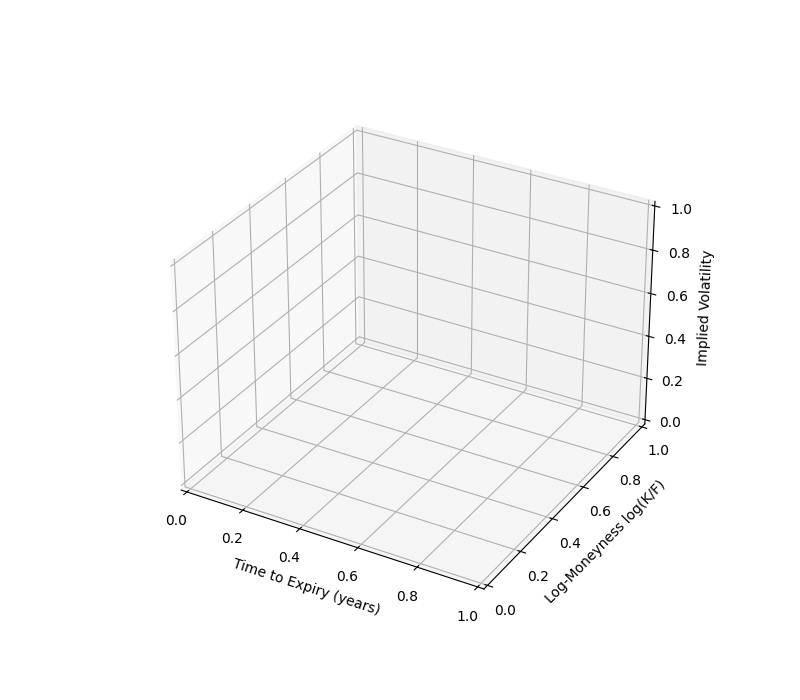

In [475]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.ion()

fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection="3d")

ax.set_xlabel("Time to Expiry (years)")
ax.set_ylabel("Log-Moneyness log(K/F)")
ax.set_zlabel("Implied Volatility")

surf = None  # handle to surface
plt.show()

from scipy.interpolate import griddata
import numpy as np

def build_iv_mesh(df):
    df_mesh = df.copy()

    df_mesh["w"] = (df_mesh["iv_mid"] ** 2) * df_mesh["T"]
    df_mesh = df_mesh[
        (df_mesh["w"] > 0) &
        (df_mesh["T"] > 0) &
        (np.abs(df_mesh["log_moneyness"]) < 1.5)
    ]

    if len(df_mesh) < 20:
        return None

    T_grid = np.linspace(df_mesh["T"].min(), df_mesh["T"].max(), 25)
    k_grid = np.linspace(df_mesh["log_moneyness"].min(),
                         df_mesh["log_moneyness"].max(), 50)

    TT, KK = np.meshgrid(T_grid, k_grid)

    points = np.column_stack([
        df_mesh["T"].values,
        df_mesh["log_moneyness"].values
    ])

    values = df_mesh["w"].values

    W_grid = griddata(points, values, (TT, KK), method="linear")
    W_grid_nn = griddata(points, values, (TT, KK), method="nearest")
    W_grid = np.where(np.isnan(W_grid), W_grid_nn, W_grid)

    IV_grid = np.sqrt(np.maximum(W_grid / TT, 0.0))

    return TT, KK, IV_grid

def update_surface(df):
    global surf

    mesh = build_iv_mesh(df)
    if mesh is None:
        return

    TT, KK, IV_grid = mesh

    # Remove previous surface
    if surf is not None:
        surf.remove()

    # Plot new surface
    surf = ax.plot_surface(
        TT, KK, IV_grid,
        cmap="viridis",
        linewidth=0,
        antialiased=True,
        alpha=0.95
    )

    ax.set_zlim(
        np.nanmin(IV_grid),
        np.nanmax(IV_grid)
    )

    fig.canvas.draw()
    fig.canvas.flush_events()


In [476]:
replay = DataReplay(df_merged_with_eep, timestamp_col="ts_recv", realtime=True)
for ts, df_slice in replay:
    # Time to expiry
    df_slice["T"] = (df_slice["expiration"] - df_slice["ts_recv"]).dt.total_seconds() / (365.25 * 24 * 3600)
    
    # Rate from smooth curve
    df_slice["r"] = df_slice["T"].apply(r_curve)
    
    df_iv = compute_iv_for_slice(df_slice, r=df_slice["r"].values[0], eep_lookup=True)

    df = df_iv.copy()

    # Forward per row
    def compute_forward_row(row):
        expiry = row["expiration"].date()
        tau = row["T"]
        r = row["r"]
        S0 = row["underlying_mid"]
    
        filtered_divs = filter_dividends(discrete, trade_day, expiry)
        pv_divs = pv_dividends(filtered_divs, trade_day, r)
    
        return (S0 - pv_divs) * np.exp(r * tau)
    
    df["F"] = df.apply(compute_forward_row, axis=1)
    
    # Log-moneyness
    df["log_moneyness"] = np.log(df["strike_price"] / df["F"])

    update_surface(df)

    print(f"Replay time: {ts}, rows: {len(df_iv)}")


Replay time: 2025-09-22 13:30:01+00:00, rows: 2196
Replay time: 2025-09-22 13:30:02+00:00, rows: 2280
Replay time: 2025-09-22 13:30:03+00:00, rows: 2280
Replay time: 2025-09-22 13:30:04+00:00, rows: 2280
Replay time: 2025-09-22 13:30:05+00:00, rows: 2280
Replay time: 2025-09-22 13:30:06+00:00, rows: 2280
Replay time: 2025-09-22 13:30:07+00:00, rows: 2280
Replay time: 2025-09-22 13:30:08+00:00, rows: 2280
Replay time: 2025-09-22 13:30:09+00:00, rows: 2280
Replay time: 2025-09-22 13:30:10+00:00, rows: 2280


KeyboardInterrupt: 

### Look at stack European IV market surface

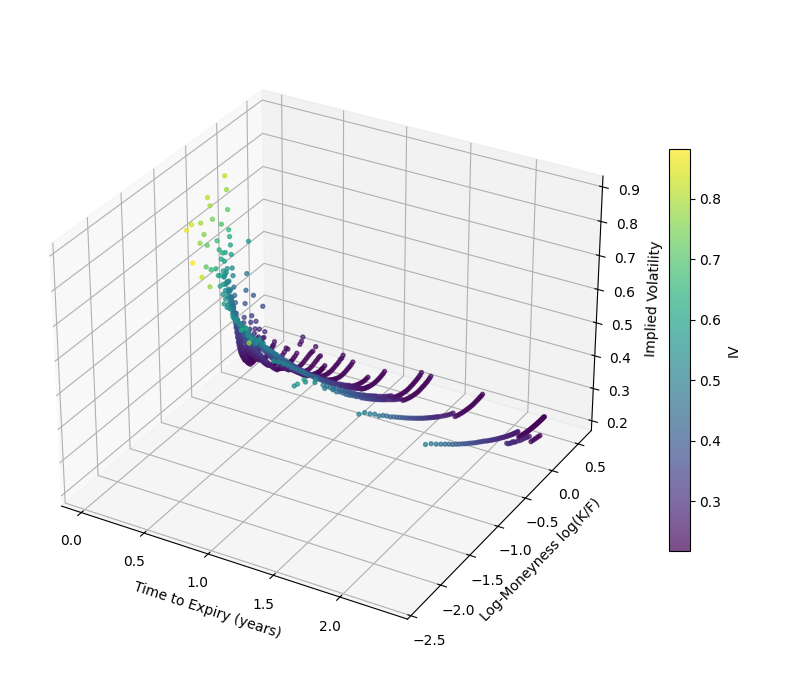

In [477]:
df = df_iv.copy()

# Time to expiry
df["T"] = (df["expiration"] - df["ts_recv"]).dt.total_seconds() / (365.25 * 24 * 3600)

# Rate from smooth curve
df["r"] = df["T"].apply(r_curve)

# Forward per row
def compute_forward_row(row):
    expiry = row["expiration"].date()
    tau = row["T"]
    r = row["r"]
    S0 = row["underlying_mid"]

    filtered_divs = filter_dividends(discrete, trade_day, expiry)
    pv_divs = pv_dividends(filtered_divs, trade_day, r)

    return (S0 - pv_divs) * np.exp(r * tau)

df["F"] = df.apply(compute_forward_row, axis=1)

# Log-moneyness
df["log_moneyness"] = np.log(df["strike_price"] / df["F"])

is_call = df["instrument_class"] == "C"
is_put  = df["instrument_class"] == "P"

df = df[
    ((is_call) & (df["strike_price"] >= df["F"])) |
    ((is_put)  & (df["strike_price"] <= df["F"]))
]

df = df[np.isfinite(df["iv_mid"])]


from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    df["T"],
    df["log_moneyness"],
    df["iv_mid"],
    c=df["iv_mid"],
    cmap="viridis",
    s=8,
    alpha=0.7
)

ax.set_xlabel("Time to Expiry (years)")
ax.set_ylabel("Log-Moneyness log(K/F)")
ax.set_zlabel("Implied Volatility")

fig.colorbar(sc, ax=ax, shrink=0.6, label="IV")
plt.tight_layout()
plt.show()


---

## Section 15: SSVI (Surface Stochastic Volatility Inspired) Model

Developed by Gatheral and Jacquier (2014), the SSVI is a widely used parametric framework designed to model the entire implied volatility surface (IVS) in an arbitrage-free manner. 

### Why SSVI is Necessary

Raw implied volatilities exhibit **complex patterns** that simple parametric curves (like SVI per slice) cannot capture well:

1. **Term structure of ATM vol**: $\sigma_{ATM}(T)$ varies with maturity
2. **Skew dynamics**: Wings steepen/flatten with time
3. **Smile consistency**: Must enforce no-arbitrage across time slices
4. **Calendar spread arbitrage**: Adjacent expiries must be consistent

**SSVI advantages:**
- **Single global calibration** across all strikes and maturities
- **Arbitrage-free by construction** (under parameter constraints)
- **Parsimonious**: Only 3 parameters (plus ATM term structure)
- **Smooth extrapolation**: Reliable for pricing off-market strikes

### SSVI Formulation

Total implied variance:

$$
w(T, k) = \frac{\theta(T)}{2} \left\{1 + \rho \phi(T) k + \sqrt{[\phi(T) k + \rho]^2 + (1 - \rho^2)}\right\}
$$

Where:
- $w(T, k) = \sigma^2(T, k) \cdot T$ = **total variance**
- $T$ = time to maturity (years)
- $k = \ln(K/F)$ = **log-moneyness**
- $\theta(T)$ = **ATM total variance** (fitted per maturity slice first)
- $\phi(T) = \eta \cdot \theta(T)^{-\gamma}$ = **power law decay**

**Global parameters:**
- $\rho \in (-1, 1)$: **Correlation/skew** (negative for equity skew)
- $\eta > 0$: **Volatility of volatility** (wing amplitude)
- $\gamma \in [0, 1]$: **Power law exponent** (term structure of skew)

### Two-Stage Calibration

**Stage 1: Estimate $\theta(T)$ per expiry**

For each maturity $T$, fit quadratic to near-ATM options ($|k| < 0.10$):

$$
w \approx a + b \cdot k + c \cdot k^2
$$

The intercept $a \approx \theta(T)$ is the ATM total variance.

**Why this works:**
- Near ATM, volatility smile is approximately parabolic
- Avoids wing noise from deep OTM options
- Provides stable ATM level per maturity

**Stage 2: Fit global $(\rho, \eta, \gamma)$**

Given $\theta(T)$ from Stage 1, optimize:

$$
\min_{\rho, \eta, \gamma} \sum_{i} w_i \left[w_{\text{SSVI}}(T_i, k_i) - w_{\text{obs},i}\right]^2
$$

**Weighting scheme:**
```python
weights = (T**2) * exp(-|k|/k0)
```

- **$T^2$ factor**: Emphasizes longer maturities (more liquid, stable)
- **Exponential decay**: Down-weights far OTM wings (less reliable)
- **$k_0 = 0.5$**: Decay rate (tune based on data quality)

### Parameter Interpretation

**$\rho$ (Correlation):**
- $\rho < 0$: **Left skew** (typical for equities) - OTM puts have higher IV
- $\rho = 0$: Symmetric smile
- $\rho > 0$: Right skew (rare)

**$\eta$ (Vol-of-vol):**
- Higher $\eta$: **Wider smile** (stronger wings)
- Lower $\eta$: Flatter smile (more like Black-Scholes)

**$\gamma$ (Power law):**
- $\gamma = 0$: Skew **doesn't decay** with maturity (fixed $\phi$)
- $\gamma = 0.5$: **Square root decay** (common in practice)
- $\gamma = 1$: **Linear decay** (skew flattens fastest)

### Arbitrage Constraints

SSVI is **arbitrage-free** if:

1. **Butterfly arbitrage**: $\frac{\partial^2 w}{\partial k^2} \geq 0$ (convexity)
2. **Calendar arbitrage**: $\frac{\partial w}{\partial T} \geq 0$ (increasing variance)

These are **automatically satisfied** if:
- $|\rho| < 1$
- $\eta > 0$
- $\gamma \in [0, 1]$
- $\theta(T)$ is monotone increasing

### Model Output

After calibration, we have a **continuous function** $\sigma(T, k)$ that:
- Interpolates smoothly between observed strikes
- Extrapolates reasonably to deep OTM options
- Respects no-arbitrage conditions
- Can price exotics requiring full surface (barriers, cliquets, etc.)

In [411]:
import numpy as np
import pandas as pd

df_surf = df.copy()  # your full surface DataFrame
df_surf = df_surf[np.isfinite(df_surf["iv_mid"]) & (df_surf["T"] > 0)]
df_surf = df_surf[np.isfinite(df_surf["log_moneyness"])]

df_surf["k"] = df_surf["log_moneyness"].astype(float)
df_surf["w"] = (df_surf["iv_mid"].astype(float) ** 2) * df_surf["T"].astype(float)


In [412]:
def estimate_theta_by_T(df, k_band=0.10, min_pts=5):
    thetas = []
    for T, g in df.groupby("T"):
        gg = g[np.abs(g["k"]) <= k_band].copy()
        if len(gg) < min_pts:
            continue
        k = gg["k"].to_numpy()
        w = gg["w"].to_numpy()

        # quadratic: w ≈ a + b k + c k^2, so a ≈ theta(T)
        X = np.column_stack([np.ones_like(k), k, k**2])
        a, b, c = np.linalg.lstsq(X, w, rcond=None)[0]
        if a > 0:
            thetas.append((T, a))

    theta_df = pd.DataFrame(thetas, columns=["T", "theta"]).sort_values("T")
    return theta_df

theta_df = estimate_theta_by_T(df_surf, k_band=0.10, min_pts=5)


### Stage 1: Estimate ATM Total Variance $\theta(T)$

Extract ATM level per expiry using **near-ATM quadratic fit**. This isolates the term structure of ATM volatility before fitting the global smile parameters.

In [413]:
from scipy.interpolate import PchipInterpolator

# ensure increasing in T; clip to avoid zeros
T_nodes = theta_df["T"].to_numpy()
theta_nodes = np.maximum(theta_df["theta"].to_numpy(), 1e-10)

theta_spline = PchipInterpolator(T_nodes, theta_nodes, extrapolate=True)

def theta_of_T(T):
    T = np.asarray(T, float)
    return np.maximum(theta_spline(T), 1e-10)


### Smooth $\theta(T)$ with Monotone Interpolation

Use **PCHIP (Piecewise Cubic Hermite Interpolating Polynomial)** to interpolate $\theta(T)$:

**Why PCHIP?**
- **Monotonicity preserving**: If data points increase, curve increases (prevents arbitrage)
- **Smooth**: $C^1$ continuous (no kinks)
- **Local**: Changes to one point don't affect distant regions
- **No overshoot**: Unlike cubic splines, doesn't oscillate wildly

**Extrapolation:** For $T$ beyond observed range, curve extends linearly (safe for short extrapolation).

In [414]:
def ssvi_total_var(T, k, rho, eta, gamma):
    T = np.asarray(T, float)
    k = np.asarray(k, float)

    th = theta_of_T(T)
    phi = eta * (th ** (-gamma))

    x = phi * k
    inside = (x + rho)**2 + (1.0 - rho**2)
    return 0.5 * th * (1.0 + rho * x + np.sqrt(inside))


### SSVI Total Variance Formula

Core pricing function: converts $(T, k)$ to total implied variance $w = \sigma^2 T$.

**Structure:**
1. Look up $\theta(T)$ from interpolated ATM curve
2. Calculate $\phi(T) = \eta \cdot \theta(T)^{-\gamma}$ (power law decay)
3. Evaluate square root formula for smile shape

In [478]:
from scipy.optimize import least_squares

T_obs = df_surf["T"].to_numpy(float)
k_obs = df_surf["k"].to_numpy(float)
w_obs = df_surf["w"].to_numpy(float)

# default weights
k0 = 0.5
weights = (T_obs**2) * np.exp(-np.abs(k_obs)/k0)
weights = np.maximum(weights, 1e-8)

def residuals(p):
    rho, eta, gamma = p
    w_model = ssvi_total_var(T_obs, k_obs, rho, eta, gamma)
    return np.sqrt(weights) * (w_model - w_obs)

# bounds / init
x0 = np.array([-0.3, 0.8, 0.5])   # rho, eta, gamma
lb = np.array([-0.999, 1e-6, 0.0])
ub = np.array([ 0.999, 50.0, 1.0])

res = least_squares(residuals, x0, bounds=(lb, ub), max_nfev=5000)
rho_hat, eta_hat, gamma_hat = res.x

print("SSVI fit:")
print("rho   =", rho_hat)
print("eta   =", eta_hat)
print("gamma =", gamma_hat)


SSVI fit:
rho   = -0.4432574703693648
eta   = 0.8331593973449125
gamma = 0.4960465176014499


### Stage 2: Global Calibration

Optimize $(\rho, \eta, \gamma)$ to fit entire surface simultaneously.

**Weighting rationale:**
- **$T^2$ weighting**: Long-dated options more stable, should dominate fit
- **Exponential $k$ decay**: Far wings less reliable (wide spreads, low volume)
- **Combined effect**: Focus calibration on liquid, ATM-ish region of longer tenors

**Initial guess:** $\rho = -0.3$ (left skew), $\eta = 0.8$ (moderate wings), $\gamma = 0.5$ (square root decay)

**Bounds ensure arbitrage-free:**
- $|\rho| < 1$: Correlation in valid range
- $\eta > 0$: Positive vol-of-vol
- $\gamma \in [0, 1]$: Power law stays reasonable

In [416]:
def ssvi_iv(T, k):
    w = ssvi_total_var(T, k, rho_hat, eta_hat, gamma_hat)
    return np.sqrt(np.maximum(w / T, 0.0))


### Convert Total Variance to Implied Volatility

Final convenience function: $\sigma(T, k) = \sqrt{w(T, k) / T}$

This is the **implied volatility surface** ready for:
- Option pricing at arbitrary strikes
- Risk management (Greeks)
- Model calibration (local vol, stochastic vol)
- Arbitrage detection

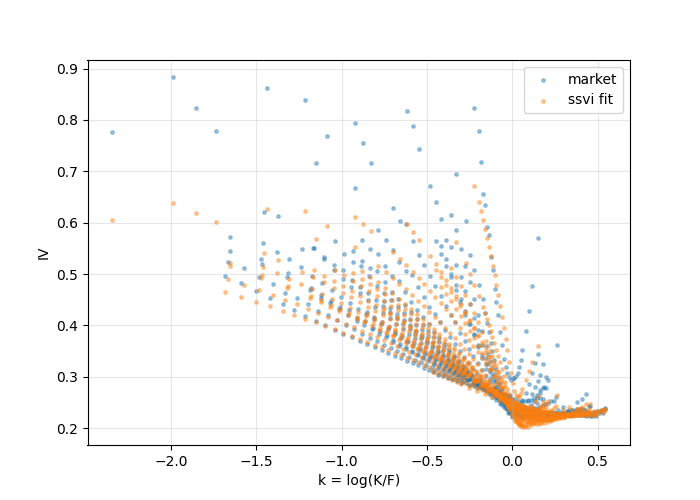

In [479]:
w_fit = ssvi_total_var(T_obs, k_obs, rho_hat, eta_hat, gamma_hat)
iv_fit = np.sqrt(np.maximum(w_fit / T_obs, 0.0))

# quick diagnostic
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.scatter(df_surf["k"], df_surf["iv_mid"], s=6, alpha=0.4, label="market")
plt.scatter(df_surf["k"], iv_fit, s=6, alpha=0.4, label="ssvi fit")
plt.xlabel("k = log(K/F)")
plt.ylabel("IV")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### Visualize SSVI Fit Quality

Compare fitted SSVI surface against market observations to assess calibration quality. Look for:
- Smooth surface without artifacts
- Good fit in liquid region (near ATM, medium term)
- Reasonable extrapolation to wings and extremes
- No systematic bias patterns

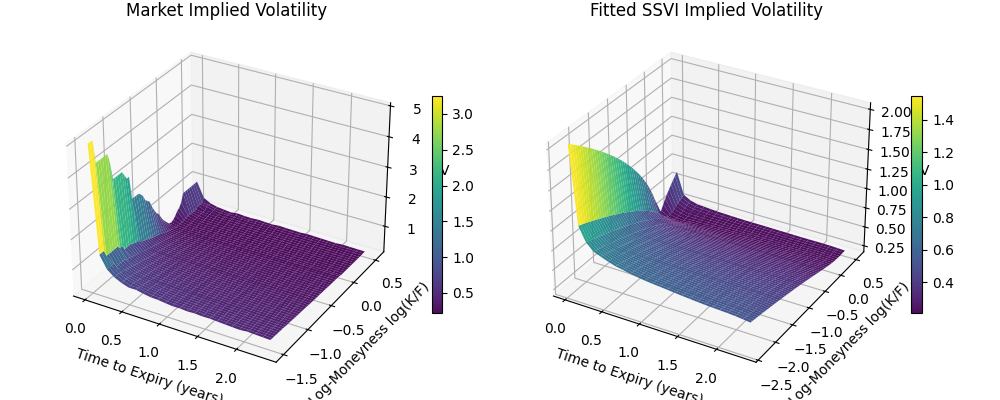

In [480]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# =========================
# Market implied IV surface
# =========================

df_mesh = df.copy()
df_mesh["w"] = (df_mesh["iv_mid"] ** 2) * df_mesh["T"]

df_mesh = df_mesh[
    (df_mesh["w"] > 0) &
    (df_mesh["T"] > 0) &
    (np.abs(df_mesh["log_moneyness"]) < 1.5)
]

T_grid = np.linspace(df_mesh["T"].min(), df_mesh["T"].max(), 25)
k_grid = np.linspace(df_mesh["log_moneyness"].min(),
                     df_mesh["log_moneyness"].max(), 50)

TT, KK = np.meshgrid(T_grid, k_grid)

points = np.column_stack([
    df_mesh["T"].values,
    df_mesh["log_moneyness"].values
])
values = df_mesh["w"].values

W_grid = griddata(points, values, (TT, KK), method="linear")
W_grid_nn = griddata(points, values, (TT, KK), method="nearest")
W_grid = np.where(np.isnan(W_grid), W_grid_nn, W_grid)

IV_market = np.sqrt(np.maximum(W_grid / TT, 0.0))

# =========================
# SSVI surface
# =========================

T_grid_ssvi = np.linspace(df["T"].min(), df["T"].max(), 25)
k_grid_ssvi = np.linspace(df["log_moneyness"].min(),
                          df["log_moneyness"].max(), 50)

TT_s, KK_s = np.meshgrid(T_grid_ssvi, k_grid_ssvi)
IV_ssvi = ssvi_iv(TT_s, KK_s)

# =========================
# Side-by-side plot
# =========================

fig = plt.figure(figsize=(10, 4))

# --- Market IV ---
ax1 = fig.add_subplot(121, projection="3d")
surf1 = ax1.plot_surface(
    TT, KK, IV_market,
    cmap="viridis",
    linewidth=0,
    antialiased=True,
    alpha=0.95
)
ax1.set_title("Market Implied Volatility")
ax1.set_xlabel("Time to Expiry (years)")
ax1.set_ylabel("Log-Moneyness log(K/F)")
ax1.set_zlabel("IV")
fig.colorbar(surf1, ax=ax1, shrink=0.6)

# --- SSVI IV ---
ax2 = fig.add_subplot(122, projection="3d")
surf2 = ax2.plot_surface(
    TT_s, KK_s, IV_ssvi,
    cmap="viridis",
    linewidth=0,
    antialiased=True,
    alpha=0.95
)
ax2.set_title("Fitted SSVI Implied Volatility")
ax2.set_xlabel("Time to Expiry (years)")
ax2.set_ylabel("Log-Moneyness log(K/F)")
ax2.set_zlabel("IV")
fig.colorbar(surf2, ax=ax2, shrink=0.6)

plt.tight_layout()
plt.show()


### Time slice differences overlayed

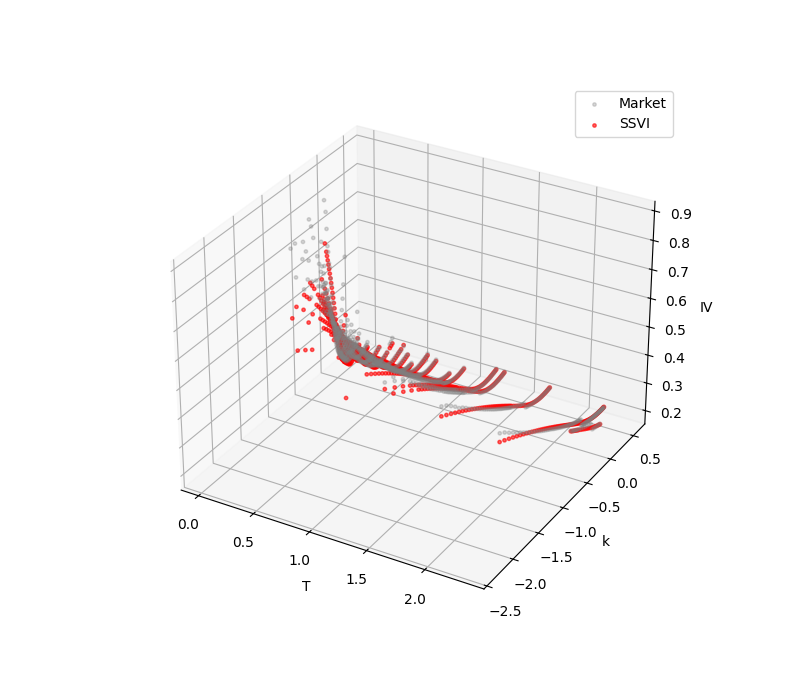

In [419]:
iv_fit = ssvi_iv(df["T"].values, df["log_moneyness"].values)

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(df["T"], df["log_moneyness"], df["iv_mid"],
           color="gray", s=6, alpha=0.3, label="Market")

ax.scatter(df["T"], df["log_moneyness"], iv_fit,
           color="red", s=6, alpha=0.6, label="SSVI")

ax.set_xlabel("T")
ax.set_ylabel("k")
ax.set_zlabel("IV")
ax.legend()
plt.show()


## Price American Options Across the Entire Curve (OTM, ATM, ITM) 

#### 1. Subtract EEP($\tau$,K) from each market call/put mid price ($\tau$, K)
#### 2. SSVI to get a European implied vol for every ($\tau$, K)
#### 3. Price one side (e.g., calls) with BSM
#### 4. Use put–call parity to get the other side consistently
#### 5. Add EEP($\tau$,K) back to get American prices

For you at home to consider:
- Consider risk-free arbitrage checks: calendar spreads, across strikes. 
- Consider how market-making model would consider bid-ask spread around this computed model "fair-value"

In [481]:
import numpy as np
import pandas as pd
from py_vollib_vectorized import vectorized_black_scholes_merton


def ssvi_iv_by_strike(T, K, F, eps=1e-8):
    """
    Vectorized SSVI implied vol by strike.
    """
    T = np.maximum(np.asarray(T, float), eps)
    k = np.log(np.asarray(K, float) / np.asarray(F, float))
    return ssvi_iv(T, k)   # assumes ssvi_iv is vectorized-safe


def price_european_bsm_from_ssvi(df):
    """
    Fully vectorized European option pricing using:
      - SSVI implied vol
      - BSM (py_vollib_vectorized)

    Required columns in df:
      underlying_mid, strike_price, T, r, F, instrument_class

    Returns
    -------
    DataFrame with added column:
      - Price (European option price)
    """
    out = df.copy()

    # flags: 'c' / 'p'
    out["flag"] = out["instrument_class"].str.lower()

    # SSVI implied vol
    out["iv_ssvi"] = ssvi_iv_by_strike(
        out["T"].values,
        out["strike_price"].values,
        out["F"].values,
    )

    # Dividend yield implied by forward (parity-consistent)
    # q = r - ln(F/S)/T
    out["q"] = (
        out["r"].values
        - np.log(out["F"].values / out["underlying_mid"].values) / out["T"].values
    )

    # Vectorized BSM pricing
    prices = vectorized_black_scholes_merton(
        flag=out["flag"].values,
        S=out["underlying_mid"].values,
        K=out["strike_price"].values,
        t=out["T"].values,
        r=out["r"].values,
        q=out["q"].values,
        sigma=out["iv_ssvi"].values,
    )

    # vectorized_black_scholes_merton returns a DataFrame
    out["european"] = prices["Price"].values

    return out


In [482]:
df_calls = df[df["instrument_class"] == "C"].copy()
df_puts  = df[df["instrument_class"] == "P"].copy()

df_calls = df_calls.merge(
    calls_eep_df[["expiry","strike_price","eep"]].rename(columns={"eep":"eep_call"}),
    on=["expiry","strike_price"], how="left"
)

df_puts = df_puts.merge(
    puts_eep_df[["expiry","strike_price","eep"]].rename(columns={"eep":"eep_put"}),
    on=["expiry","strike_price"], how="left"
)

df = pd.concat([df_calls, df_puts], axis=0).sort_index()
df["eep_call"] = df["eep_call"].fillna(0.0)
df["eep_put"]  = df["eep_put"].fillna(0.0)


def compute_forward_row(row):
    expiry = row["expiry"]
    T = row["T"]
    r = row["r"]
    S0 = row["underlying_mid"]
    divs = filter_dividends(discrete, trade_day, expiry)
    pv = pv_dividends(divs, trade_day, r)
    return (S0 - pv) * np.exp(r * T)

df["F"] = df.apply(compute_forward_row, axis=1)


df = price_european_bsm_from_ssvi(df)

df[[
    "expiration",
    "instrument_class",
    "strike_price",
    "european"
]].head()

df["EEP"] = np.where(
    df["instrument_class"] == "C",
    df["eep_call"],
    df["eep_put"],
)

df["american"] = df["european"] + df["EEP"]

df['log_moneyness'] = np.log(np.asarray(df['strike_price'], float) / np.asarray(df["F"], float))
# df['rel_spread'] = (df['ask_px_00'] - df['bid_px_00'])/df['opt_mid']
# df['abs_spread'] = (df['ask_px_00'] - df['bid_px_00'])



### Final Pricing of american options across the chain ITM, ATM, OTM all using SSVI

In [483]:
out = df[[
    "ts_recv","expiration","expiry","instrument_class","strike_price",
    "underlying_mid","T","r","F","log_moneyness",
    "european","EEP","american"
]].copy()
out

,ts_recv,expiration,expiry,instrument_class,strike_price,underlying_mid,T,r,F,log_moneyness,european,EEP,american
0,2025-09-22 13:30:10+00:00,2026-12-18 00:00:00+00:00,2026-12-18,C,390.0,249.255,1.235968,0.040124,260.544913,0.403371,1.860365,0.000000e+00,1.860365
0,2025-09-22 13:30:10+00:00,2027-12-17 00:00:00+00:00,2027-12-17,P,200.0,249.255,2.232546,0.037887,268.670801,-0.295169,13.585687,6.929042e-01,14.278591
1,2025-09-22 13:30:10+00:00,2026-06-18 00:00:00+00:00,2026-06-18,P,215.0,249.255,0.734942,0.042431,256.338410,-0.175860,7.816331,2.064798e-01,8.022811
1,2025-09-22 13:30:10+00:00,2026-09-18 00:00:00+00:00,2026-09-18,C,275.0,249.255,0.986824,0.041132,258.489209,0.061917,16.928870,0.000000e+00,16.928870
2,2025-09-22 13:30:10+00:00,2026-06-18 00:00:00+00:00,2026-06-18,C,270.0,249.255,0.734942,0.042431,256.338410,0.051923,14.553014,0.000000e+00,14.553014
...,...,...,...,...,...,...,...,...,...,...,...,...,...
603,2025-09-22 13:30:10+00:00,2025-11-21 00:00:00+00:00,2025-11-21,P,135.0,249.255,0.162731,0.046839,250.901773,-0.619787,0.016042,2.361122e-09,0.016042
604,2025-09-22 13:30:10+00:00,2027-12-17 00:00:00+00:00,2027-12-17,P,60.0,249.255,2.232546,0.037887,268.670801,-1.499142,0.314323,9.850243e-05,0.314422
605,2025-09-22 13:30:10+00:00,2027-06-17 00:00:00+00:00,2027-06-17,P,65.0,249.255,1.731519,0.038729,264.569972,-1.403718,0.242225,3.354451e-05,0.242258
606,2025-09-22 13:30:10+00:00,2025-10-17 00:00:00+00:00,2025-10-17,P,185.0,249.255,0.066906,0.047837,250.054031,-0.301321,0.032145,7.779730e-07,0.032146


# Recommended Improvements for Real‑time American Option Pricing via SSVI + Early Exercise Premium (EEP) Cache

What we're doing:

1. **SSVI → European IV** for every $\tau, K$
2. **Price one side (calls) with BSM**  
3. **Use put–call parity** for the other side  
4. **Add** ${EEP}(\tau, K)$ **back** to get American prices

Currently we are **precomputing EEP on a $(\tau, K)$ grid once at start-of-day for fixed $S$ and vol**.

Below are improvements focused on **fast intraday lookups** and **robust cache updates** as $S$ and the vol surface move.



### 1) Improve the cache coordinates (make it more “market invariant”)

#### A. Cache in *log-moneyness* (or forward moneyness), not raw $K$
EEP is strongly tied to **moneyness**, not absolute strike.

- Use **forward** $F = S e^{(r-q)\tau}$ if you can (best)  
- Cache vs **$k = \log(K/F)$** (or $K/F$), plus $\tau$

This makes intraday lookups cheap: when $S$ moves, you mostly **shift $k$** rather than rebuilding a whole $K$-grid.

This reduces sensitivity to spot level changes and improves interpolation stability.


### 2) Intraday update strategies for the EEP cache

You have two realistic approaches:

#### Option 1 — “3D cache”: add a vol dimension and interpolate
This is the most robust and still fast.

##### What to precompute
At start-of-day, build EEP on:
$
(\tau, k, \sigma) \quad \text{where } \sigma \text{ is a small set of representative vols.}
$

Example vol slices:
- $\sigma \in \{0.10, 0.15, 0.20, 0.25, 0.30, 0.40\}$ (choose per asset)

Then intraday:
1. compute $F$ and $k=\log(K/F)$
2. get $\sigma_{\text{euro}}(\tau,k)$ from SSVI
3. tri-linear interpolate $p(\tau,k,\sigma)$
4. $\text{EEP}=F\cdot p$

**Pros:** handles vol moves naturally  
**Cons:** more memory / start-of-day compute

##### Practical tip
Instead of global vol slices, you can slice by **maturity buckets** using ATM vol levels for that bucket.

---

#### Option 2 — “2D cache + fast sensitivity update” (Taylor correction)
Keep your cache at $(\tau,k)$ for a **base vol surface**, and adjust intraday:

$
\text{EEP}_{\text{now}} \approx \text{EEP}_0
+ \frac{\partial \text{EEP}}{\partial S}\Delta S
+ \frac{\partial \text{EEP}}{\partial \sigma}\Delta \sigma
$

##### How to get the sensitivities cheaply
At start-of-day, for each grid point $(\tau,k)$, compute finite-difference:
- $\partial \text{EEP}/\partial \sigma$ using $\sigma_0 \pm \epsilon$
- optionally $\partial \text{EEP}/\partial S$ using $S_0 \pm \epsilon$

Cache:
- $\text{EEP}_0(\tau,k)$
- $\text{vEEP}(\tau,k)=\partial \text{EEP}/\partial \sigma$
- (optional) $\text{sEEP}(\tau,k)=\partial \text{EEP}/\partial S$

Intraday:
- $\Delta \sigma$ comes from current SSVI vs base SSVI at the same $(\tau,k)$
- $\Delta S = S_{\text{now}}-S_0$

**Pros:** small memory, very fast  
**Cons:** accuracy degrades for large regime shifts (big vol jumps, stress)

**Tip:** Clamp corrections to keep EEP non-negative, e.g. `EEP = max(EEP, 0.0)`.

---

## Most important improvements

- subscribe to corporate actions API to automate retreival of future dividend dates
- Handling spot moves without rebuilding the grid
- Cache invalidation / refresh rules (simple and effective)
- Pricing consistency - using the same numerical scheme (so parity + EEP doesn’t drift)